In [1]:
import rpy2

%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)
library(ggpubr)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Plots and Models for Ne estimates

In [59]:
%%R
df <- read_delim('../../results/model/Ne_models/species_estimate_mu_ne.csv', delim = ',')
pg_names <- read_delim('../../data/genus_phylogenetic_group_metadata.txt', delim = '\t')
primates <- read_delim('../../data/primates_bergeron2023.csv', delim = ',')


New names:
• `` -> `...1`
Rows: 188 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): species, GENUS, SPECIES, FAMILY, estimated_mutation_rates, Ne
dbl (11): ...1, pi, GENERATION_LENGTH, MEAN, VARIANCE, MEDIAN, NE_MEAN, NE_V...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 57 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): genus, pg_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 14 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): ID, Species_name, Common_name
dbl (6): ...1, Mutation rate per site per generation (m_generation), Pat

In [60]:
%%R
df <- left_join(df,pg_names, by = c('GENUS'='genus'))

## Visualizing the mutation rate model

In [61]:
%%R
#load data 
alphas <- read_delim('../../results/model/Ne_models/alphas.csv', delim = ',')
betas <- read_delim('../../results/model/Ne_models/betas.csv', delim = ',')

Rows: 4000 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (1): alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4000 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (1): beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [62]:
%%R
ribbon <- tibble('alpha'=alphas$alpha,'beta'=betas$beta)

In [63]:
%%R

mutationrates <- df %>% select(pg_name,SPECIES,GENUS,estimated_mutation_rates)

# Unnest the mutationrates column
mutationrates_long <- mutationrates %>%
  mutate(estimated_mutation_rates = 
         map(estimated_mutation_rates, 
             ~as.numeric(strsplit(.x, ",")[[1]])
        )
        ) %>%
        unnest(estimated_mutation_rates)


In [64]:
%%R
Nes <- df %>% select(pg_name,SPECIES,GENUS,Ne)

# Unnest the mutationrates column
Nes_long <- Nes %>%
  mutate(estimate_nes = 
         map(Ne, 
             ~as.numeric(strsplit(.x, ",")[[1]])
        )
        ) %>%
        unnest(estimate_nes)

In [65]:
%%R
primates <- primates %>% mutate(genus = sapply(strsplit(Species_name, split = '_'), "[", 1))
primates <- left_join(primates, pg_names, by = c('genus'='genus'))

In [66]:
%%R
primates <- primates %>% mutate(pg_name = ifelse(is.na(pg_name), 'Great_apes', pg_name))

In [67]:
%%R
primates

# A tibble: 14 × 11
    ...1 ID         Species_name Common_name Mutation rate per si…¹ Paternal_age
   <dbl> <chr>      <chr>        <chr>                        <dbl>        <dbl>
 1    20 boliv2_3   Saimiri_bol… Bolivian s…          0.00000000993         11.5
 2    21 bolivian_… Saimiri_bol… Bolivian s…          0.00000000565          3.7
 3    22 bolivian_… Saimiri_bol… Bolivian s…          0.00000000512          3.5
 4    26 chimp_3    Pan_troglod… Chimpanzee           0.0000000125          19  
 5    34 drill_3a   Mandrillus_… Drill                0.00000000747         14  
 6    35 drill_3b   Mandrillus_… Drill                0.00000000519         15  
 7    53 gibbon_3   Hylobates_l… lar gibbon           0.00000000705          8.1
 8    59 human_3a   Homo_sapiens Human                0.00000000933         26.5
 9    60 human_3b   Homo_sapiens Human                0.000000014           29  
10   111 saki_3b    Pithecia_pi… white-face…          0.0000000109          14.1
11   112

In [68]:
%%R
#calculate the hdpi around my data
hpdi <- function(x,p=0.95,samples=10){
    low <- rep(NA,length(x))
    high <- rep(NA,length(x))
    mean <- rep(NA,length(x))
    for (i in seq_along(x))
    {
        alpha <- sample(alphas$alpha, samples, replace = T)
        beta <- sample(betas$beta, samples, replace = T)
        predictions <- alpha + beta * log10(i)
        ends <- (1-p)/2
        low[i] <- quantile(predictions,prob=ends)
        high[i] <- quantile(predictions,prob=1-ends)
        mean[i] <- mean(predictions)
    }
    return (tibble(generation_times = x, mean = mean, low = low, high = high))
    }



In [69]:
%%R
generation_times <- seq(from = 1, to = 30, by=((30-0.1)/(1000-1)))
model = hpdi(generation_times,samples=1000, p=0.5)

In [70]:
%%R
model

# A tibble: 969 × 4
   generation_times          mean           low          high
              <dbl>         <dbl>         <dbl>         <dbl>
 1             1    0.00000000247 0.00000000114 0.00000000343
 2             1.03 0.00000000426 0.00000000288 0.00000000528
 3             1.06 0.00000000518 0.00000000386 0.00000000626
 4             1.09 0.00000000590 0.00000000452 0.00000000706
 5             1.12 0.00000000663 0.00000000526 0.00000000782
 6             1.15 0.00000000703 0.00000000569 0.00000000829
 7             1.18 0.00000000741 0.00000000594 0.00000000866
 8             1.21 0.00000000790 0.00000000647 0.00000000919
 9             1.24 0.00000000810 0.00000000670 0.00000000945
10             1.27 0.00000000839 0.00000000692 0.00000000996
# ℹ 959 more rows
# ℹ Use `print(n = ...)` to see more rows


In [71]:
%%R
library(tibble)
library(ggplot2)
library(dplyr)
library(purrr)

# Define parameters
sample <- 1000
alpha_vec <- sample(alphas$alpha, sample, replace = TRUE)
beta_vec <- sample(betas$beta, sample, replace = TRUE)

# Generate sampled points
sampled_points <- map_dfr(1:sample, ~{
  alpha <- sample(alpha_vec, 1)
  beta <- sample(beta_vec, 1)
  tibble(x = seq(1, 30, by = 0.2), y = alpha + beta * log10(x))
})

sampled_points$x <- as.character(sampled_points$x)

HPDI_nes <- sampled_points %>% 
    group_by(x) %>%
    reframe(
        fifty_low = quantile(y,0.25),
        fifty_max = quantile(y,0.75),
        seventyfive_low = quantile(y,0.125),
        seventyfive_max = quantile(y,0.875),
        ninetyfive_low = quantile(y,0.025),
        ninetyfive_max = quantile(y,0.975)
        )
HPDI_nes$x <- as.double(HPDI_nes$x)
HPDI_nes

# A tibble: 146 × 7
       x     fifty_low  fifty_max seventyfive_low seventyfive_max ninetyfive_low
   <dbl>         <dbl>      <dbl>           <dbl>           <dbl>          <dbl>
 1   1   0.00000000116    3.51e-9        6.37e-10   0.00000000479       2.46e-10
 2   1.2 0.00000000167    4.02e-9        1.14e- 9   0.00000000527       6.80e-10
 3   1.4 0.00000000206    4.39e-9        1.55e- 9   0.00000000571       1.10e- 9
 4   1.6 0.00000000241    4.76e-9        1.92e- 9   0.00000000610       1.39e- 9
 5   1.8 0.00000000269    5.09e-9        2.22e- 9   0.00000000644       1.58e- 9
 6  10   0.00000000712    1.00e-8        5.97e- 9   0.0000000113        4.18e- 9
 7  10.2 0.00000000716    1.01e-8        6.00e- 9   0.0000000113        4.20e- 9
 8  10.4 0.00000000721    1.02e-8        6.04e- 9   0.0000000114        4.21e- 9
 9  10.6 0.00000000726    1.02e-8        6.07e- 9   0.0000000115        4.23e- 9
10  10.8 0.00000000730    1.03e-8        6.10e- 9   0.0000000115        4.24e- 9
# ℹ 136 

In [72]:
%%R

ne_model_fig <- ggplot() + 
    geom_ribbon(data=HPDI_nes, aes(x = x, ymin = fifty_low, ymax = fifty_max), fill='grey', alpha = .5)+
    geom_ribbon(data=HPDI_nes, aes(x = x, ymin = seventyfive_low, ymax = seventyfive_max), fill='grey', alpha = .5)+
    geom_ribbon(data=HPDI_nes, aes(x = x, ymin = ninetyfive_low, ymax = ninetyfive_max), fill='grey', alpha = .5)+
    geom_point(data = primates, aes(x = Avg_age, y = m_generation, fill = factor(pg_name)), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1) +
    scale_fill_manual(values = c("#240a34", "#891652", "#eabe6c"))+
    ggpubr::theme_pubr() +
    #geom_line(data = mean_line, aes(x = x, y= y, col = 'red'))+
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(limits = c(0,1.8e-8), expand = expansion(mult = c(0,0)))+
    labs(x = "Generation Times", y = "Mutation rate per \n site per generation")+
    theme(legend.position = 'none')


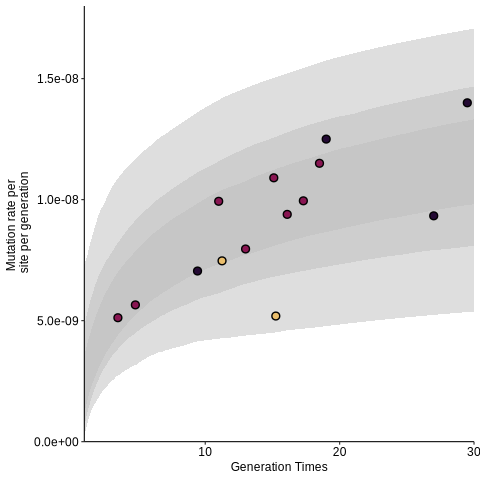

In [73]:
%%R
ne_model_fig

## Results of the model

In [74]:
%%R

density_of_mutation_rates <- ggplot(mutationrates_long, aes(x = estimated_mutation_rates, group = SPECIES)) +
  geom_density(aes(fill = pg_name), alpha = 1) +
  labs(x = "Mutation Rates", y = "Density", size = 55) +
     ggpubr::theme_pubr() +
    scale_fill_manual(values = c("#240a34", "#891652", "#eabe6c", "#db7552"))+
    scale_x_continuous(limits = c(0,2*10**(-8)), expand = c(0, 0)) +
  scale_y_continuous(limits = c(0,2.5e8), expand = expansion(mult = c(0,0)))+
    theme(legend.position = 'none')





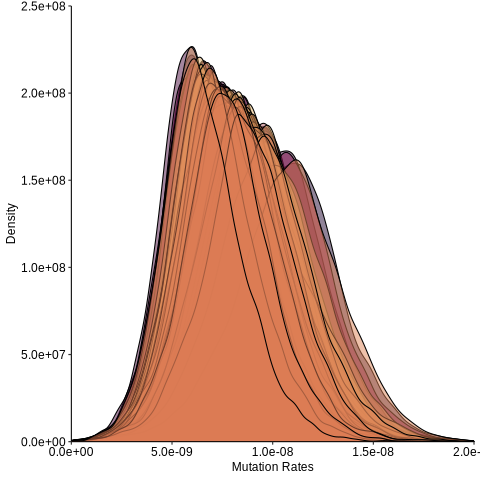

In [75]:
%%R
chosen_colors <- c("#240a34", "#891652", "#eabe6c", "#db7552")

# Generate a palette of 187 colors by interpolating between the chosen colors
interpolated_palette <- colorRampPalette(chosen_colors)(187)

density_of_mutation_rates <- ggplot(mutationrates_long, aes(x = estimated_mutation_rates)) +
  geom_density(aes(fill = SPECIES), alpha = .5) +
  labs(x = "Mutation Rates", y = "Density") +
  ggpubr::theme_pubr() +
  scale_fill_manual(values = interpolated_palette)+
  scale_x_continuous(limits = c(0, 2 * 10^(-8)), expand = c(0, 0)) +
  scale_y_continuous(limits = c(0, 2.5e8), expand = expansion(mult = c(0, 0))) +
  theme(legend.position = 'none')

print(density_of_mutation_rates)


In [76]:
%%R
Nes_long %>% filter(GENUS == 'Pongo')

# A tibble: 20,000 × 5
   pg_name    SPECIES GENUS Ne                                      estimate_nes
   <chr>      <chr>   <chr> <chr>                                          <dbl>
 1 Great_apes abelii  Pongo [77876.7721224243, 54454.249883982324,…          NA 
 2 Great_apes abelii  Pongo [77876.7721224243, 54454.249883982324,…       54454.
 3 Great_apes abelii  Pongo [77876.7721224243, 54454.249883982324,…       94333.
 4 Great_apes abelii  Pongo [77876.7721224243, 54454.249883982324,…       54422.
 5 Great_apes abelii  Pongo [77876.7721224243, 54454.249883982324,…       69695.
 6 Great_apes abelii  Pongo [77876.7721224243, 54454.249883982324,…      138190.
 7 Great_apes abelii  Pongo [77876.7721224243, 54454.249883982324,…       66817.
 8 Great_apes abelii  Pongo [77876.7721224243, 54454.249883982324,…       44525.
 9 Great_apes abelii  Pongo [77876.7721224243, 54454.249883982324,…       66004.
10 Great_apes abelii  Pongo [77876.7721224243, 54454.249883982324,…       71558.
# ℹ 1

### examples of species Ne

In [77]:
%%R
pongo_abelii_ne_density <- Nes_long %>% 
    filter(GENUS == 'Pongo' & SPECIES=='abelii') %>%
    ggplot(aes(x = estimate_nes)) +
    geom_density(fill='#240a34',alpha = 1) +
    labs(x = "Effective population size", y = "Density", title = "", size = 55) +
    ggpubr::theme_pubr() +
    theme(legend.position = 'none')+
    scale_x_continuous(limits = c(20000,20e4), expand = c(0, 0),labels = scales::scientific_format()) +
    scale_y_continuous(expand = expansion(mult = c(0,0)))

In [78]:
%%R 
Macaca_facicularis_ne_density <- Nes_long %>% 
    filter(GENUS=='Macaca' & SPECIES == 'fascicularis')%>%
    ggplot(aes(x = estimate_nes)) +
  geom_density(fill= '#eabe6c',alpha = 1) +
  labs(x = "Effective population size", y = "Density", title = "", size = 55) +
     ggpubr::theme_pubr() +
     theme(legend.position = 'none')+
    scale_x_continuous(limits = c(50e3,3e5), expand = c(0, 0),labels = scales::scientific_format()) +
    scale_y_continuous(expand = expansion(mult = c(0,0)))

In [79]:
%%R 
Eulemur_fulvus_ne_density <-  Nes_long %>% 
    filter(GENUS=='Eulemur' & SPECIES == 'fulvus')%>%
    ggplot(aes(x = estimate_nes)) +
  geom_density(fill= '#db7552',alpha = 1) +
  labs(x = "Effective population size", y = "Density", title = "", size = 55) +
     ggpubr::theme_pubr() +
     theme(legend.position = 'none')+
    scale_x_continuous(limits = c(50e3,4e5), expand = c(0, 0),labels = scales::scientific_format()) +
    scale_y_continuous(expand = expansion(mult = c(0,0)))

In [80]:
%%R 
Pithecia_albicans_ne_density <-  Nes_long %>% 
    filter(GENUS=='Pithecia' & SPECIES == 'albicans')%>%
    ggplot(aes(x = estimate_nes)) +
  geom_density(fill= '#891652',alpha = 1) +
  labs(x = "Effective population size", y = "Density", title = "", size = 55) +
     ggpubr::theme_pubr() +
     theme(legend.position = 'none')+
    scale_x_continuous(limits = c(15e3,1.5e5), expand = c(0, 0),labels = scales::scientific_format()) +
    scale_y_continuous(expand = expansion(mult = c(0,0)))


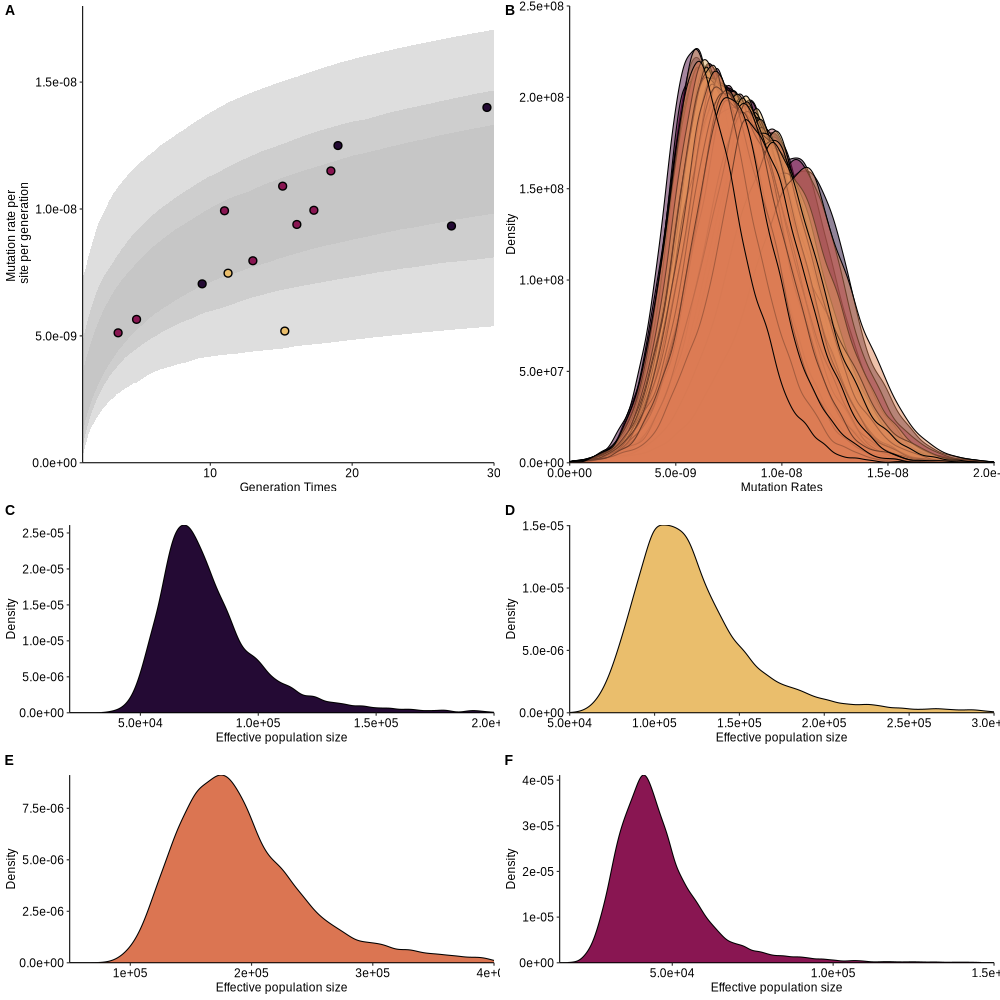

In [81]:
%%R -h 1000 -w 1000
ggarrange(
  ggarrange(
    ne_model_fig, density_of_mutation_rates,
    ncol = 2, labels = c("A", "B")
  ),
  ggarrange(
    pongo_abelii_ne_density, Macaca_facicularis_ne_density, Eulemur_fulvus_ne_density,
      Pithecia_albicans_ne_density,
    ncol = 2, nrow=2, labels = c("C", "D", "E", "F")
  ),
  nrow = 2
)



In [82]:
%%R
text_size <- 20

Modelling_ne_plots <- ggarrange(
  ggarrange(ne_model_fig, density_of_mutation_rates,
             ncol = 2, labels = c("A", "B")) +
    theme(text = element_text(size = text_size, family = "Franklin Gothic Book")) +
    labs(title = ''),
  
  ggarrange(pongo_abelii_ne_density, Macaca_facicularis_ne_density,
            Eulemur_fulvus_ne_density, Pithecia_albicans_ne_density,
            ncol = 2, nrow = 2, labels = c("C", "D", "E", "F")) +
    theme(text = element_text(size = text_size, family = "Franklin Gothic Book")) +
    labs(title = ''),
  
  nrow = 2
)

ggsave("Modelling_ne_plots.svg", Modelling_ne_plots, width = 22, height = 17, units = "cm", dpi = 500)

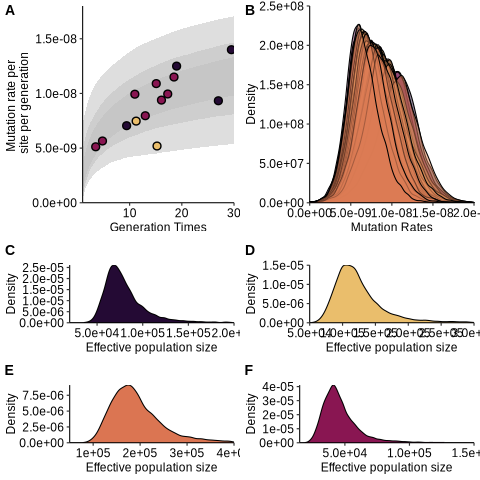

In [83]:
%%R
Modelling_ne_plots

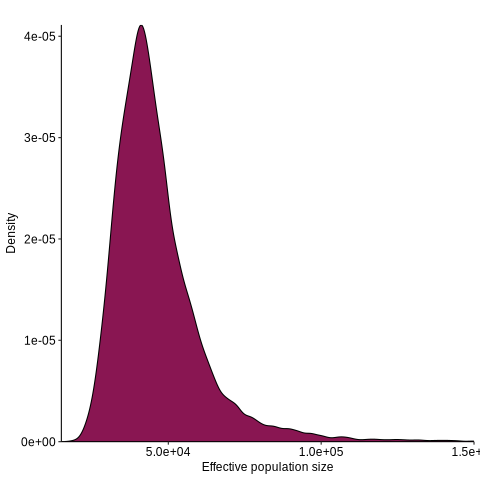

In [84]:
%%R
Pithecia_albicans_ne_density 

# Recombintaion rate and Pi across Species

In [3]:
%%R
df20 <- read_delim('../../results/combined/all.csv', delim=',') %>% group_by(genus,species) %>% mutate(recomb_bin = ntile(cm_per_mb, 20))
pg_namedf <- read_delim('../../data/genus_phylogenetic_group_metadata.txt', delim='\t')
merge_pg_name <- left_join(df20,pg_namedf, by = c('genus'='genus'))
merge_pg_name$pg_name <- as_factor(merge_pg_name$pg_name)
nes <- read_delim('../../results/model/Nested_model/Ne_Pi_recomb.csv', delim = ',') %>% select('genus','species','NE_MEAN','NE_MEDIAN')
nes <- nes %>% 
    group_by(genus,species) %>%
    reframe(
        NE_MEAN = mean(NE_MEAN),
        NE_MEDIAN = mean(NE_MEDIAN))

Rows: 5257244 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): chr, species, genus
dbl (13): start, end, freq_mean, freq_min, freq_max, freq_median, window_siz...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 57 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): genus, pg_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 5071829 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): genus, species, FAMILY, chr
dbl (21): ...1, Unnamed: 0, MEAN, MEDIAN, VARIANCE, NE_MEAN, NE_MEDIAN, NE_V...

ℹ Use `spec()` to retrieve the full column specifi

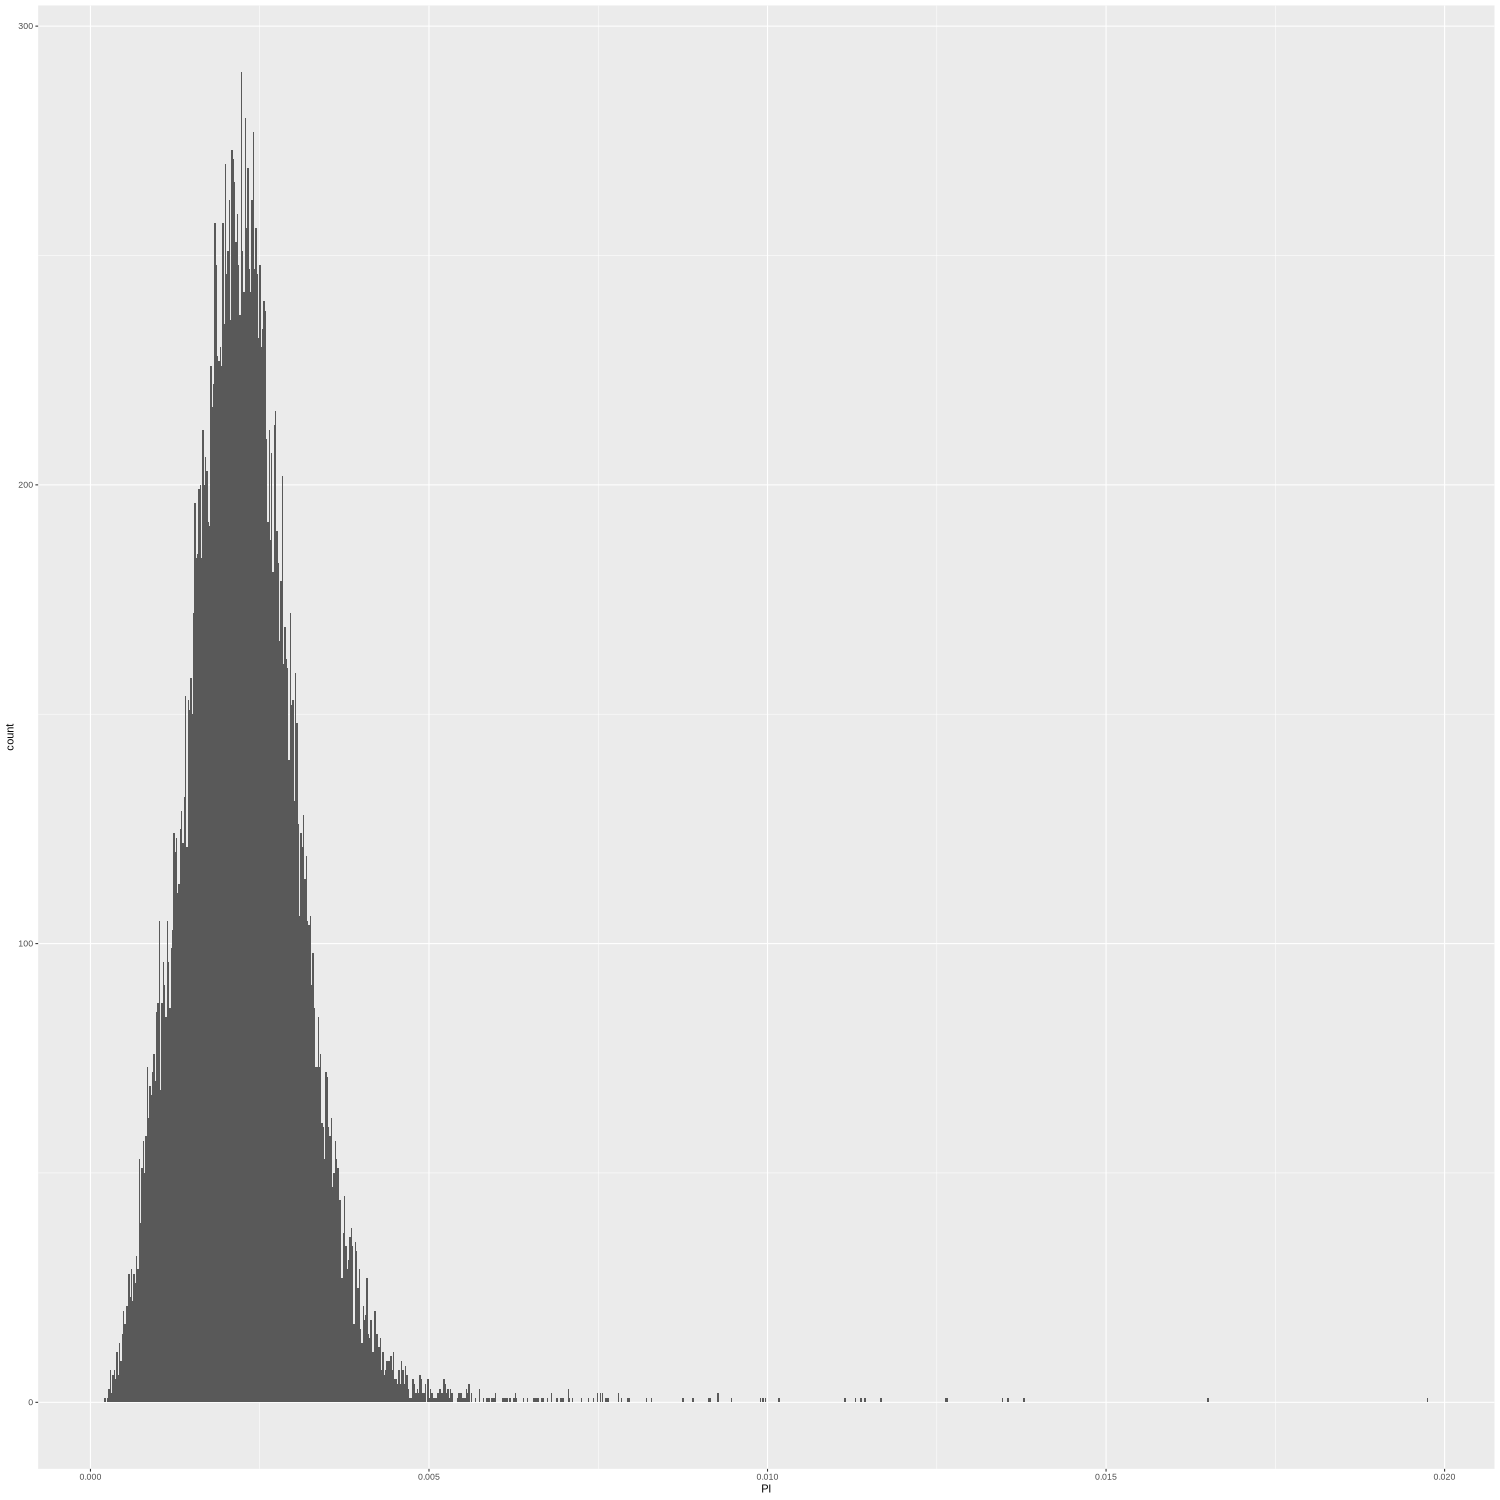

In [13]:
%%R -h 1500 -w 1500
df20 %>% filter(freq_mean > 0.5) %>% 
    filter(!(chr=='chrX')) %>% 
    filter(species == 'gorilla') %>%
    ggplot(aes(x=PI)) +
    geom_histogram(bins=1000) +
    

In [14]:
%%R
tester <- merge_pg_name %>% filter(!(chr=='chrX')) %>% 
    filter(freq_mean > 0.5) %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    group_by(pg_name,genus,species) %>% 
    mutate(
        sd_pi = sd(PI),
        all_mean_pi = mean(PI),
        sd_cm_per_mb = sd(cm_per_mb),
        mean_cm_per_mb = mean(cm_per_mb)
    ) %>%
    group_by(pg_name,genus,species, recomb_bin) %>%
    reframe(
        mean_pi = mean(PI),
        sd_pi_all = mean(sd_pi),
        mean_pi_all = mean(all_mean_pi),
        sd_cm_all = mean(sd_cm_per_mb),
        mean_cm_all = mean(mean_cm_per_mb),
        cm_per_mb = mean(cm_per_mb),
        z_pi = (mean_pi-mean_pi_all)/sd_pi_all,
        z_cm = (cm_per_mb-mean_cm_all)/sd_cm_all
        ) 
    

In [56]:
%%R 

merged_tibble <- left_join(nes,tester, by = c('species' = 'species', 'genus'='genus'))
merged_tibble

# A tibble: 3,702 × 14
   genus          species NE_MEAN NE_MEDIAN pg_name recomb_bin mean_pi sd_pi_all
   <chr>          <chr>     <dbl>     <dbl> <fct>        <int>   <dbl>     <dbl>
 1 Allenopithecus nigrov…  52454.    48795. Old_wo…          1 0.00147   0.00105
 2 Allenopithecus nigrov…  52454.    48795. Old_wo…          2 0.00156   0.00105
 3 Allenopithecus nigrov…  52454.    48795. Old_wo…          3 0.00165   0.00105
 4 Allenopithecus nigrov…  52454.    48795. Old_wo…          4 0.00159   0.00105
 5 Allenopithecus nigrov…  52454.    48795. Old_wo…          5 0.00166   0.00105
 6 Allenopithecus nigrov…  52454.    48795. Old_wo…          6 0.00171   0.00105
 7 Allenopithecus nigrov…  52454.    48795. Old_wo…          7 0.00167   0.00105
 8 Allenopithecus nigrov…  52454.    48795. Old_wo…          8 0.00169   0.00105
 9 Allenopithecus nigrov…  52454.    48795. Old_wo…          9 0.00168   0.00105
10 Allenopithecus nigrov…  52454.    48795. Old_wo…         10 0.00172   0.00105
# ℹ 3

In [57]:
%%R -h 800 -w 800
z_scores_pi <- merged_tibble %>% 
    ggplot(aes(x = z_cm, y = z_pi, group = species, col = log10(NE_MEDIAN)))+
    #geom_point()+
    geom_line(alpha = .4, size =1.5)+
    theme(legend.position = 'none')+
    scale_colour_viridis_c(name = "Effective population size")+
    #scale_color_continuous(name = "Effective population size", low = "#ffff33", high = "#e41a1c",
    #                       breaks = log10(c(10000,30000, 100000, 300000)),
    #                       labels = c('10','30',"100",'300'))+
    labs(x = "Z score of Recombination Rate", y = "Z score of π", title = "", size = 55) +
    ggpubr::theme_pubr() +
    #theme(legend.position = 'none')+
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = expansion(mult = c(0,0)))

In [58]:
%%R -h 800 -w 800
z_scores_pi_log_cm <- merged_tibble %>% 
    ggplot(aes(x = log10(cm_per_mb), y = z_pi, group = species, col = log10(NE_MEDIAN)))+
    geom_point()+
    geom_line(alpha = 2, size =1.5)+
    theme(legend.position = 'none')+
    #scale_colour_viridis_c(name = "Effective population size
    scale_color_continuous(name = "Effective population size", low = "#891652", high = "#eabe6c",
                           breaks = log10(c(10000,30000, 100000, 300000)),
                           labels = c('10','30',"100",'300'))+
    labs(x = "log10 Recombination Rate", y = "Z score of π", title = "", size = 55) +
    ggpubr::theme_pubr() #+
    #theme(legend.position = 'none')+ "#9C964A", "#CDC08C"
   # scale_x_continuous(expand = c(0, 0)) +
    #scale_y_continuous(expand = expansion(mult = c(0,0)))

In [59]:
%%R

example_pi_cm <- merged_tibble %>%  
    filter(genus %in% c('Pongo','Eulemur','Macaca','Pithecia') & species %in% c('abelii','fulvus','fascicularis','albicans')) %>%
    ggplot(aes(x = cm_per_mb, y = mean_pi, col = species)) +
    geom_point() +
    geom_line(alpha = 1, size =1.5)+
    scale_colour_manual(values = c('#240a34','#891652','#eabe6c','#db7552'))+
    labs(x = "Recombination Rate (cM/mb)", y = "Average pairwise differences (π)", title = "", size = 55) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_x_continuous(lim = c(-0.01,4),expand = c(0, 0))
    #scale_y_continuous(lim = c(0.0021,0.00333),expand = expansion(mult = c(0,0)))


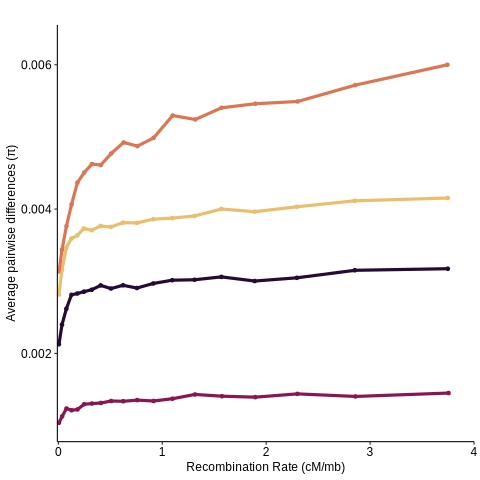

In [91]:
%%R
example_pi_cm

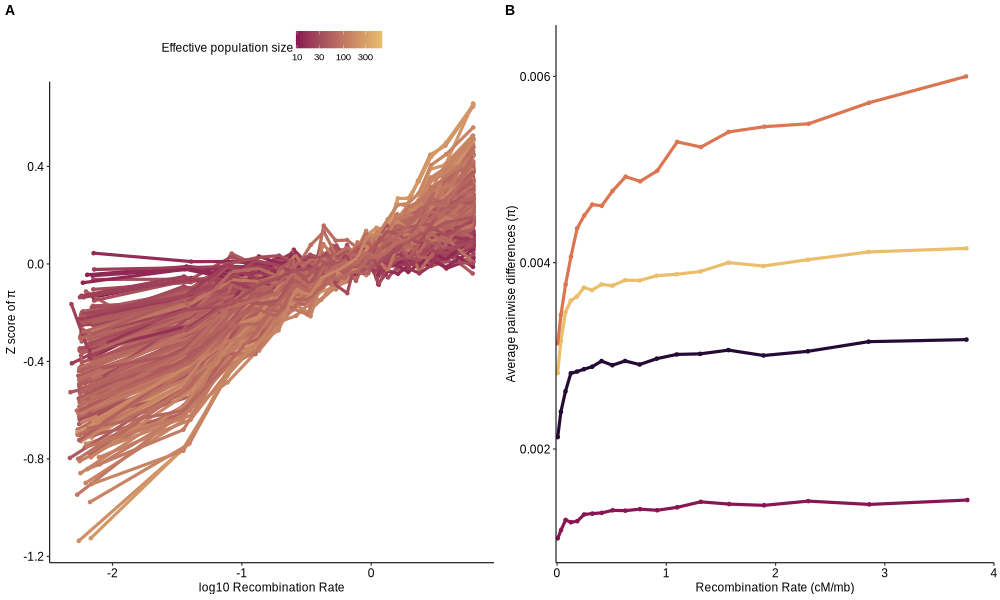

In [92]:
%%R -h 600 -w 1000
ggarrange(z_scores_pi_log_cm, example_pi_cm,
    ncol = 2, labels = c("A", "B"))

# Relative Reduction plot

In [93]:
%%R
diff_df <- merged_tibble %>%
   group_by(pg_name,genus,species, NE_MEDIAN) %>%
    filter(recomb_bin %in% c(1,20)) %>%
   reframe(
     min = min(mean_pi),
     max = max(mean_pi),
     slope_mikkel = (max-min)/max,
     average_pi = mean(mean_pi),
     diff = max-min
   )
diff_df

# A tibble: 185 × 9
   pg_name       genus species NE_MEDIAN     min     max slope_mikkel average_pi
   <fct>         <chr> <chr>       <dbl>   <dbl>   <dbl>        <dbl>      <dbl>
 1 New_world_mo… Alou… belzeb…    54570. 1.61e-3 2.39e-3       0.328    0.00200 
 2 New_world_mo… Alou… caraya     35650. 1.24e-3 1.60e-3       0.227    0.00142 
 3 New_world_mo… Alou… discol…    66639. 1.81e-3 2.90e-3       0.374    0.00235 
 4 New_world_mo… Alou… juara      65093. 1.87e-3 2.69e-3       0.305    0.00228 
 5 New_world_mo… Alou… maccon…    61665. 1.78e-3 2.67e-3       0.333    0.00223 
 6 New_world_mo… Alou… nigerr…    64414. 1.73e-3 2.71e-3       0.363    0.00222 
 7 New_world_mo… Alou… pallia…    12111. 5.02e-4 5.47e-4       0.0820   0.000524
 8 New_world_mo… Alou… puruen…   109115. 3.29e-3 4.72e-3       0.302    0.00400 
 9 New_world_mo… Alou… senicu…    69499. 2.00e-3 2.90e-3       0.310    0.00245 
10 New_world_mo… Aotus azarae     39052. 8.38e-4 1.51e-3       0.444    0.00117 
# ℹ 175 

In [94]:
%%R
relative_reduction <- diff_df %>%
    ggplot(aes(x=log10(NE_MEDIAN),y=(slope_mikkel)))+
    geom_point(aes(fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    ggpubr::theme_pubr(legend = 'none')+
    scale_fill_manual(values=c('#FAD77B','#F4B5BD','#CDC08C','#85D4E3')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')+
    scale_x_continuous(lim = c(4,5.6),expand = c(0, 0))+
    scale_y_continuous(lim = c(0,0.7), expand = expansion(mult = c(0,0)))



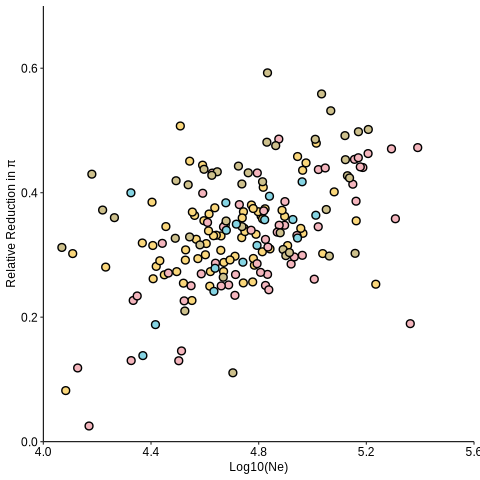

In [95]:
%%R
relative_reduction

# MODEL RELATIVE REDUCTION AS FUNCTION OF NE

In [4]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr
import random
import os

In [5]:
diff_df = pd.read_csv('../../results/model/relative_reduction/relative_reduction_df.csv')

In [6]:
diff_df

Unnamed: 0            pg_name     genus      species     NE_MEDIAN  \
0             1  New_world_monkeys  Alouatta     belzebul  54569.554211   
1             2  New_world_monkeys  Alouatta       caraya  35650.206996   
2             3  New_world_monkeys  Alouatta     discolor  66639.120968   
3             4  New_world_monkeys  Alouatta        juara  65093.401581   
4             5  New_world_monkeys  Alouatta  macconnelli  61665.264564   
..          ...                ...       ...          ...           ...   
180         181         Great_apes  Nomascus         siki  62213.451425   
181         182         Great_apes       Pan     paniscus  23430.014527   
182         183         Great_apes       Pan  troglodytes  43031.587150   
183         184         Great_apes     Pongo       abelii  66407.312143   
184         185         Great_apes     Pongo     pygmaeus  47845.966471   

          min       max  slope_mikkel  average_pi      diff  
0    0.001607  0.002391      0.327757    0.001999  0.000784  
1    0.001239  0.001603      0.226755    0.001421  0.000363  
2    0.001813  0.002897      0.374163    0.002355  0.001084  
3    0.001867  0.002686      0.305079    0.002277  0.000820  
4    0.001782  0.002672      0.333182    0.002227  0.000890  
..        ...       ...           ...         ...       ...  
180  0.001798  0.002626      0.315328    0.002212  0.000828  
181  0.001054  0.001223      0.138265    0.001139  0.000169  
182  0.001854  0.002444      0.241483    0.002149  0.000590  
183  0.002127  0.003306      0.356502    0.002716  0.001178  
184  0.001522  0.002304      0.339617    0.001913  0.000783  

[185 rows x 10 columns]

In [242]:
relative_reduction_model = pm.Model()
with relative_reduction_model:
# Data
    Ne = pm.ConstantData('log10NE', np.log10(diff_df['NE_MEDIAN']))
    rr = pm.ConstantData('rr', diff_df['slope_mikkel'])

    sigma = pm.Exponential("sigma", 0.1)
    alpha = pm.Normal("alpha", 0, sigma=0.1)
    beta = pm.Normal("beta", 0, sigma=0.1)

    # Define likelihood
    likelihood = pm.Normal("relative_reduction", mu=alpha + beta * Ne, sigma=sigma, observed=rr)



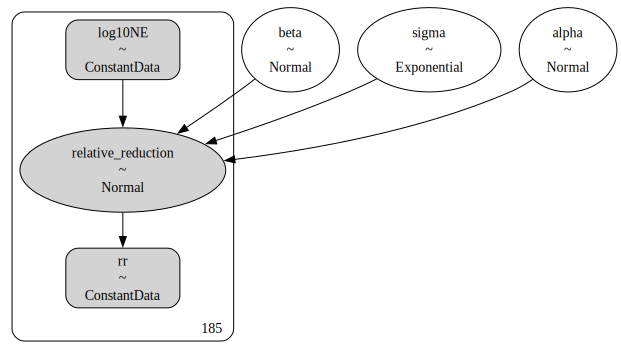

In [243]:
pm.model_to_graphviz(relative_reduction_model)

In [244]:
with relative_reduction_model:
    idata = pm.sample_prior_predictive(samples=100)

Sampling: [alpha, beta, relative_reduction, sigma]


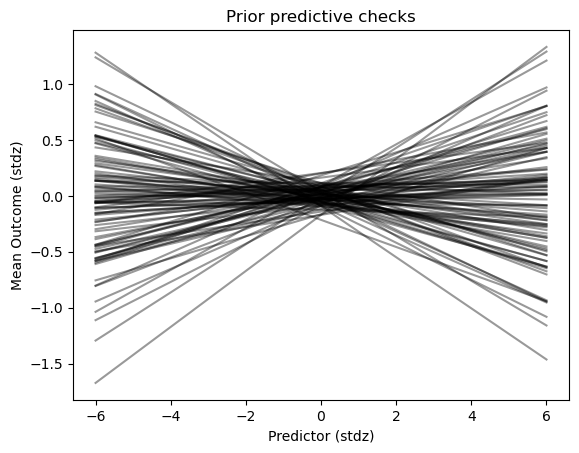

In [245]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-6, 6, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["alpha"] + prior["beta"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks");

In [246]:
 with relative_reduction_model:
       relative_reduction_model_idata = pm.sample(2000, target_accept=0.95, return_inferencedata=True,
                                 progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


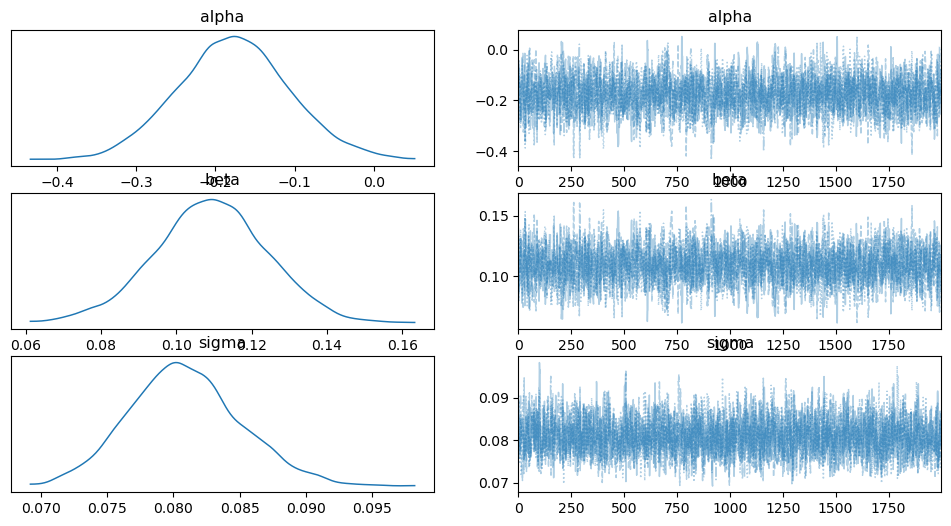

In [247]:
az.plot_trace(relative_reduction_model_idata, combined=True);

In [248]:
a = relative_reduction_model_idata.posterior.alpha.to_dataframe()
a.to_csv("../../results/model/relative_reduction/a_3_04_2024", sep="\t")
b = relative_reduction_model_idata.posterior.beta.to_dataframe()
b.to_csv("../../results/model/relative_reduction/b_3_04_2024", sep="\t")

In [12]:
%%R 
# (-i a -i b)

a <- read_delim("../../results/model/relative_reduction/a_3_04_2024", delim="\t")
b <- read_delim("../../results/model/relative_reduction/b_3_04_2024", delim = "\t")
           

# Use the function
x_values <- c()
lower_bounds <- c()
upper_bounds <- c()


for (i in log10(diff_df$NE_MEDIAN)) {
    cred_int <- credibility_interval(i, b$beta, a$alpha)
    x_values <- c(x_values, i)
    lower_bounds <- c(lower_bounds, cred_int[1])
    upper_bounds <- c(upper_bounds, cred_int[2])
}

# Create a data frame
mean_reg_line <- data.frame(
    x = x_values,
    lower_bound = lower_bounds,
    upper_bound = upper_bounds
)

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [18]:
%%R
# HDPI for Beta
sample1 <- sample(b$beta,1000, rep = TRUE)
quantile(sample1,c(0.025,0.5,0.975))

      2.5%        50%      97.5% 
0.07544188 0.10910423 0.13868915 


In [9]:
%%R -i diff_df
head(diff_df)

  Unnamed: 0           pg_name    genus     species NE_MEDIAN         min
0          1 New_world_monkeys Alouatta    belzebul  54569.55 0.001607075
1          2 New_world_monkeys Alouatta      caraya  35650.21 0.001239415
2          3 New_world_monkeys Alouatta    discolor  66639.12 0.001812968
3          4 New_world_monkeys Alouatta       juara  65093.40 0.001866872
4          5 New_world_monkeys Alouatta macconnelli  61665.26 0.001782060
5          6 New_world_monkeys Alouatta   nigerrima  64413.65 0.001729485
          max slope_mikkel  average_pi         diff
0 0.002390618    0.3277573 0.001998846 0.0007835424
1 0.001602875    0.2267549 0.001421145 0.0003634597
2 0.002896868    0.3741627 0.002354918 0.0010838999
3 0.002686452    0.3050790 0.002276662 0.0008195800
4 0.002672485    0.3331825 0.002227272 0.0008904250
5 0.002713583    0.3626566 0.002221534 0.0009840988


# Relative reduction


In [20]:
%%R
min_diff <- min(diff_df$slope_mikkel)
max_diff <- max(diff_df$slope_mikkel)
median <- median(diff_df$slope_mikkel)
c(min_diff,max_diff,median)


[1] 0.02514376 0.59255504 0.33754297


In [122]:
%%R

model_relative_reduction <- ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(diff_df$NE_MEDIAN), y=(mean(a$alpha))+(mean(b$beta)*log10(diff_df$NE_MEDIAN))), lty = 2, size =2)+
    geom_point(data = diff_df, aes(x=log10(NE_MEDIAN),y=slope_mikkel, fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#891652','#eabe6c','#db7552','#240a34')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')+
    scale_x_continuous(lim = c(4,5.6),expand = c(0, 0))+
    scale_y_continuous(lim = c(0,0.7), expand = expansion(mult = c(0,0)))

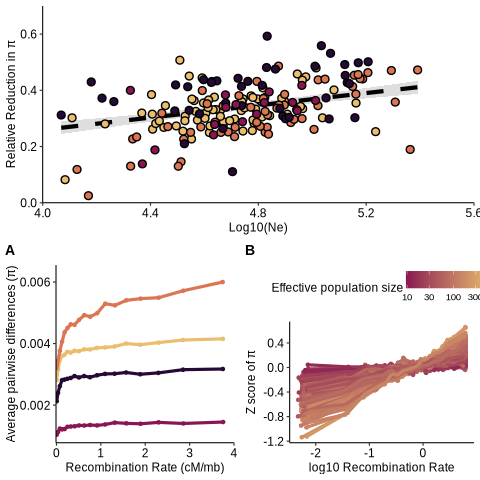

In [123]:
%%R
ggarrange(
  model_relative_reduction,
  ggarrange(example_pi_cm, z_scores_pi_log_cm,
            ncol = 2, labels = c("A", "B")),
  nrow = 2
)

In [101]:
%%R
# Set common text size and font family
text_size <- 20
font_family <- "Franklin Gothic Book"

# Arrange the plots with common text size and font
Relative_Reduction <- ggarrange(
  model_relative_reduction +
    theme(text = element_text(size = text_size, family = font_family)),
  
  ggarrange(example_pi_cm, z_scores_pi_log_cm,
            ncol = 2, labels = c("B", "C")) +
    theme(text = element_text(size = text_size, family = font_family)),
  
  nrow = 2,
    labels=c('A')
)

# Save the arranged plots with specified dimensions
ggsave("Relative_Reduction.svg", Relative_Reduction, width = 30, height = 24, units = "cm", dpi = 500)


In [23]:
%%R
plot_size <- list(width = 30, height = 25)

# Adjust text size
text_size <- 20

# Arrange the plots
Relative_reduction_all_plots <- ggarrange(
  model_relative_reduction,
  ggarrange(example_pi_cm, z_scores_pi_log_cm,
            ncol = 2, labels = c("B", "C")),
  nrow = 2, labels = 'A'
)

# Modify plot size
ggsave("Relative_reduction_all_plots.svg", Relative_reduction_all_plots, width = plot_size$width, height = plot_size$height)


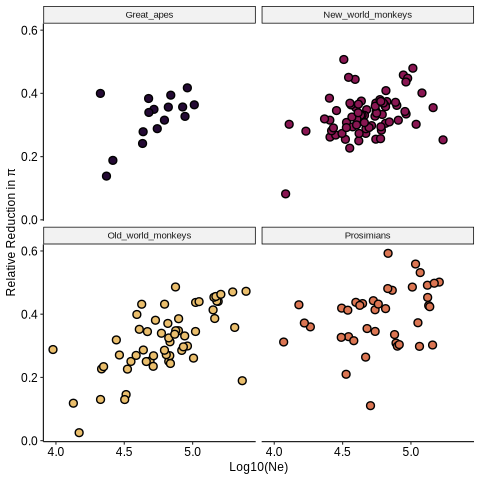

In [24]:
%%R
ggplot(data = diff_df, aes(x=log10(NE_MEDIAN),y=slope_mikkel, fill=pg_name)) +
geom_point(color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
scale_fill_manual(values=c('#240a34','#891652','#eabe6c','#db7552')) +
ggpubr::theme_pubr(legend = 'none')+
ylab("Relative Reduction in π")+
xlab('Log10(Ne)')+
facet_wrap(pg_name~.)

# PYMC model per pg_group

In [14]:
diff_df

Unnamed: 0            pg_name     genus      species     NE_MEDIAN  \
0             1  New_world_monkeys  Alouatta     belzebul  54569.554211   
1             2  New_world_monkeys  Alouatta       caraya  35650.206996   
2             3  New_world_monkeys  Alouatta     discolor  66639.120968   
3             4  New_world_monkeys  Alouatta        juara  65093.401581   
4             5  New_world_monkeys  Alouatta  macconnelli  61665.264564   
..          ...                ...       ...          ...           ...   
180         181         Great_apes  Nomascus         siki  62213.451425   
181         182         Great_apes       Pan     paniscus  23430.014527   
182         183         Great_apes       Pan  troglodytes  43031.587150   
183         184         Great_apes     Pongo       abelii  66407.312143   
184         185         Great_apes     Pongo     pygmaeus  47845.966471   

          min       max  slope_mikkel  average_pi      diff  
0    0.001607  0.002391      0.327757    0.001999  0.000784  
1    0.001239  0.001603      0.226755    0.001421  0.000363  
2    0.001813  0.002897      0.374163    0.002355  0.001084  
3    0.001867  0.002686      0.305079    0.002277  0.000820  
4    0.001782  0.002672      0.333182    0.002227  0.000890  
..        ...       ...           ...         ...       ...  
180  0.001798  0.002626      0.315328    0.002212  0.000828  
181  0.001054  0.001223      0.138265    0.001139  0.000169  
182  0.001854  0.002444      0.241483    0.002149  0.000590  
183  0.002127  0.003306      0.356502    0.002716  0.001178  
184  0.001522  0.002304      0.339617    0.001913  0.000783  

[185 rows x 10 columns]

In [267]:

group_idx, groups = pd.factorize(diff_df["pg_name"], sort=True)
diff_df['pg_idx'] = group_idx
diff_df

Unnamed: 0            pg_name     genus      species     NE_MEDIAN  \
0             1  New_world_monkeys  Alouatta     belzebul  54569.554211   
1             2  New_world_monkeys  Alouatta       caraya  35650.206996   
2             3  New_world_monkeys  Alouatta     discolor  66639.120968   
3             4  New_world_monkeys  Alouatta        juara  65093.401581   
4             5  New_world_monkeys  Alouatta  macconnelli  61665.264564   
..          ...                ...       ...          ...           ...   
180         181         Great_apes  Nomascus         siki  62213.451425   
181         182         Great_apes       Pan     paniscus  23430.014527   
182         183         Great_apes       Pan  troglodytes  43031.587150   
183         184         Great_apes     Pongo       abelii  66407.312143   
184         185         Great_apes     Pongo     pygmaeus  47845.966471   

          min       max  slope_mikkel  average_pi      diff  pg_idx  
0    0.001607  0.002391      0.327757    0.001999  0.000784       1  
1    0.001239  0.001603      0.226755    0.001421  0.000363       1  
2    0.001813  0.002897      0.374163    0.002355  0.001084       1  
3    0.001867  0.002686      0.305079    0.002277  0.000820       1  
4    0.001782  0.002672      0.333182    0.002227  0.000890       1  
..        ...       ...           ...         ...       ...     ...  
180  0.001798  0.002626      0.315328    0.002212  0.000828       0  
181  0.001054  0.001223      0.138265    0.001139  0.000169       0  
182  0.001854  0.002444      0.241483    0.002149  0.000590       0  
183  0.002127  0.003306      0.356502    0.002716  0.001178       0  
184  0.001522  0.002304      0.339617    0.001913  0.000783       0  

[185 rows x 11 columns]

### great apes

In [272]:
great_apes = diff_df[diff_df['pg_name']=='Great_apes']

Unnamed: 0     pg_name      genus      species      NE_MEDIAN       min  \
169         170  Great_apes    Gorilla     beringei   21151.485950  0.000716   
170         171  Great_apes    Gorilla      gorilla   47639.660778  0.001578   
171         172  Great_apes    Hoolock      hoolock   26092.232431  0.000899   
172         173  Great_apes  Hylobates      abbotti  102866.301991  0.002799   
173         174  Great_apes  Hylobates       agilis   84538.710414  0.002333   
174         175  Great_apes  Hylobates      klossii   43444.409635  0.001382   
175         176  Great_apes  Hylobates          lar   91504.005001  0.002313   
176         177  Great_apes  Hylobates     muelleri   87965.119442  0.002534   
177         178  Great_apes   Nomascus   annamensis   69198.992665  0.001776   
178         179  Great_apes   Nomascus     concolor   55119.772144  0.001716   
179         180  Great_apes   Nomascus   gabriellae   52125.177417  0.001422   
180         181  Great_apes   Nomascus         siki   62213.451425  0.001798   
181         182  Great_apes        Pan     paniscus   23430.014527  0.001054   
182         183  Great_apes        Pan  troglodytes   43031.587150  0.001854   
183         184  Great_apes      Pongo       abelii   66407.312143  0.002127   
184         185  Great_apes      Pongo     pygmaeus   47845.966471  0.001522   

          max  slope_mikkel  average_pi      diff  pg_idx  
169  0.001192      0.399853    0.000954  0.000477       0  
170  0.002561      0.383768    0.002069  0.000983       0  
171  0.001107      0.188012    0.001003  0.000208       0  
172  0.004399      0.363776    0.003599  0.001600       0  
173  0.003628      0.356934    0.002980  0.001295       0  
174  0.001916      0.278594    0.001649  0.000534       0  
175  0.003972      0.417511    0.003143  0.001658       0  
176  0.003765      0.327159    0.003149  0.001232       0  
177  0.002933      0.394318    0.002355  0.001157       0  
178  0.002411      0.288309    0.002063  0.000695       0  
179  0.002185      0.349460    0.001803  0.000764       0  
180  0.002626      0.315328    0.002212  0.000828       0  
181  0.001223      0.138265    0.001139  0.000169       0  
182  0.002444      0.241483    0.002149  0.000590       0  
183  0.003306      0.356502    0.002716  0.001178       0  
184  0.002304      0.339617    0.001913  0.000783       0

In [274]:
relative_reduction_great_apes_model = pm.Model()

with relative_reduction_great_apes_model:
# Data
    Ne = pm.ConstantData('log10NE', np.log10(great_apes['NE_MEDIAN']))
    rr = pm.ConstantData('rr', great_apes['slope_mikkel'])

    sigma = pm.Exponential("sigma", 0.1)
    alpha = pm.Normal("alpha", 0, sigma=0.1)
    beta = pm.Normal("beta", 0, sigma=0.1)

    # Define likelihood
    likelihood = pm.Normal("relative_reduction", mu=alpha + beta * Ne, sigma=sigma, observed=rr)

In [275]:
with relative_reduction_great_apes_model:
    relative_reduction_great_apes_model_idata = pm.sample_prior_predictive(samples=100)

Sampling: [alpha, beta, relative_reduction, sigma]


In [277]:
 with relative_reduction_great_apes_model:
       relative_reduction_great_apes_model_idata = pm.sample(2000, target_accept=0.95, return_inferencedata=True,
                                 progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


In [279]:
a = relative_reduction_great_apes_model_idata.posterior.alpha.to_dataframe()
a.to_csv("../../results/model/relative_reduction/a_great_apes_3_04_2024", sep="\t")
b = relative_reduction_great_apes_model_idata.posterior.beta.to_dataframe()
b.to_csv("../../results/model/relative_reduction/b_great_apes_3_04_2024", sep="\t")

In [19]:
%%R
apesb <- read_delim("../../results/model/relative_reduction/b_great_apes_3_04_2024", delim="\t") 
sample1 <- sample(apesb$beta,1000, rep = TRUE)
quantile(sample1,c(0.025,0.5,0.975))

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
      2.5%        50%      97.5% 
0.02832543 0.07272077 0.11104845 


### new world

In [281]:
New_world = diff_df[diff_df['pg_name']=='New_world_monkeys']

In [282]:
relative_reduction_New_world_model = pm.Model()

with relative_reduction_New_world_model:
# Data
    Ne = pm.ConstantData('log10NE', np.log10(New_world['NE_MEDIAN']))
    rr = pm.ConstantData('rr', New_world['slope_mikkel'])

    sigma = pm.Exponential("sigma", 0.1)
    alpha = pm.Normal("alpha", 0, sigma=0.1)
    beta = pm.Normal("beta", 0, sigma=0.1)

    # Define likelihood
    likelihood = pm.Normal("relative_reduction", mu=alpha + beta * Ne, sigma=sigma, observed=rr)

In [283]:
 with relative_reduction_New_world_model:
       relative_reduction_New_world_model_idata = pm.sample(2000, target_accept=0.95, return_inferencedata=True,
                                 progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


In [284]:
a = relative_reduction_New_world_model_idata.posterior.alpha.to_dataframe()
a.to_csv("../../results/model/relative_reduction/a_new_world_3_04_2024", sep="\t")
b = relative_reduction_New_world_model_idata.posterior.beta.to_dataframe()
b.to_csv("../../results/model/relative_reduction/b_new_world_3_04_2024", sep="\t")

In [20]:
%%R
newb <- read_delim("../../results/model/relative_reduction/b_new_world_3_04_2024", delim="\t") 
sample1 <- sample(newb$beta,1000, rep = TRUE)
quantile(sample1,c(0.025,0.5,0.975))

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
      2.5%        50%      97.5% 
0.04643281 0.08058714 0.11475496 


### old world 

In [290]:
Old_world = diff_df[diff_df['pg_name']=='Old_world_monkeys']
relative_reduction_Old_world_model = pm.Model()

In [291]:
with relative_reduction_Old_world_model:
# Data
    Ne = pm.ConstantData('log10NE', np.log10(Old_world['NE_MEDIAN']))
    rr = pm.ConstantData('rr', Old_world['slope_mikkel'])

    sigma = pm.Exponential("sigma", 0.1)
    alpha = pm.Normal("alpha", 0, sigma=0.1)
    beta = pm.Normal("beta", 0, sigma=0.1)

    # Define likelihood
    likelihood = pm.Normal("relative_reduction", mu=alpha + beta * Ne, sigma=sigma, observed=rr)

In [292]:
 with relative_reduction_Old_world_model:
       relative_reduction_Old_world_model_idata = pm.sample(2000, target_accept=0.95, return_inferencedata=True,
                                 progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


In [293]:
a = relative_reduction_Old_world_model_idata.posterior.alpha.to_dataframe()
a.to_csv("../../results/model/relative_reduction/a_old_world_3_04_2024", sep="\t")
b = relative_reduction_Old_world_model_idata.posterior.beta.to_dataframe()
b.to_csv("../../results/model/relative_reduction/b_old_world_3_04_2024", sep="\t")

In [21]:
%%R
oldb <- read_delim("../../results/model/relative_reduction/b_old_world_3_04_2024", delim="\t") 
sample1 <- sample(oldb$beta,1000, rep = TRUE)
quantile(sample1,c(0.025,0.5,0.975))

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
      2.5%        50%      97.5% 
0.06277153 0.09872029 0.13511928 


### Prosimians

In [296]:
prosimians = diff_df[diff_df['pg_name']=='Prosimians']
relative_reduction_prosimians_model = pm.Model()

In [297]:
with relative_reduction_prosimians_model:
# Data
    Ne = pm.ConstantData('log10NE', np.log10(prosimians['NE_MEDIAN']))
    rr = pm.ConstantData('rr', prosimians['slope_mikkel'])

    sigma = pm.Exponential("sigma", 0.1)
    alpha = pm.Normal("alpha", 0, sigma=0.1)
    beta = pm.Normal("beta", 0, sigma=0.1)

    # Define likelihood
    likelihood = pm.Normal("relative_reduction", mu=alpha + beta * Ne, sigma=sigma, observed=rr)

In [298]:
 with relative_reduction_prosimians_model:
       relative_reduction_prosimians_model_idata = pm.sample(2000, target_accept=0.95, return_inferencedata=True,
                                 progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


In [299]:
a = relative_reduction_prosimians_model_idata.posterior.alpha.to_dataframe()
a.to_csv("../../results/model/relative_reduction/a_prosimians_3_04_2024", sep="\t")
b = relative_reduction_prosimians_model_idata.posterior.beta.to_dataframe()
b.to_csv("../../results/model/relative_reduction/b_prosimians_3_04_2024", sep="\t")

In [22]:
%%R
prosib <- read_delim("../../results/model/relative_reduction/b_prosimians_3_04_2024", delim="\t") 
sample1 <- sample(prosib$beta,1000, rep = TRUE)
quantile(sample1,c(0.025,0.5,0.975))

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
      2.5%        50%      97.5% 
0.04387843 0.08441774 0.11911030 


Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


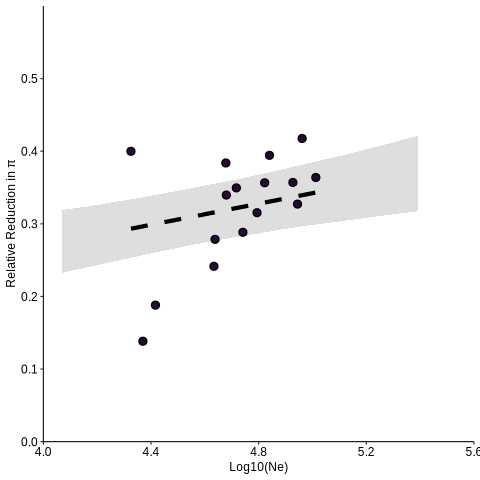

In [105]:
%%R
## great apes
alpha_great <- read_delim('../../results/model/relative_reduction/a_great_apes_3_04_2024', delim = '\t')
beta_great <- read_delim('../../results/model/relative_reduction/b_great_apes_3_04_2024', delim = '\t')
           
# Use the function
x_values_g <- c()
lower_bounds_g <- c()
upper_bounds_g <- c()

# Calculate the credibility intervals for each x value


for (i in log10(diff_df$NE_MEDIAN)) {
    cred_int <- credibility_interval(i, beta_great$beta, alpha_great$alpha)
    x_values_g <- c(x_values_g, i)
    lower_bounds_g <- c(lower_bounds_g, cred_int[1])
    upper_bounds_g <- c(upper_bounds_g, cred_int[2])
}

# Create a data frame
mean_reg_line_g <- data.frame(
    x = x_values_g,
    lower_bound = lower_bounds_g,
    upper_bound = upper_bounds_g
)

great_apes_rr <- diff_df %>%
    filter(pg_name == 'Great_apes') %>%
    ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line_g, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(NE_MEDIAN), y=(mean(alpha_great$alpha))+(mean(beta_great$beta)*log10(NE_MEDIAN))), lty = 2, size =2)+

    geom_point(aes(x=log10(NE_MEDIAN),y=slope_mikkel, fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#240a34')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')+
    scale_x_continuous(expand = c(0, 0),lim = c(4,5.6))+
    scale_y_continuous(expand = expansion(mult = c(0,0)),lim = c(0,0.6))
print(great_apes_rr)

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


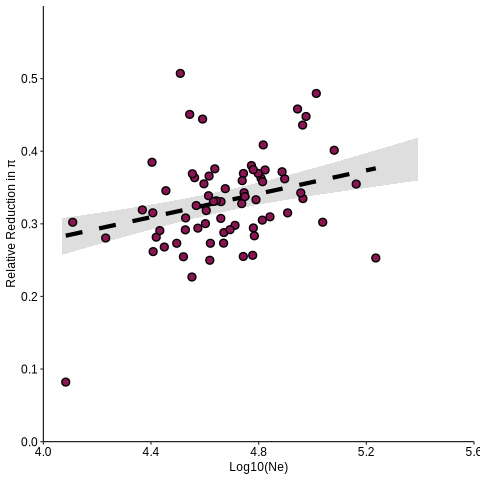

In [106]:
%%R
## new world monkeys
alpha_new <- read_delim('../../results/model/relative_reduction/a_new_world_3_04_2024', delim = '\t')
beta_new <- read_delim('../../results/model/relative_reduction/b_new_world_3_04_2024', delim = '\t')
           
# Use the function
x_values_n <- c()
lower_bounds_n <- c()
upper_bounds_n <- c()

# Calculate the credibility intervals for each x value


for (i in log10(diff_df$NE_MEDIAN)) {
    cred_int <- credibility_interval(i, beta_new$beta, alpha_new$alpha)
    x_values_n <- c(x_values_n, i)
    lower_bounds_n <- c(lower_bounds_n, cred_int[1])
    upper_bounds_n <- c(upper_bounds_n, cred_int[2])
}

# Create a data frame
mean_reg_line_n <- data.frame(
    x = x_values_n,
    lower_bound = lower_bounds_n,
    upper_bound = upper_bounds_n
)


new_wolrd_rr <- diff_df %>%
    filter(pg_name == 'New_world_monkeys') %>%
    ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line_n, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(NE_MEDIAN), y=(mean(alpha_new$alpha))+(mean(beta_new$beta)*log10(NE_MEDIAN))), lty = 2, size =2)+
    geom_point(aes(x=log10(NE_MEDIAN),y=slope_mikkel, fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#891652')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')+
    scale_x_continuous(expand = c(0, 0),lim = c(4,5.6))+
    scale_y_continuous(expand = expansion(mult = c(0,0)),lim= c(0,0.6))
print(new_wolrd_rr)

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


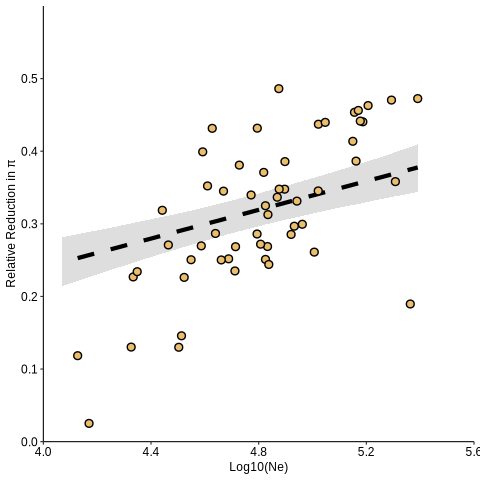

In [107]:
%%R
## new world monkeys
alpha_old <- read_delim('../../results/model/relative_reduction/a_old_world_3_04_2024', delim = '\t')
beta_old <- read_delim('../../results/model/relative_reduction/b_old_world_3_04_2024', delim = '\t')
           
# Use the function
x_values_o <- c()
lower_bounds_o <- c()
upper_bounds_o <- c()

# Calculate the credibility intervals for each x value


for (i in log10(diff_df$NE_MEDIAN)) {
    cred_int <- credibility_interval(i, beta_old$beta, alpha_old$alpha)
    x_values_o <- c(x_values_o, i)
    lower_bounds_o <- c(lower_bounds_o, cred_int[1])
    upper_bounds_o <- c(upper_bounds_o, cred_int[2])
}

# Create a data frame
mean_reg_line_o <- data.frame(
    x = x_values_o,
    lower_bound = lower_bounds_o,
    upper_bound = upper_bounds_o
)

old_world_rr <- diff_df %>%
    filter(pg_name == 'Old_world_monkeys') %>%
    ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line_o, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(NE_MEDIAN), y=(mean(alpha_old$alpha))+(mean(beta_old$beta)*log10(NE_MEDIAN))), lty = 2, size =2)+

    geom_point(aes(x=log10(NE_MEDIAN),y=slope_mikkel, fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#eabe6c')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')+
    scale_x_continuous(expand = c(0, 0), lim = c(4,5.6))+
    scale_y_continuous(expand = expansion(mult = c(0,0)),lim = c(0,0.6))
print(old_world_rr)

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


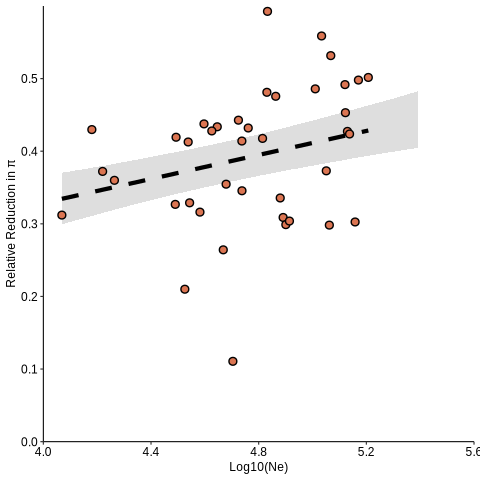

In [108]:
%%R
## new world monkeys
alpha_prosimians<- read_delim('../../results/model/relative_reduction/a_prosimians_3_04_2024', delim = '\t')
beta_prosimians <- read_delim('../../results/model/relative_reduction/b_prosimians_3_04_2024', delim = '\t')
           

# Use the function
x_values_p <- c()
lower_bounds_p <- c()
upper_bounds_p <- c()

# Calculate the credibility intervals for each x value
#p <- diff_df %>%
#    filter(pg_name == 'Prosimians')

for (i in log10(diff_df$NE_MEDIAN)) {
    cred_int <- credibility_interval(i, beta_prosimians$beta, alpha_prosimians$alpha)
    x_values_p <- c(x_values_p, i)
    lower_bounds_p <- c(lower_bounds_p, cred_int[1])
    upper_bounds_p <- c(upper_bounds_p, cred_int[2])
}

# Create a data frame
mean_reg_line_p <- data.frame(
    x = x_values_p,
    lower_bound = lower_bounds_p,
    upper_bound = upper_bounds_p
)

prosimians_rr <- diff_df %>%
    filter(pg_name == 'Prosimians') %>%
    ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line_p, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(NE_MEDIAN), y=(mean(alpha_prosimians$alpha))+(mean(beta_prosimians$beta)*log10(NE_MEDIAN))), lty = 2, size =2)+
    geom_point(aes(x=log10(NE_MEDIAN),y=slope_mikkel, fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#db7552')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')+
    scale_x_continuous(expand = c(0, 0),lim = c(4,5.6))+
    scale_y_continuous(expand = expansion(mult = c(0,0)),lim = c(0.0,0.6))
print(prosimians_rr)

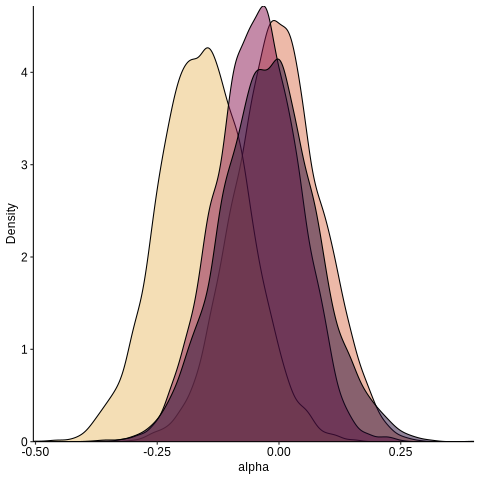

In [109]:
%%R
rr_alphas <- ggplot()+
    geom_density(data=alpha_prosimians, aes(x = alpha), fill = '#db7552', alpha = .5)+
    geom_density(data=alpha_old, aes(x = alpha), fill = '#eabe6c',alpha = .5 )+
    geom_density(data=alpha_new, aes(x = alpha), fill = '#891652',alpha = .5 )+
    geom_density(data=alpha_great, aes(x = alpha), fill = '#240a34' ,alpha = .5)+
    scale_x_continuous(expand = c(0, 0))+
    scale_y_continuous(expand = expansion(mult = c(0,0)))+
    ggpubr::theme_pubr(legend = 'none')+
    ylab("Density")+
    xlab('alpha')
print(rr_alphas)

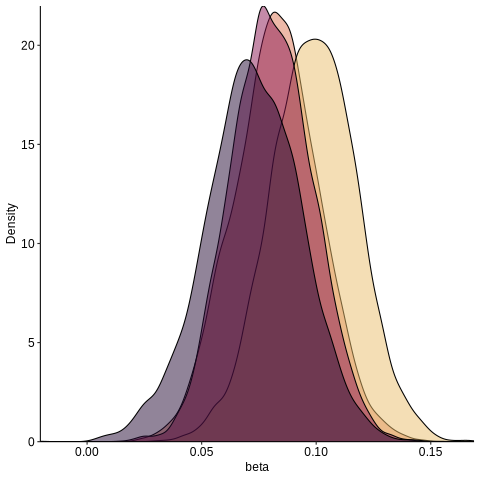

In [110]:
%%R
rr_betas <- ggplot()+
    geom_density(data=beta_prosimians, aes(x = beta), fill = '#db7552', alpha = .5)+
    geom_density(data=beta_old, aes(x = beta), fill = '#eabe6c', alpha = .5)+
    geom_density(data=beta_new, aes(x = beta), fill = '#891652', alpha = .5)+
    geom_density(data=beta_great, aes(x = beta), fill = '#240a34', alpha = .5)+
    scale_x_continuous(expand = c(0, 0))+
    scale_y_continuous(expand = expansion(mult = c(0,0)))+
    ggpubr::theme_pubr(legend = 'none')+
    ylab("Density")+
    xlab('beta')
print(rr_betas)

R[write to console]: Picking joint bandwidth of 0.00284



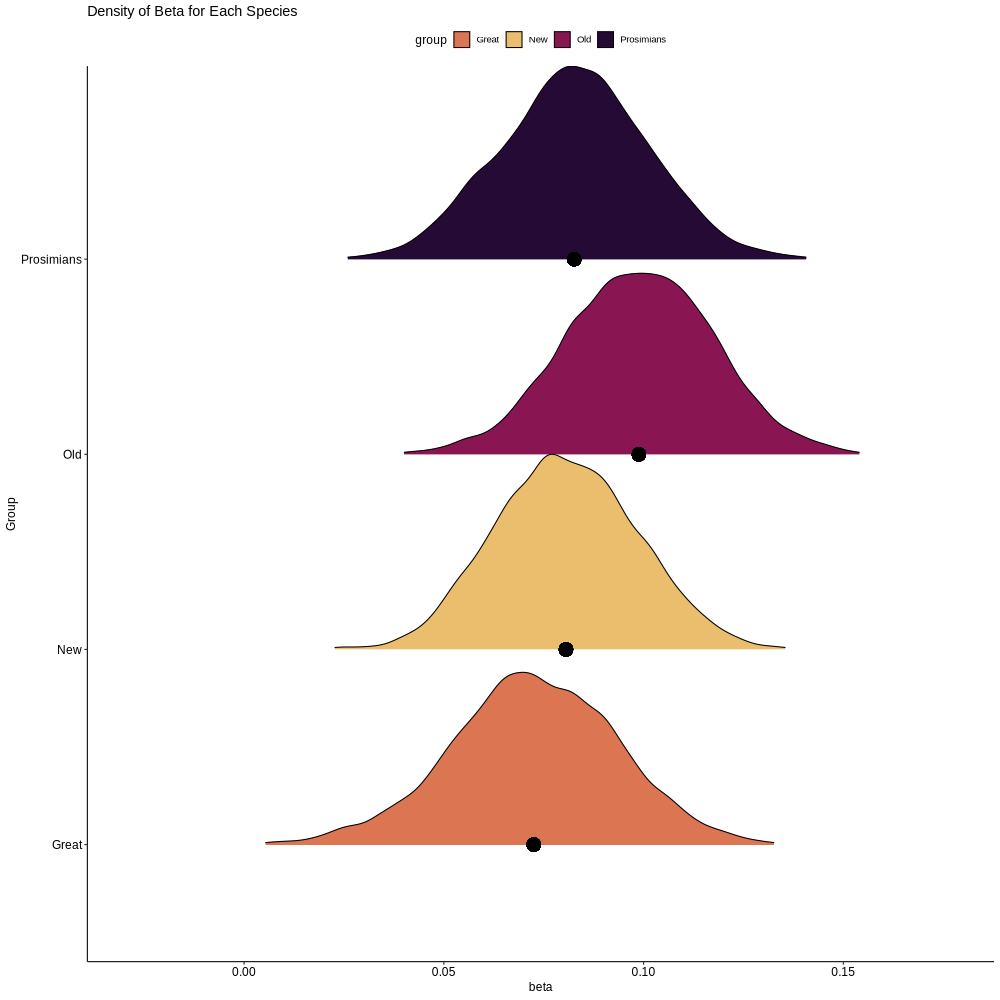

In [111]:
%%R -h 1000 -w 1000
# Load necessary libraries
library(ggplot2)
library(ggridges)
library(dplyr)

# Combine all dataframes into one and add a 'group' column
combined_data <- bind_rows(
  mutate(beta_prosimians, group = 'Prosimians'),
  mutate(beta_old, group = 'Old'),
  mutate(beta_new, group = 'New'),
  mutate(beta_great, group = 'Great')
)

# Create a joyplot
rr_betas <- ggplot() +
  geom_density_ridges_gradient(data=combined_data, aes(x = beta, y = group, fill = group),alpha = .5, scale = 1, rel_min_height = 0.01) +
  scale_fill_manual(values = c('#db7552', '#eabe6c', '#891652', '#240a34')) +
  theme_ridges(font_size = 13, grid = F) +
  xlab('beta') +
  ylab('Group') +
  ggtitle('Density of Beta for Each Species') +
    ggpubr::theme_pubr()

# Add vertical lines for the mean of each group
for(group in unique(combined_data$group)) {
  rr_betas <- rr_betas + 
    geom_point(data = filter(combined_data, group == !!group), 
               aes(x = mean(beta), y = group, color = group), 
               size = 6, alpha = .5, col = 'black')
}

# Print the plot
print(rr_betas)




In [125]:
%%R -h 1000 -w 2000
fig2 <- ggarrange(pi_r_example, model_relative_reduction, ggarrange(ggarrange(great_apes_rr, new_wolrd_rr, old_world_rr, prosimians_rr, ncol = 2, nrow= 2),rr_betas,nrow=2), ncol=3,widths = c(4,3,3))
ggsave('relative_reduction_fig2.svg',fig2)

R[write to console]: Picking joint bandwidth of 0.00284



Saving 27.8 x 13.9 in image


# Effect of Ne on \pi pymc

In [52]:
%%R
b_df_species <- read_delim('../../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/b_18_12_2023', delim = '\t')
h0 <- read_delim('../../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/h0_18_12_2023', delim = '\t')
h1 <- read_delim('../../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/h1_18_12_2023', delim = '\t')
Ne <- read_csv('../../results/model/Nested_model/log_scaled_z_scores.csv') %>% select(full_species,NE_MEDIAN,z_ne) %>% distinct(full_species, .keep_all=TRUE) %>% separate(full_species, into = c("genus", "species"), sep = "_", remove = FALSE)
pg_namedf <- read_delim('../../data/genus_phylogenetic_group_metadata.txt', delim='\t')

Rows: 1496000 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Species
dbl (3): chain, draw, b

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, h0

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, h1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2929097 Columns: 5
── Column specification ───────────────────────────────────

In [ ]:
%%R
b_df_species

In [60]:
%%R
b_species <- b_df_species %>% 
    group_by(Species,draw) %>% reframe(
    b = mean(b)) %>%
    group_by(Species) %>% reframe(
    sd = sd(b),
    b = mean(b),
    low = b-sd,
    high = b+sd
    )
b_species

# A tibble: 187 × 5
   Species                           sd      b    low   high
   <chr>                          <dbl>  <dbl>  <dbl>  <dbl>
 1 Allenopithecus_nigroviridis 0.000763 0.0344 0.0337 0.0352
 2 Allochrocebus_lhoesti       0.000741 0.0357 0.0349 0.0364
 3 Allochrocebus_preussi       0.000748 0.0289 0.0282 0.0297
 4 Allochrocebus_solatus       0.000826 0.0279 0.0271 0.0287
 5 Alouatta_belzebul           0.00116  0.0452 0.0441 0.0464
 6 Alouatta_caraya             0.00115  0.0227 0.0216 0.0239
 7 Alouatta_discolor           0.00112  0.0484 0.0473 0.0496
 8 Alouatta_juara              0.00109  0.0464 0.0453 0.0475
 9 Alouatta_macconnelli        0.00108  0.0567 0.0556 0.0578
10 Alouatta_nigerrima          0.00113  0.0657 0.0646 0.0668
# ℹ 177 more rows
# ℹ Use `print(n = ...)` to see more rows


In [61]:
%%R
h1

# A tibble: 8,000 × 3
   chain  draw    h1
   <dbl> <dbl> <dbl>
 1     0     0 0.268
 2     0     1 0.265
 3     0     2 0.242
 4     0     3 0.249
 5     0     4 0.249
 6     0     5 0.248
 7     0     6 0.246
 8     0     7 0.237
 9     0     8 0.238
10     0     9 0.234
# ℹ 7,990 more rows
# ℹ Use `print(n = ...)` to see more rows


In [62]:
%%R
#HPDI
h1_reframed <- h1 %>% 
    reframe(
        x = seq(4,6,by = 0.01),
    fifty_low = quantile(h1,0.25),
        fifty_max = quantile(h1,0.75),
        seventyfive_low = quantile(h1,0.125),
        seventyfive_max = quantile(h1,0.875),
        ninetyfive_low = quantile(h1,0.025),
        ninetyfive_max = quantile(h1,0.975))
h1_reframed


# A tibble: 201 × 7
       x fifty_low fifty_max seventyfive_low seventyfive_max ninetyfive_low
   <dbl>     <dbl>     <dbl>           <dbl>           <dbl>          <dbl>
 1  4        0.239     0.262           0.230           0.270          0.215
 2  4.01     0.239     0.262           0.230           0.270          0.215
 3  4.02     0.239     0.262           0.230           0.270          0.215
 4  4.03     0.239     0.262           0.230           0.270          0.215
 5  4.04     0.239     0.262           0.230           0.270          0.215
 6  4.05     0.239     0.262           0.230           0.270          0.215
 7  4.06     0.239     0.262           0.230           0.270          0.215
 8  4.07     0.239     0.262           0.230           0.270          0.215
 9  4.08     0.239     0.262           0.230           0.270          0.215
10  4.09     0.239     0.262           0.230           0.270          0.215
# ℹ 191 more rows
# ℹ 1 more variable: ninetyfive_max <dbl>
# ℹ Use 

In [63]:
%%R
merged_data <- merge(b_species, Ne, by.x = "Species", by.y = "full_species", all.x = TRUE) 
merged_data <- merge(merged_data, pg_namedf, by.x = "genus", by.y = "genus", all.x = TRUE)

In [64]:
%%R 
head(merged_data)

           genus                     Species           sd          b        low
1 Allenopithecus Allenopithecus_nigroviridis 0.0007634307 0.03442862 0.03366519
2  Allochrocebus       Allochrocebus_lhoesti 0.0007408790 0.03565911 0.03491823
3  Allochrocebus       Allochrocebus_preussi 0.0007478874 0.02890667 0.02815878
4  Allochrocebus       Allochrocebus_solatus 0.0008258327 0.02789031 0.02706448
5       Alouatta           Alouatta_belzebul 0.0011634656 0.04523868 0.04407522
6       Alouatta             Alouatta_caraya 0.0011473730 0.02273937 0.02159200
        high      species NE_MEDIAN        z_ne           pg_name
1 0.03519205 nigroviridis  48795.24 -0.03271925 Old_world_monkeys
2 0.03639999      lhoesti  83265.95  0.01553165 Old_world_monkeys
3 0.02965455      preussi  91643.61  0.02418741 Old_world_monkeys
4 0.02871614      solatus 101523.50  0.03343143 Old_world_monkeys
5 0.04640215     belzebul  54569.55 -0.02262106 New_world_monkeys
6 0.02388674       caraya  35650.21 -0.06105

In [65]:
%%R
# GET HDPI

# Define parameters
sample <- 1000
h0_vec <- sample(h0$h0, sample, replace = TRUE)
h1_vec <- sample(h1$h1, sample, replace = TRUE)

# Generate sampled points
sampled_points <- map_dfr(1:sample, ~{
  alpha <- sample(h0_vec, 1)
  beta <- sample(h1_vec, 1)
  tibble(x = seq(40000, 5000000, by = 1000), y = alpha + beta * log10(x))
})

sampled_points$x <- as.character(sampled_points$x)

HPDI_h1_ne <- sampled_points %>% 
    group_by(x) %>%
    reframe(
        fifty_low = quantile(y,0.25),
        fifty_max = quantile(y,0.75),
        seventyfive_low = quantile(y,0.125),
        seventyfive_max = quantile(y,0.875),
        ninetyfive_low = quantile(y,0.025),
        ninetyfive_max = quantile(y,0.975)
        )
HPDI_h1_ne$x <- as.double(HPDI_h1_ne$x)
HPDI_h1_ne

# A tibble: 4,961 × 7
         x fifty_low fifty_max seventyfive_low seventyfive_max ninetyfive_low
     <dbl>     <dbl>     <dbl>           <dbl>           <dbl>          <dbl>
 1 1001000      1.49      1.63            1.44            1.69           1.34
 2 1002000      1.49      1.63            1.44            1.69           1.34
 3 1003000      1.49      1.63            1.44            1.69           1.34
 4 1004000      1.49      1.63            1.44            1.69           1.34
 5 1005000      1.49      1.63            1.44            1.69           1.34
 6 1006000      1.49      1.63            1.44            1.69           1.34
 7 1007000      1.49      1.63            1.44            1.69           1.34
 8 1008000      1.49      1.64            1.44            1.69           1.34
 9 1009000      1.49      1.64            1.44            1.69           1.34
10  101000      1.25      1.37            1.21            1.42           1.12
# ℹ 4,951 more rows
# ℹ 1 more variable: n

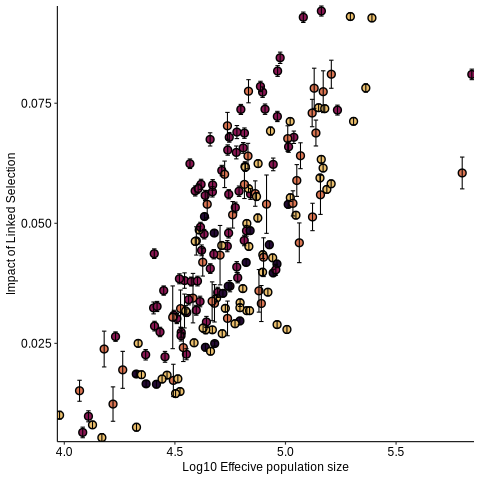

In [66]:
%%R
fig1 <-
merged_data %>% 
    ggplot()+
    geom_point(aes(x=log10(NE_MEDIAN),y=b,fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    #geom_line(aes(x=log10(NE_MEDIAN), y=(mean(h0$h0))+(mean(h1$h1)*log10(NE_MEDIAN))), lty = 2)+
    geom_errorbar(aes(x = log10(NE_MEDIAN), ymin=b-sd, ymax=b+sd), col = 'black', width=.02,
                     position=position_dodge(.9)) +
    #geom_ribbon(data=HPDI_h1_ne, aes(x= x, ymin = fifty_low, ymax = fifty_max), fill='grey', alpha = .5)+
    #geom_ribbon(data=HPDI_h1_ne, aes(x = x, ymin = seventyfive_low, ymax = seventyfive_max), fill='grey', alpha = .5)+
    #geom_ribbon(data=HPDI_h1_ne, aes(x = x, ymin = ninetyfive_low, ymax = ninetyfive_max), fill='grey', alpha = .5)+
    scale_fill_manual(values=c('#240a34','#891652','#eabe6c','#db7552')) +
     ylab("Impact of Linked Selection")+
     xlab('Log10 Effecive population size')+
    scale_x_continuous(expand = c(0, 0))+
    scale_y_continuous(expand = expansion(mult = c(0,0)))+
    ggpubr::theme_pubr(legend = 'none')
print(fig1)

`geom_smooth()` using formula = 'y ~ x'


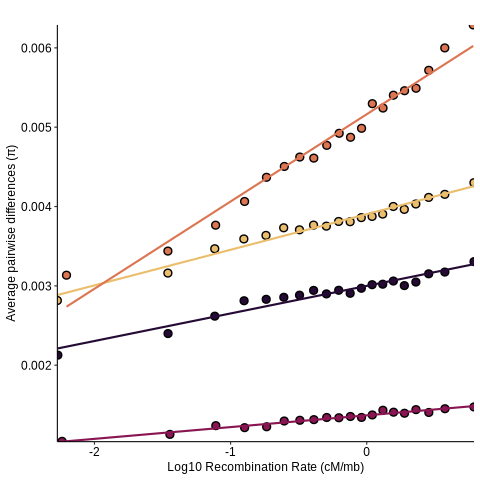

In [67]:
%%R
pi_log_r_example <- merged_tibble %>%  
    filter(genus %in% c('Pongo','Eulemur','Macaca','Pithecia') & species %in% c('abelii','fulvus','fascicularis','albicans')) %>%
    ggplot(aes(x = log10(cm_per_mb), y = mean_pi, group = species))+
    geom_point(aes(fill=species),color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    geom_smooth(method = 'lm', se = F, aes( col = species))+
    scale_color_manual(values = c('#240a34','#891652','#eabe6c','#db7552'))+
    scale_fill_manual(values = c('#240a34','#891652','#eabe6c','#db7552'))+
    labs(x = "Log10 Recombination Rate (cM/mb)", y = "Average pairwise differences (π)", title = "", size = 55) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_x_continuous(expand = c(0, 0))+
    scale_y_continuous(expand = expansion(mult = c(0,0)))
pi_log_r_example

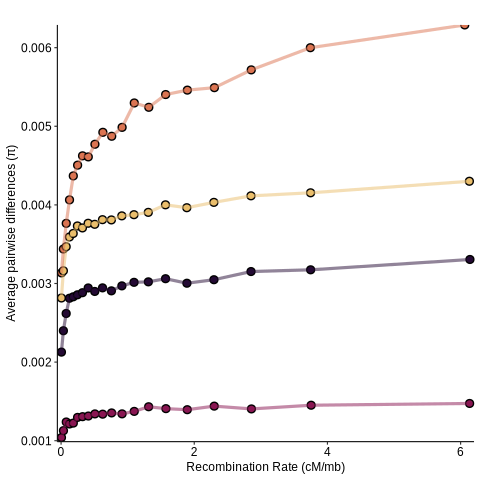

In [68]:
%%R
pi_r_example <- merged_tibble %>%  
    filter(genus %in% c('Pongo','Eulemur','Macaca','Pithecia') & species %in% c('abelii','fulvus','fascicularis','albicans')) %>%
    ggplot(aes(x = cm_per_mb, y = mean_pi, col = species))+
    geom_point(aes(fill=species),color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    geom_line(alpha = .5, size =1.5)+
    scale_fill_manual(values = c('#240a34','#891652','#eabe6c','#db7552'))+
    scale_colour_manual(values = c('#240a34','#891652','#eabe6c','#db7552'))+
    labs(x = "Recombination Rate (cM/mb)", y = "Average pairwise differences (π)", title = "", size = 55) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_x_continuous(expand = c(0.01, 0)) +
    scale_y_continuous(expand = expansion(mult = c(0.01,0)))
pi_r_example

`geom_smooth()` using formula = 'y ~ x'


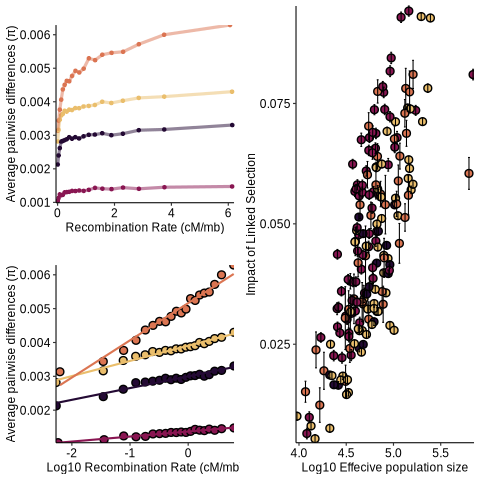

In [44]:
%%R
ggarrange(
  ggarrange(pi_r_example, pi_log_r_example, ncol = 1), # First column with two plots stacked vertically
  fig1,                                               # Second column with one plot
  ncol = 2                                           # Two columns in total
)

In [100]:
%%R
text_size <- 20
font_family <- "Franklin Gothic Book"

# Arrange the plots with common text size and font
impact_of_selection <- ggarrange(
  ggarrange(pi_r_example, pi_log_r_example, ncol = 1) + 
    theme(text = element_text(size = text_size, family = font_family)),
  
  fig1 +
    theme(text = element_text(size = text_size, family = font_family)),
  
  ncol = 2,
  labels = c("A", "B")  # Add labels
)

# Save the arranged plots with specified dimensions
ggsave("impact_of_selection.svg", impact_of_selection, width = 22, height = 17, units = "cm", dpi = 500)

`geom_smooth()` using formula = 'y ~ x'


# Full genome comparisons 

In [45]:
%%R
df20 <- read_delim('../../results/combined/all.csv', delim=',') %>% group_by(genus,species) %>% mutate(recomb_bin = ntile(cm_per_mb, 20))
pg_namedf <- read_delim('../../data/genus_phylogenetic_group_metadata.txt', delim='\t')
merge_pg_name <- left_join(df20,pg_namedf, by = c('genus'='genus'))
merge_pg_name$pg_name <- as_factor(merge_pg_name$pg_name)
nes <- read_delim('../../results/model/Nested_model/Ne_Pi_recomb.csv', delim = ',') %>% select('genus','species','NE_MEAN','NE_MEDIAN')
nes <- nes %>% 
    group_by(genus,species) %>%
    reframe(
        NE_MEAN = mean(NE_MEAN),
        NE_MEDIAN = mean(NE_MEDIAN))

Rows: 5257244 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): chr, species, genus
dbl (13): start, end, freq_mean, freq_min, freq_max, freq_median, window_siz...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 57 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): genus, pg_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 5071829 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): genus, species, FAMILY, chr
dbl (21): ...1, Unnamed: 0, MEAN, MEDIAN, VARIANCE, NE_MEAN, NE_MEDIAN, NE_V...

ℹ Use `spec()` to retrieve the full column specifi

In [46]:
%%R
head(df20)

# A tibble: 6 × 17
# Groups:   genus, species [1]
  chr     start     end freq_mean freq_min freq_max freq_median window_size_mean
  <chr>   <dbl>   <dbl>     <dbl>    <dbl>    <dbl>       <dbl>            <dbl>
1 chr1  1700001 1800000     0.395    0.395    0.395       0.395            99999
2 chr1  1800001 1900000     0.677    0.677    0.677       0.677            99999
3 chr1  1900001 2000000     0.571    0.571    0.571       0.571            99999
4 chr1  2100001 2200000     0.671    0.671    0.671       0.671            99999
5 chr1  2200001 2300000     0.727    0.727    0.727       0.727            99999
6 chr1  2400001 2500000     0.748    0.748    0.748       0.748            99999
# ℹ 9 more variables: sum_n_mean <dbl>, species <chr>, genus <chr>,
#   cm_start <dbl>, cm_end <dbl>, cm_per_mb <dbl>, N_VARIANTS <dbl>, PI <dbl>,
#   recomb_bin <int>


# NEW MODEL

In [94]:
 trace_model = az.from_netcdf('../../results/model/Nested_model/log_ne_log_cm_sd_pi/log_ne_log_cm_sd_pi_model_24_04_2024.nc')

In [6]:
trace_model

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [20]:
a = trace_model.posterior.a.to_dataframe()
b = trace_model.posterior.b.to_dataframe()
h1 = trace_model.posterior.h1.to_dataframe()
h0= trace_model.posterior.h0.to_dataframe()
a.to_csv('../../results/model/Nested_model/log_ne_log_cm_sd_pi/a_24_04_2024.tsv', sep="\t")
b.to_csv('../../results/model/Nested_model/log_ne_log_cm_sd_pi/b_24_04_2024.tsv', sep="\t")
h0.to_csv('../../results/model/Nested_model/log_ne_log_cm_sd_pi/h0_24_04_2024.tsv', sep="\t")
h1.to_csv('../../results/model/Nested_model/log_ne_log_cm_sd_pi/h1_24_04_2024.tsv', sep="\t")

b
chain draw Species                              
0     0    Allenopithecus_nigroviridis  0.101695
           Allochrocebus_lhoesti        0.140043
           Allochrocebus_preussi        0.123698
           Allochrocebus_solatus        0.103211
           Alouatta_belzebul            0.139506
...                                          ...
3     1999 Trachypithecus_melamera      0.079264
           Trachypithecus_phayrei       0.020652
           Trachypithecus_pileatus      0.084508
           Varecia_rubra                0.223261
           Varecia_variegata            0.246253

[1496000 rows x 1 columns]

In [73]:
%%R 
library(tidyverse)
a <- read_delim('../../results/model/Nested_model/log_ne_log_cm_sd_pi/a_24_04_2024.tsv', delim="\t")
b <- read_delim('../../results/model/Nested_model/log_ne_log_cm_sd_pi/b_24_04_2024.tsv', delim="\t")
h0 <- read_delim('../../results/model/Nested_model/log_ne_log_cm_sd_pi/h0_24_04_2024.tsv', delim="\t")
h1 <- read_delim('../../results/model/Nested_model/log_ne_log_cm_sd_pi/h1_24_04_2024.tsv', delim ="\t")
Ne <- read_csv('../../results/model/Nested_model/log_scaled_z_scores.csv') %>% select(full_species,NE_MEDIAN,z_ne) %>% distinct(full_species, .keep_all=TRUE) %>% separate(full_species, into = c("genus", "species"), sep = "_", remove = FALSE)
pg_namedf <- read_delim('../../data/genus_phylogenetic_group_metadata.txt', delim='\t')

Rows: 1496000 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Species
dbl (3): chain, draw, a

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1496000 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Species
dbl (3): chain, draw, b

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, h0

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ───────────────────

In [74]:
%%R
# Define parameters
sample <- 1000
h0_vec <- sample(h0$h0, sample, replace = TRUE)
h1_vec <- sample(h1$h1, sample, replace = TRUE)

# Generate sampled points
sampled_points <- map_dfr(1:sample, ~{
  alpha <- sample(h0_vec, 1)
  beta <- sample(h1_vec, 1)
  tibble(x = seq(4000, 5000000, by = 1000), y = alpha + beta * log10(x), logx = log10(x))
})

sampled_points$x <- as.character(sampled_points$x)

HPDI_h1_ne <- sampled_points %>% 
    group_by(x,logx) %>%
    reframe(
        fifty_low = quantile(y,0.25),
        fifty_max = quantile(y,0.75),
        seventyfive_low = quantile(y,0.125),
        seventyfive_max = quantile(y,0.875),
        ninetyfive_low = quantile(y,0.025),
        ninetyfive_max = quantile(y,0.975)
        )
HPDI_h1_ne$x <- as.double(HPDI_h1_ne$x)
HPDI_h1_ne

# A tibble: 4,997 × 8
         x  logx fifty_low fifty_max seventyfive_low seventyfive_max
     <dbl> <dbl>     <dbl>     <dbl>           <dbl>           <dbl>
 1   10000  4      -0.0549    0.0618         -0.0996          0.0997
 2 1001000  6.00    0.396     0.544           0.343           0.591 
 3 1002000  6.00    0.396     0.544           0.343           0.592 
 4 1003000  6.00    0.396     0.544           0.343           0.592 
 5 1004000  6.00    0.396     0.544           0.343           0.592 
 6 1005000  6.00    0.396     0.545           0.343           0.592 
 7 1006000  6.00    0.397     0.545           0.344           0.592 
 8 1007000  6.00    0.397     0.545           0.344           0.592 
 9 1008000  6.00    0.397     0.545           0.344           0.592 
10 1009000  6.00    0.397     0.545           0.344           0.592 
# ℹ 4,987 more rows
# ℹ 2 more variables: ninetyfive_low <dbl>, ninetyfive_max <dbl>
# ℹ Use `print(n = ...)` to see more rows


In [75]:
%%R
head(b)

# A tibble: 6 × 4
  chain  draw Species                          b
  <dbl> <dbl> <chr>                        <dbl>
1     0     0 Allenopithecus_nigroviridis 0.102 
2     0     0 Allochrocebus_lhoesti       0.140 
3     0     0 Allochrocebus_preussi       0.124 
4     0     0 Allochrocebus_solatus       0.103 
5     0     0 Alouatta_belzebul           0.140 
6     0     0 Alouatta_caraya             0.0880


In [76]:
%%R
b_species <- b %>% 
    group_by(Species) %>% reframe(
    upper = quantile(b,.95),
    lower = quantile(b,.05),
    b = mean(b))
b_species
merged_data <- merge(b_species, Ne, by.x = "Species", by.y = "full_species", all.x = TRUE) 
merged_data <- merge(merged_data, pg_namedf, by.x = "genus", by.y = "genus", all.x = TRUE)

In [77]:
%%R
head(merged_data)

           genus                     Species      upper      lower          b
1 Allenopithecus Allenopithecus_nigroviridis 0.11771385 0.09330474 0.10540520
2  Allochrocebus       Allochrocebus_lhoesti 0.15608843 0.13154464 0.14388053
3  Allochrocebus       Allochrocebus_preussi 0.12702571 0.10247056 0.11485203
4  Allochrocebus       Allochrocebus_solatus 0.11837465 0.09385571 0.10616078
5       Alouatta           Alouatta_belzebul 0.14560322 0.11795811 0.13165521
6       Alouatta             Alouatta_caraya 0.09786083 0.07102094 0.08454552
       species NE_MEDIAN        z_ne           pg_name
1 nigroviridis  48795.24 -0.03271925 Old_world_monkeys
2      lhoesti  83265.95  0.01553165 Old_world_monkeys
3      preussi  91643.61  0.02418741 Old_world_monkeys
4      solatus 101523.50  0.03343143 Old_world_monkeys
5     belzebul  54569.55 -0.02262106 New_world_monkeys
6       caraya  35650.21 -0.06105886 New_world_monkeys


In [78]:
%%R
merged_data %>% filter(lower <= 0)

           genus                      Species      upper        lower
1 Trachypithecus Trachypithecus_leucocephalus 0.01586329 -0.008883083
            b       species NE_MEDIAN       z_ne           pg_name
1 0.003654764 leucocephalus  14783.54 -0.1405346 Old_world_monkeys


In [79]:
%%R
unique(merged_data$Species)

  [1] "Allenopithecus_nigroviridis"  "Allochrocebus_lhoesti"       
  [3] "Allochrocebus_preussi"        "Allochrocebus_solatus"       
  [5] "Alouatta_belzebul"            "Alouatta_caraya"             
  [7] "Alouatta_discolor"            "Alouatta_juara"              
  [9] "Alouatta_macconnelli"         "Alouatta_nigerrima"          
 [11] "Alouatta_palliata"            "Alouatta_puruensis"          
 [13] "Alouatta_seniculus"           "Aotus_azarae"                
 [15] "Aotus_griseimembra"           "Aotus_trivirgatus"           
 [17] "Aotus_vociferans"             "Arctocebus_calabarensis"     
 [19] "Ateles_belzebuth"             "Ateles_chamek"               
 [21] "Ateles_geoffroyi"             "Ateles_marginatus"           
 [23] "Ateles_paniscus"              "Cacajao_ayresi"              
 [25] "Cacajao_calvus"               "Cacajao_hosomi"              
 [27] "Cacajao_melanocephalus"       "Callimico_goeldii"           
 [29] "Callithrix_geoffroyi"         "Callithrix

In [80]:
%%R
merged_data %>% filter(b == max(b))

          genus              Species     upper     lower         b species
1 Cercopithecus Cercopithecus_cephus 0.4398572 0.4151087 0.4275771  cephus
  NE_MEDIAN      z_ne           pg_name
1  245938.5 0.1133181 Old_world_monkeys


In [81]:
%%R
# Calculate the posterior predictive distribution at a given x
posterior_predictive <- function(x, slope_samples, intercept_samples) {
  slope_samples * x + intercept_samples
}

# Calculate the credibility interval
credibility_interval <- function(x, slope_samples, intercept_samples, prob = c(0.025, 0.975)) {
  quantile(posterior_predictive(x, slope_samples, intercept_samples), prob)
}

# Use the function
x_values <- c()
lower_bounds <- c()
upper_bounds <- c()

# Calculate the credibility intervals for each x value
for (i in log10(merged_data$NE_MEDIAN)) {
    cred_int <- credibility_interval(i, h1$h1, h0$h0)
    x_values <- c(x_values, i)
    lower_bounds <- c(lower_bounds, cred_int[1])
    upper_bounds <- c(upper_bounds, cred_int[2])
}

# Create a data frame
mean_reg_line <- data.frame(
    x = x_values,
    lower_bound = lower_bounds,
    upper_bound = upper_bounds
)


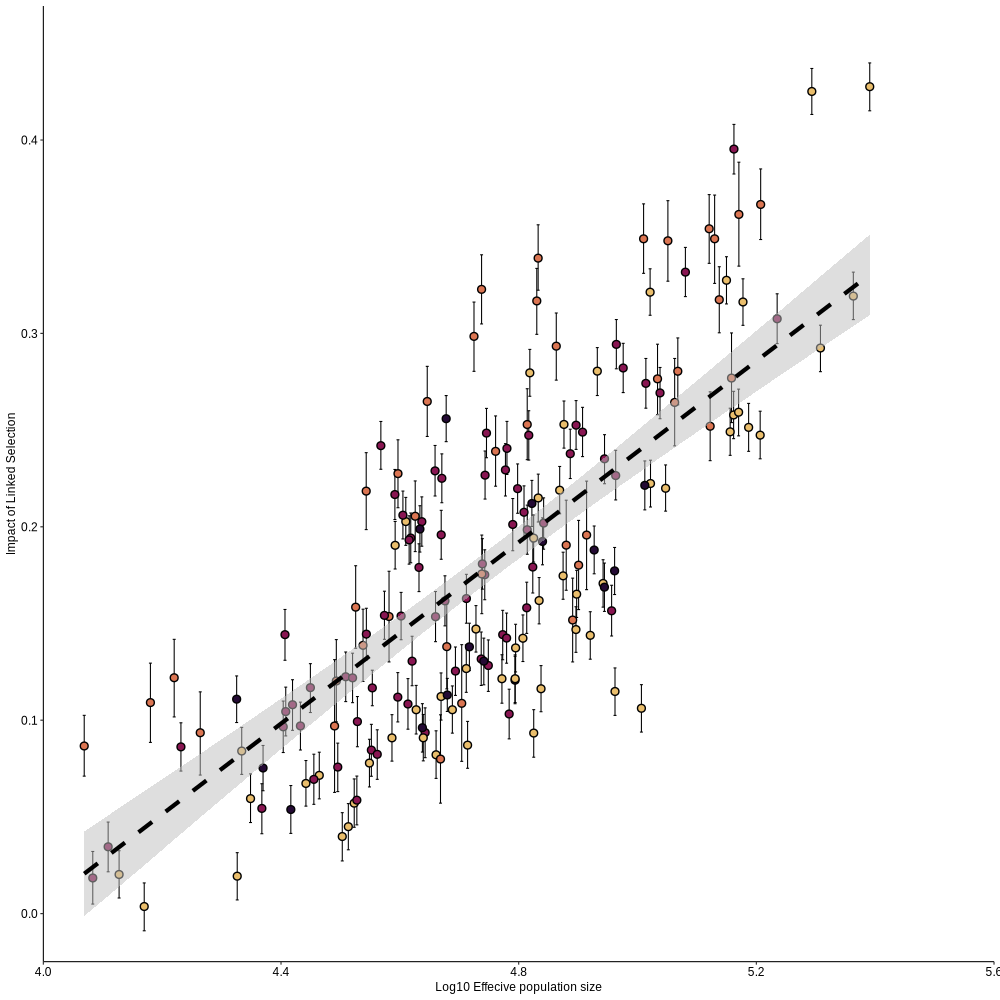

In [82]:
%%R -w 1000 -h 1000
fig3_par1 <- merged_data %>% 
    ggplot()+
    geom_errorbar(aes(x = log10(NE_MEDIAN), ymin=lower, ymax=upper), col = 'black', width=.005,
                     position=position_dodge(.9)) +
    geom_point(aes(x=log10(NE_MEDIAN),y=b,fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    geom_ribbon(data=mean_reg_line, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(NE_MEDIAN), y=(mean(h0$h0))+(mean(h1$h1)*log10(NE_MEDIAN))), lty = 2, size =2)+
    scale_fill_manual(values=c('#240a34','#891652','#eabe6c','#db7552')) +
     ylab("Impact of Linked Selection")+
     xlab('Log10 Effecive population size')+
    scale_x_continuous(expand = c(0, 0), limits = c(4,5.6))+
    scale_y_continuous(expand = expansion(mult = c(0,0)))+
    ggpubr::theme_pubr(legend = 'none')
print(fig3_par1)

In [50]:
%%R
sampleh1 = sample(h1$h1,1000,replace= TRUE)
quantile(sampleh1,c(0.025,0.975))

     2.5%     97.5% 
0.2050235 0.2660775 


`geom_smooth()` using formula = 'y ~ x'


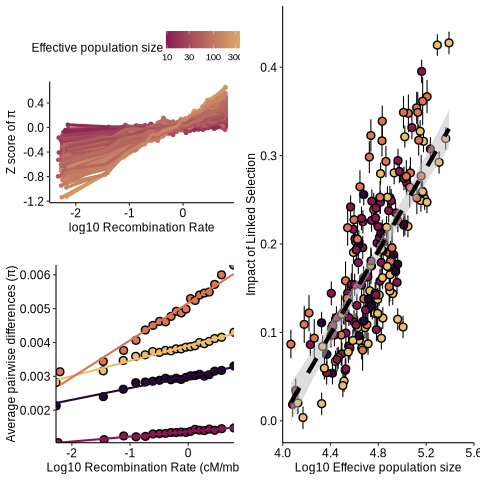

In [85]:
%%R
fig3 <- ggarrange(
  ggarrange(z_scores_pi_log_cm, pi_log_r_example, ncol = 1), # First column with two plots stacked vertically
  fig3_par1,                                             # Second column with one plot
    
  ncol = 2                                           # Two columns in total
)
print(fig3)

In [87]:
%%R


# Save the plot
ggsave('figure3_impact_model.svg', plot = fig3)

Saving 6.67 x 6.67 in image


# Tree and datastructure

In [32]:
%%R
library(tidyverse) 
library(zoo)
library(ggtree)
library(ape)
library(ggimage)
library(ggpubr)



R[write to console]: 
Attaching package: ‘ggpubr’


R[write to console]: The following object is masked from ‘package:ggimage’:

    theme_transparent


R[write to console]: The following object is masked from ‘package:ape’:

    rotate


R[write to console]: The following object is masked from ‘package:ggtree’:

    rotate




In [176]:
%%R
df <- read_delim('../../results/combined/all.csv', delim=',')
#neutral_pi <- read_delim('../../results/pi_in_five_percent.csv',delim = ',')
bin_df <- df %>% filter(chr != 'chrX') %>% group_by(genus,species, chr) %>% mutate(bins = ntile(start,100000)) %>% filter(chr != 'chrX') %>% filter(freq_mean > .5)
pg_namedf <- read_delim('../../data/genus_phylogenetic_group_metadata.txt', delim='\t')

merged_data <- merge(bin_df, pg_namedf, by.x = "genus", by.y = "genus", all.x = TRUE)

tree <- read.tree("../../data/S4_UCE_species_tree.nw.tree")


Rows: 5257244 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): chr, species, genus
dbl (13): start, end, freq_mean, freq_min, freq_max, freq_median, window_siz...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 57 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): genus, pg_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [177]:
%%R

tree <- read.tree("../../data/S4_UCE_species_tree.nw.tree")

In [178]:
%%R
merged_data <- merged_data %>% mutate(node = paste(genus, species, sep = '_'))

In [179]:
%%R
list_of_tips <- unique(merged_data$node)


In [180]:
%%R
diff <- setdiff(tree$tip.label, list_of_tips)

In [181]:
%%R
diff

 [1] "Papio_anubis"               "Papio_papio"               
 [3] "Papio_hamadryas"            "Papio_ursinus"             
 [5] "Papio_kindae"               "Papio_cynocephalus"        
 [7] "Theropithecus_gelada"       "Trachypithecus_crepusculus"
 [9] "Trachypithecus_obscurus"    "Trachypithecus_auratus"    
[11] "Trachypithecus_cristatus"   "Trachypithecus_francoisi"  
[13] "Trachypithecus_geei"        "Pygathrix_nemaeus"         
[15] "Pygathrix_cinerea"          "Pygathrix_nigripes"        
[17] "Nasalis_larvatus"           "Presbytis_mitrata"         
[19] "Presbytis_comata"           "Piliocolobus_gordonorum"   
[21] "Piliocolobus_kirkii"        "Piliocolobus_tephrosceles" 
[23] "Piliocolobus_badius"        "Nomascus_leucogenys"       
[25] "Homo_sapiens"               "Carlito_syrichta"          
[27] "Cephalopachus_bancanus"     "Tarsius_lariang"           
[29] "Tarsius_wallacei"           "Propithecus_verreauxi"     
[31] "Propithecus_coquereli"      "Propithecus_tattersa

In [182]:
%%R
new_tree <- drop.tip(tree, diff)


In [183]:
%%R

reduced <- merged_data %>% group_by(node) %>%
    reframe(
        pg_name = first(pg_name))

In [184]:
%%R
reduced$pg_name <- as.factor(reduced$pg_name)
reduced

# A tibble: 194 × 2
   node                        pg_name          
   <chr>                       <fct>            
 1 Allenopithecus_nigroviridis Old_world_monkeys
 2 Allochrocebus_lhoesti       Old_world_monkeys
 3 Allochrocebus_preussi       Old_world_monkeys
 4 Allochrocebus_solatus       Old_world_monkeys
 5 Alouatta_belzebul           New_world_monkeys
 6 Alouatta_caraya             New_world_monkeys
 7 Alouatta_discolor           New_world_monkeys
 8 Alouatta_juara              New_world_monkeys
 9 Alouatta_macconnelli        New_world_monkeys
10 Alouatta_nigerrima          New_world_monkeys
# ℹ 184 more rows
# ℹ Use `print(n = ...)` to see more rows


In [185]:
%%R
new_tree1 <- left_join(new_tree, reduced, by = c('label' = 'node'))


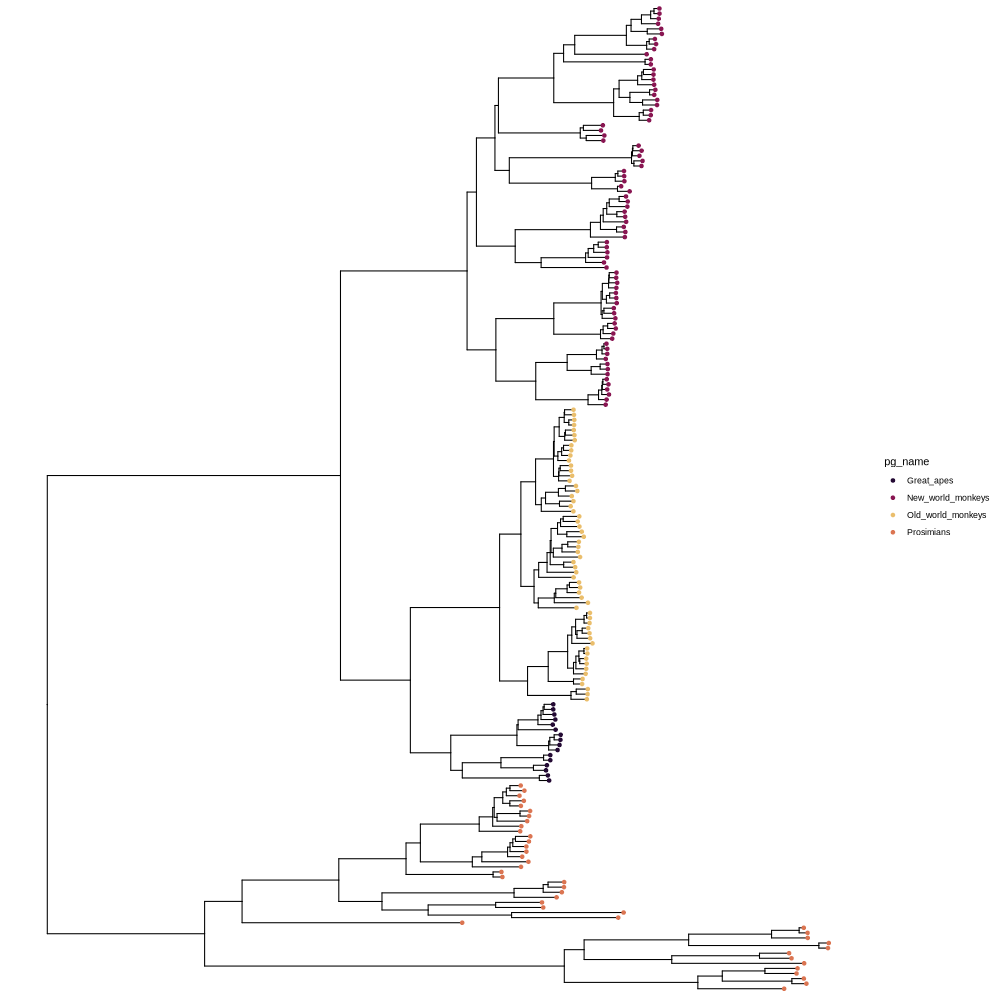

In [186]:
%%R -h 1000 -w 1000
tree_plot <- ggtree(new_tree1) +
    geom_tippoint(aes(color=pg_name), size=1.5)+
    scale_colour_manual(values = c('#240a34','#891652','#eabe6c','#db7552'))
    
    


tree_plot




In [187]:
%%R
plot_tree2 <- tree_plot  + 
    geom_strip(1, 58, barsize=4, color='#eabe6c') + #old_world
    geom_strip(59, 74, barsize=4, color='#240a34') + #Apes
    geom_strip(75, 153, barsize=4, color='#891652') + # new_world
    geom_strip(154, 194, barsize=4, color='#db7552') #+
    #geom_tiplab(aes(image=uid, colour=pg_name), geom="phylopic", offset=2.5)

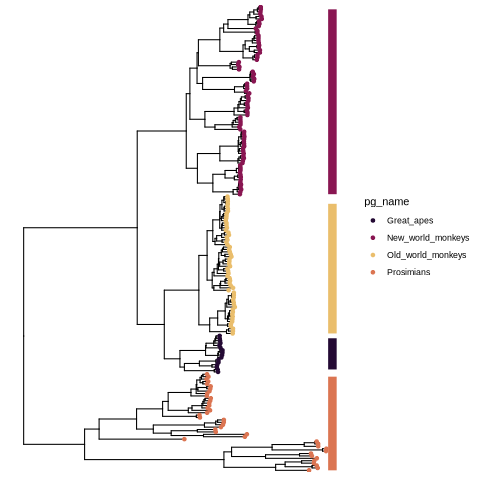

In [188]:
%%R
plot_tree2

In [174]:
%%R
roll <- merged_data %>% 
    filter(freq_mean > .5) %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    group_by(genus,species,chr, pg_name) %>% 
    reframe(
        pos = start,
        roll_pi = rollmean(PI, k = 50, fill = NA) ## 5mb rolls
    ) %>%
    na.omit()

roll$chr <- factor(roll$chr, levels = paste0("chr", 1:22))



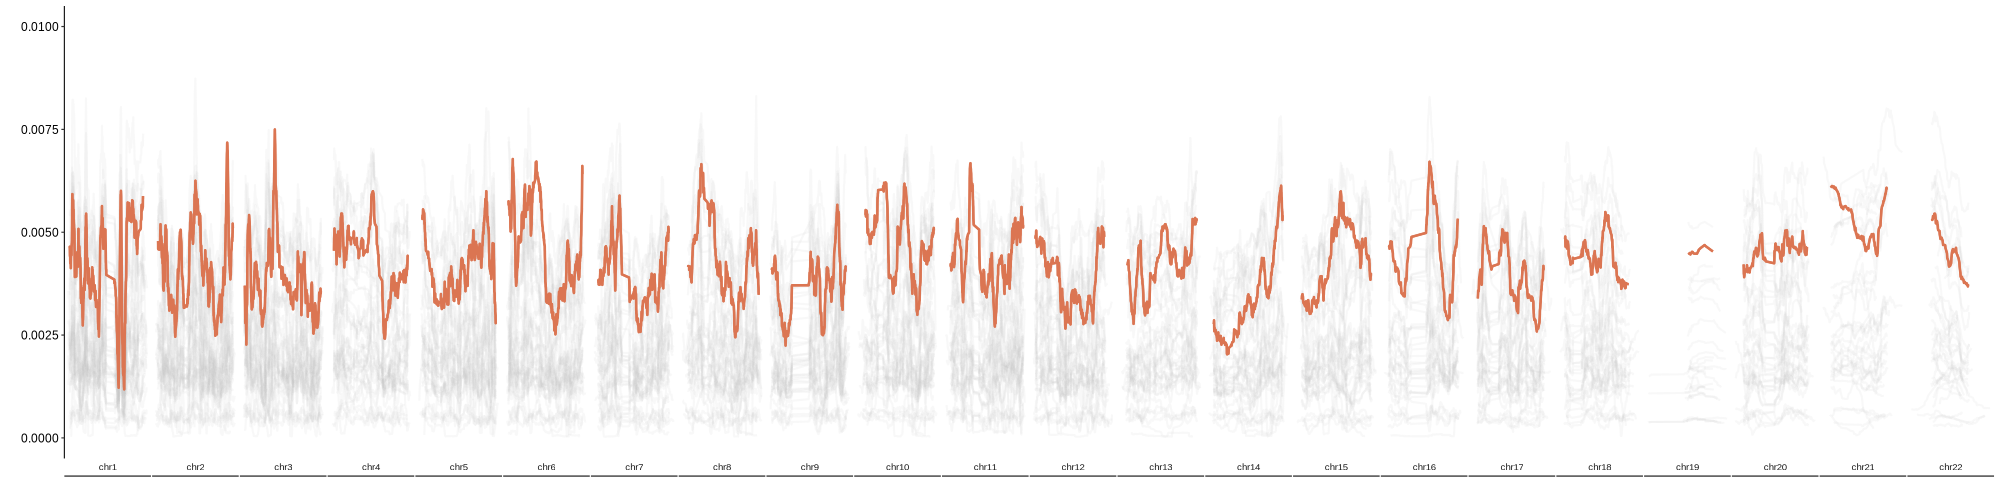

In [26]:
%%R -h 500 -w 2000

specific_species_prosimians <- roll %>% 
    filter(pg_name == 'Prosimians') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    filter(species == 'rufus') %>%
    group_by(genus,species)

plot_diversity_genome_prosimians <- roll %>% 
    filter(pg_name == 'Prosimians') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    group_by(genus,species) %>%
    ggplot(aes(x=pos,y=roll_pi, group = species, col = species == 'rufus')) +
    geom_line(aes(alpha = ifelse(species == 'rufus', 1, 0.005)), size = 1) +
    geom_line(data = specific_species_prosimians,aes(x=pos,y=roll_pi), size = 1.2) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_colour_manual(values = c('grey','#db7552'))+
    facet_wrap(chr~., scales = 'free_x', nrow=1, strip.position = 'bottom')+
    xlab('')+
    ylab('') +
    ylim(0,0.01)+
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(),
        panel.spacing=unit(.08,"lines"),
        strip.background = element_blank())
    
plot_diversity_genome_prosimians

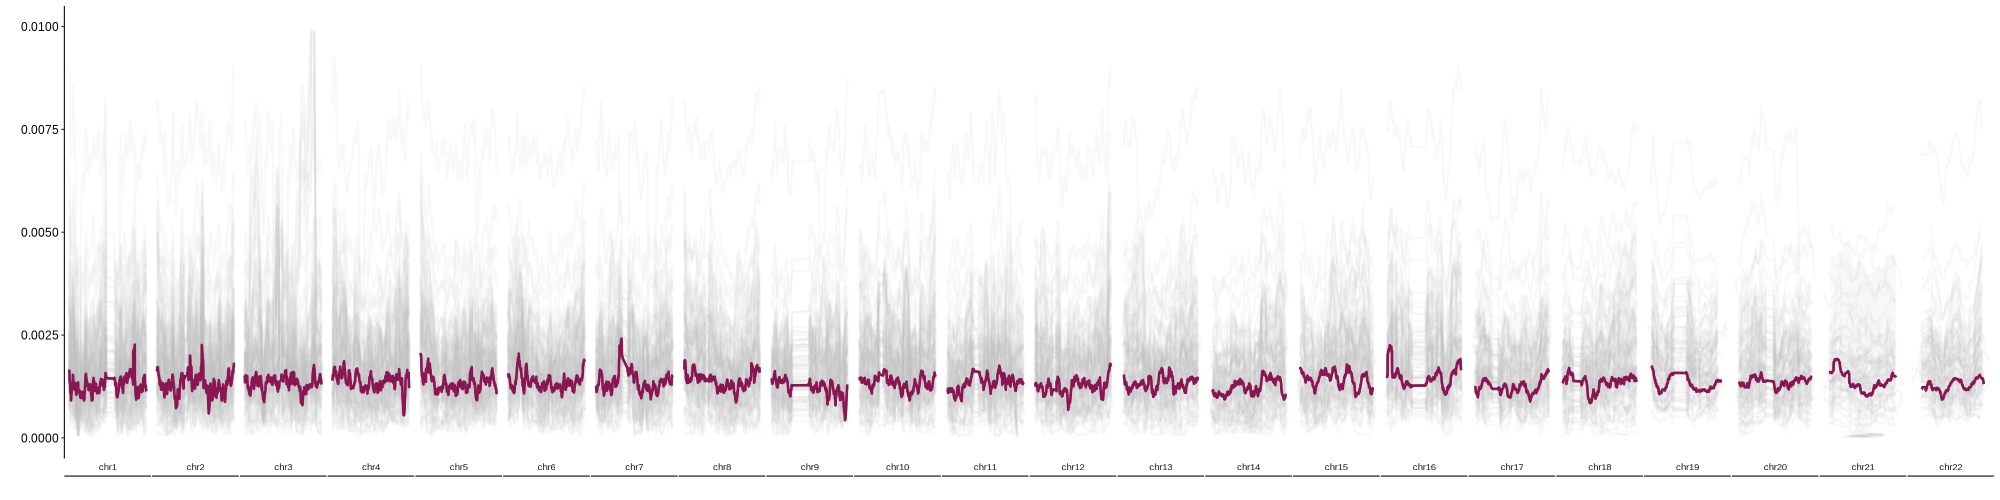

In [27]:
%%R -h 500 -w 2000

specific_species_new_world <- roll %>% 
    filter(pg_name == 'New_world_monkeys') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    filter(species == 'albicans') %>%
    group_by(genus,species)


plot_diversity_genome_new_world <- roll %>% 
    filter(pg_name == 'New_world_monkeys') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    group_by(genus,species) %>%
    ggplot(aes(x=pos,y=roll_pi, group = species, col = species == 'albicans')) +
    geom_line(aes(alpha = ifelse(species == 'albicans', 1, 0.0005)), size = 1) +
    geom_line(data = specific_species_new_world,aes(x=pos,y=roll_pi), size = 1.2) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_colour_manual(values = c('grey','#891652'))+
    facet_wrap(chr~., scales = 'free_x', nrow=1, strip.position = 'bottom')+
    xlab('')+
    ylab('') +
    ylim(0,0.01)+
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(),
        panel.spacing=unit(.08,"lines"),
        strip.background = element_blank())

plot_diversity_genome_new_world

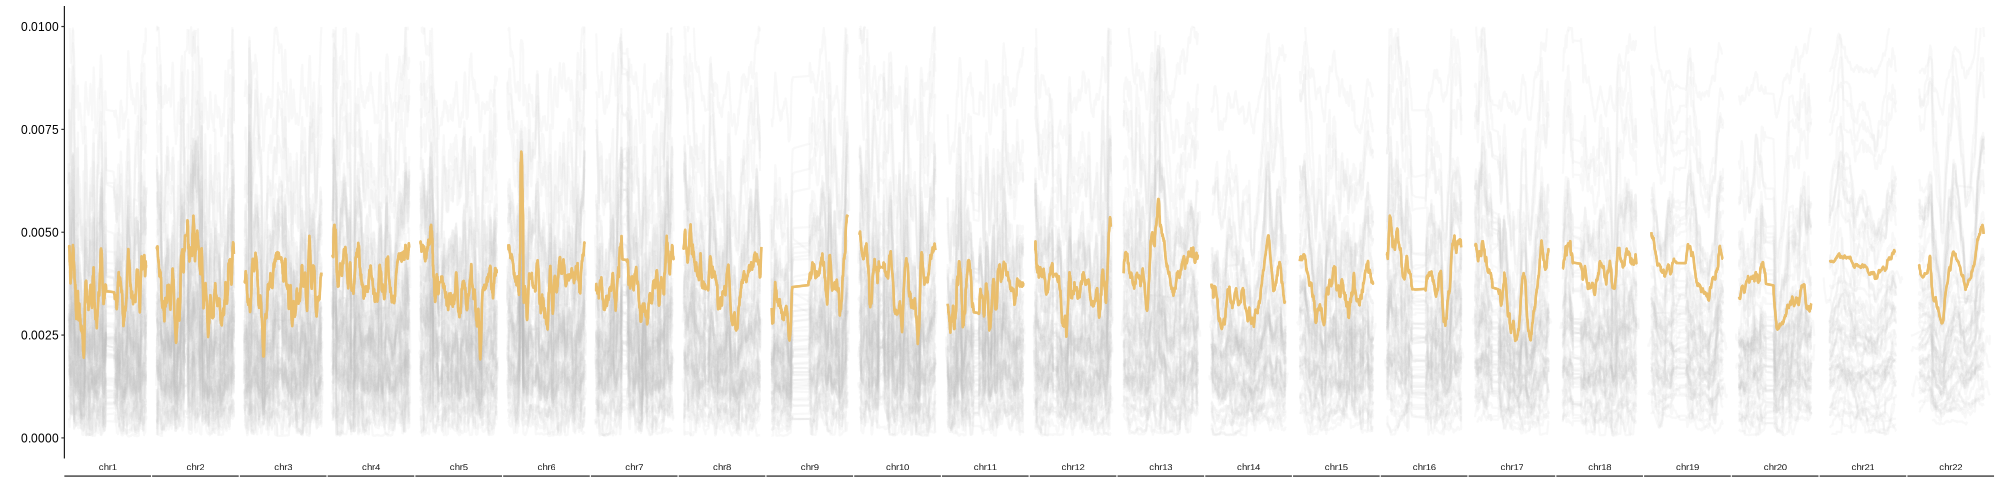

In [28]:
%%R -h 500 -w 2000

specific_species_old_world <- roll %>% 
    filter(pg_name == 'Old_world_monkeys') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    filter(species == 'fascicularis') %>%
    group_by(genus,species)


plot_diversity_genome_old_world <- roll %>% 
    filter(pg_name == 'Old_world_monkeys') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    group_by(genus,species) %>%
    ggplot(aes(x=pos,y=roll_pi, group = species, col = species == 'fascicularis')) +
    geom_line(aes(alpha = ifelse(species == 'fascicularis', 1, 0.0005)), size = 1) +
    geom_line(data = specific_species_old_world,aes(x=pos,y=roll_pi), size = 1.2) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_colour_manual(values = c('grey','#eabe6c'))+
    facet_wrap(chr~., scales = 'free_x', nrow=1, strip.position = 'bottom')+
    xlab('')+
    ylab('') +
    ylim(0,0.01)+
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(),
        panel.spacing=unit(.08,"lines"),
        strip.background = element_blank())

plot_diversity_genome_old_world

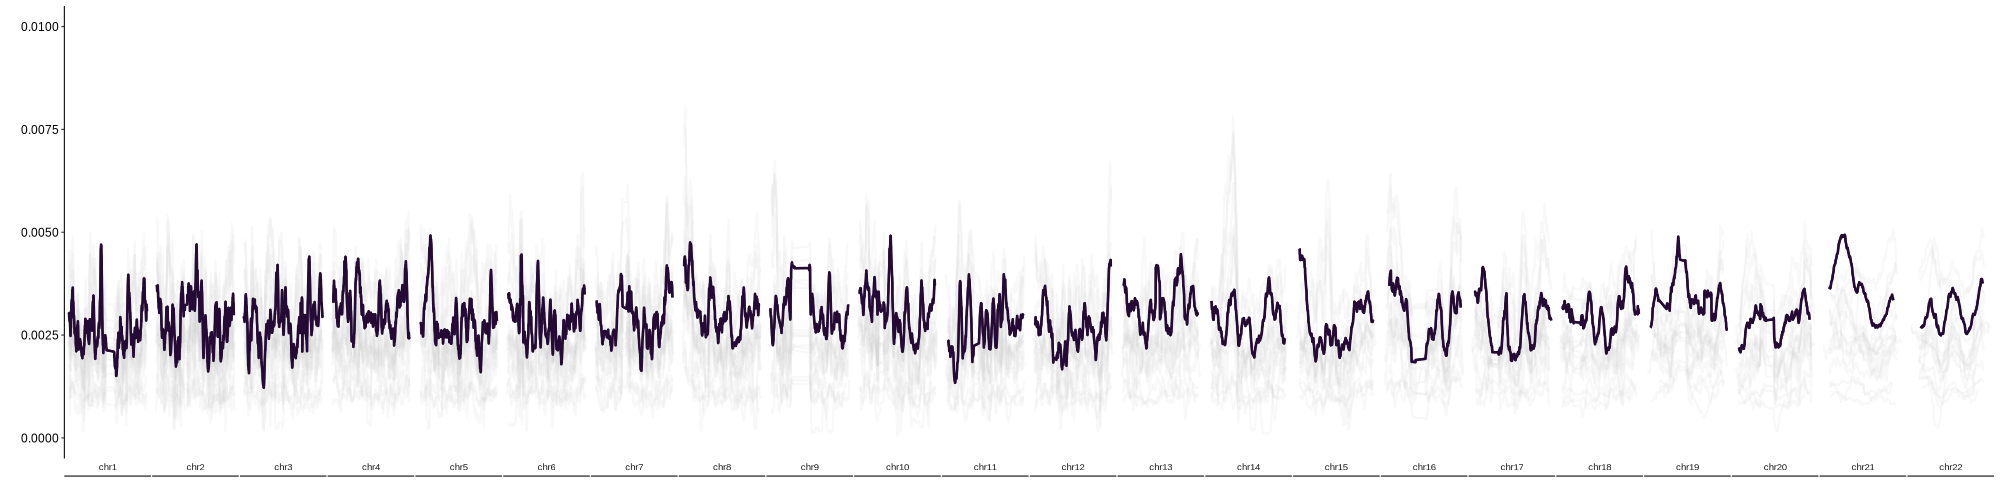

In [29]:
%%R -h 500 -w 2000

specific_species_apes <- roll %>% 
    filter(pg_name == 'Great_apes') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    filter(species == 'abelii') %>%
    group_by(genus,species)


plot_diversity_genome_apes <- roll %>% 
    filter(pg_name == 'Great_apes') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    group_by(genus,species) %>%
    ggplot(aes(x=pos,y=roll_pi, group = species, col = species == 'abelii')) +
    geom_line(aes(alpha = ifelse(species == 'abelii', 1, 0.005)), size = 1) +
    geom_line(data = specific_species_apes,aes(x=pos,y=roll_pi), size = 1.2) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_colour_manual(values = c('grey','#240a34'))+
    facet_wrap(chr~., scales = 'free_x', nrow=1, strip.position = 'bottom')+
    xlab('')+
    ylab('') +
    ylim(0,0.01)+
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(),
        panel.spacing=unit(.08,"lines"),
        strip.background = element_blank())

plot_diversity_genome_apes

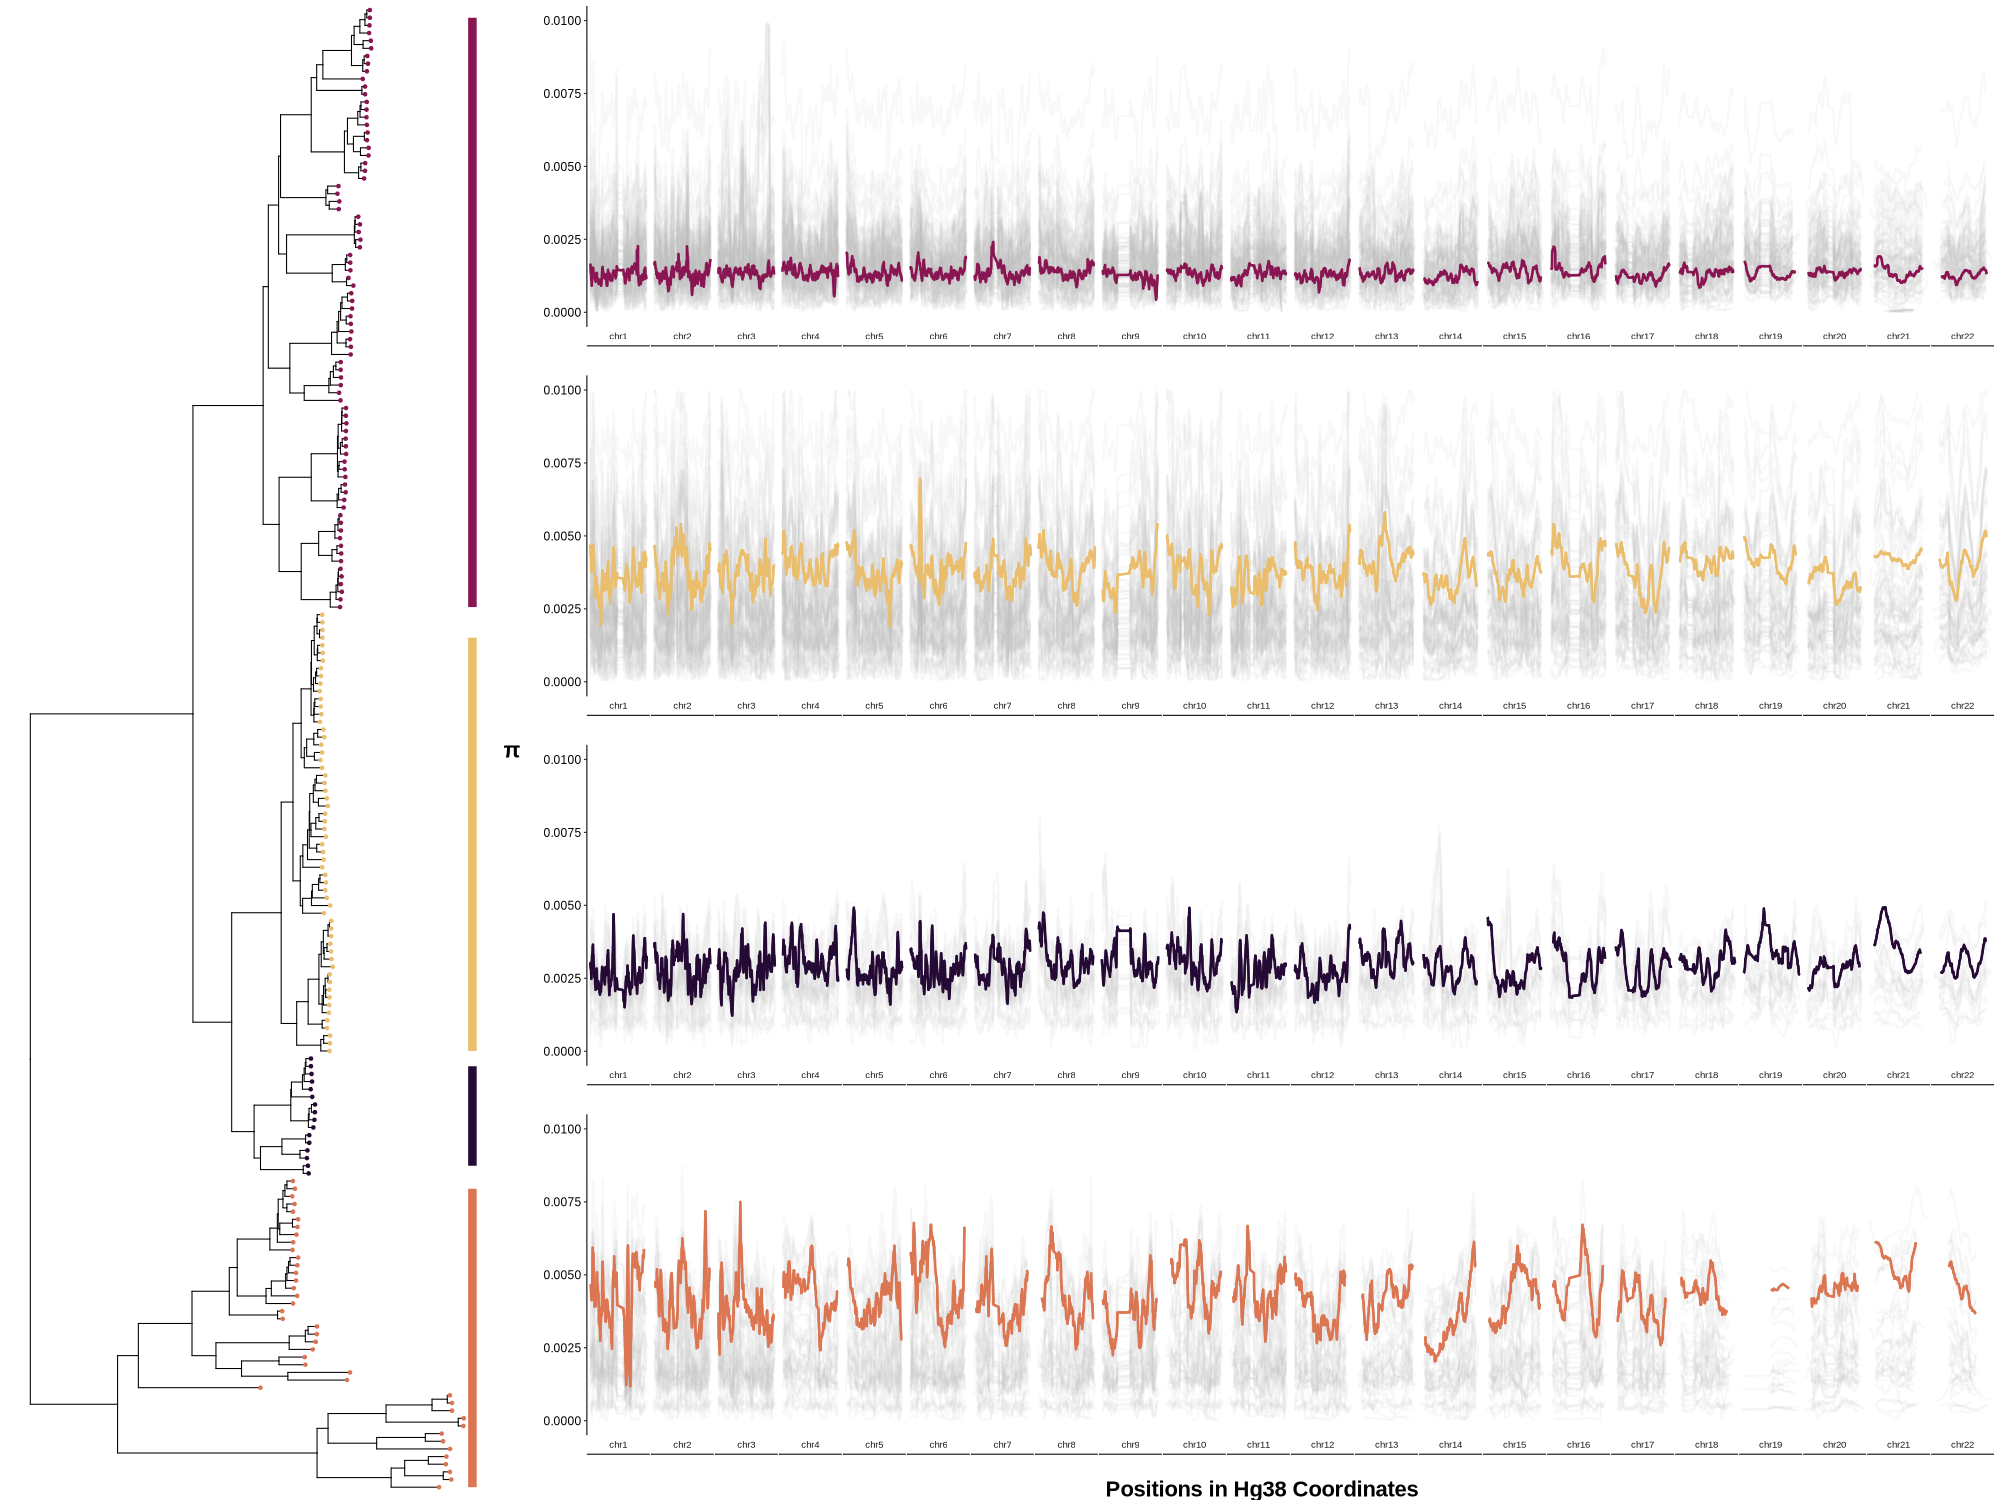

In [33]:
%%R -h 1500 -w 2000



sub_figure <- ggarrange(plot_diversity_genome_new_world,
                      plot_diversity_genome_old_world,
                      plot_diversity_genome_apes,
                      plot_diversity_genome_prosimians,
                      ncol=1,nrow=4, align = 'v')
sub_figure <- annotate_figure(sub_figure,
                bottom = text_grob("Positions in Hg38 Coordinates", color = "black", face = "bold", size = 22),
                left = text_grob("π", color = "black",face = "bold", size = 22))


figure <- ggarrange(plot_tree2, sub_figure, 
          widths = c(1,3),
          ncol=2)
figure

In [214]:
%%R
ggsave("pi_across_all_species_and_phylogenetic_tree.svg", figure, width = 45, height = 17, units = "cm", dpi = 1000)

## AVG PI 

In [3]:
%%R
df <- read_delim('../../results/combined/all.csv', delim=',')
filtered_df <- df %>% filter(chr != 'chrX') %>% group_by(genus,species, chr) %>% filter(freq_mean > .5)
pg_namedf <- read_delim('../../data/genus_phylogenetic_group_metadata.txt', delim='\t')

merged_data <- merge(filtered_df, pg_namedf, by.x = "genus", by.y = "genus", all.x = TRUE)

Rows: 5257244 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): chr, species, genus
dbl (13): start, end, freq_mean, freq_min, freq_max, freq_median, window_siz...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 57 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): genus, pg_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
%%R
kuderna_data <- read_delim('../../data/science.abn7829_data_s2.csv', delim=',')


Rows: 222 Columns: 52
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): SPECIES_BINOMIAL, GENUS, SPECIES, FAMILY, IUCN_STATUS, THREATENED_...
dbl (42): MEDIAN_N_HET, MEDIAN_CALLABLE, MEDIAN_nRoH_1mb, MEDIAN_sRoH_1mb, M...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
%%R # MEDIAN HETEROZYGOSITY FROM THE ORIGINAL PAPER
reduced_kuderna_data <- kuderna_data %>% select(SPECIES_BINOMIAL,MEDIAN_HETEROZYGOSITY)

In [6]:
%%R # MEDIAN PI FOR ALL SPECIES 
summary_pi <- merged_data %>% 
    mutate(SPECIES_BINOMIAL = paste0(genus,'_',species)) %>%
    group_by(SPECIES_BINOMIAL,genus,species,pg_name) %>%
    reframe(
        median_pi = median(PI),
        mean_pi = mean(PI),
        var_pi = var(PI))
summary_pi

# A tibble: 194 × 7
   SPECIES_BINOMIAL            genus   species pg_name median_pi mean_pi  var_pi
   <chr>                       <chr>   <chr>   <chr>       <dbl>   <dbl>   <dbl>
 1 Allenopithecus_nigroviridis Alleno… nigrov… Old_wo…   0.00156 0.00172 1.10e-6
 2 Allochrocebus_lhoesti       Alloch… lhoesti Old_wo…   0.00280 0.00294 2.15e-6
 3 Allochrocebus_preussi       Alloch… preussi Old_wo…   0.00303 0.00305 4.21e-6
 4 Allochrocebus_solatus       Alloch… solatus Old_wo…   0.00372 0.00361 5.66e-6
 5 Alouatta_belzebul           Alouat… belzeb… New_wo…   0.00184 0.00207 2.54e-6
 6 Alouatta_caraya             Alouat… caraya  New_wo…   0.00127 0.00152 2.08e-6
 7 Alouatta_discolor           Alouat… discol… New_wo…   0.00230 0.00258 2.64e-6
 8 Alouatta_juara              Alouat… juara   New_wo…   0.00235 0.00253 2.23e-6
 9 Alouatta_macconnelli        Alouat… maccon… New_wo…   0.00231 0.00242 1.57e-6
10 Alouatta_nigerrima          Alouat… nigerr… New_wo…   0.00231 0.00239 1.65e-6
# ℹ 184 

In [9]:
%%R #DIVERSITY WITHIN PHYLOGENETIC GROUPINGS 
merged_data %>% group_by(pg_name) %>% reframe(median = median(PI), var = var(PI))

# A tibble: 4 × 3
  pg_name            median        var
  <chr>               <dbl>      <dbl>
1 Great_apes        0.00205 0.00000267
2 New_world_monkeys 0.00155 0.00000946
3 Old_world_monkeys 0.00214 0.00000515
4 Prosimians        0.00198 0.00000965


In [49]:
%%R # HIGHEST AND LOWEST MEAN PI
summary_pi %>% filter(mean_pi == min(mean_pi) | mean_pi == max(mean_pi))

# A tibble: 2 × 7
  SPECIES_BINOMIAL     genus      species   pg_name    median_pi mean_pi  var_pi
  <chr>                <chr>      <chr>     <chr>          <dbl>   <dbl>   <dbl>
1 Chiropotes_albinasus Chiropotes albinasus New_world…   0.0255  2.53e-2 1.58e-5
2 Mico_spnv            Mico       spnv      New_world…   0.00019 4.19e-4 6.71e-7


In [50]:
%%R # HIGHEST AND LOWEST MEDIAN PI
summary_pi %>% filter(median_pi == min(median_pi) | median_pi == max(median_pi))

# A tibble: 2 × 7
  SPECIES_BINOMIAL     genus      species   pg_name    median_pi mean_pi  var_pi
  <chr>                <chr>      <chr>     <chr>          <dbl>   <dbl>   <dbl>
1 Alouatta_palliata    Alouatta   palliata  New_world…   0.00016 5.63e-4 1.90e-6
2 Chiropotes_albinasus Chiropotes albinasus New_world…   0.0255  2.53e-2 1.58e-5


In [51]:
%%R # VARIANCE 
summary_pi %>% filter(var_pi == min(var_pi) | var_pi == max(var_pi))

# A tibble: 2 × 7
  SPECIES_BINOMIAL             genus   species pg_name median_pi mean_pi  var_pi
  <chr>                        <chr>   <chr>   <chr>       <dbl>   <dbl>   <dbl>
1 Chiropotes_albinasus         Chirop… albina… New_wo…    0.0255 2.53e-2 1.58e-5
2 Daubentonia_madagascariensis Dauben… madaga… Prosim…    0.0004 4.60e-4 1.91e-7


In [52]:
%%R
compare_kurderna_data <- left_join(summary_pi, reduced_kuderna_data, by = c('SPECIES_BINOMIAL' = 'SPECIES_BINOMIAL'))


In [54]:
%%R
 compare_kurderna_data %>% filter((species %in% c('zaza','albinasus'))) 

# A tibble: 2 × 8
  SPECIES_BINOMIAL     genus      species   pg_name    median_pi mean_pi  var_pi
  <chr>                <chr>      <chr>     <chr>          <dbl>   <dbl>   <dbl>
1 Chiropotes_albinasus Chiropotes albinasus New_world…    0.0255  0.0253 1.58e-5
2 Mirza_zaza           Mirza      zaza      Prosimians    0.0176  0.0178 9.35e-6
# ℹ 1 more variable: MEDIAN_HETEROZYGOSITY <dbl>


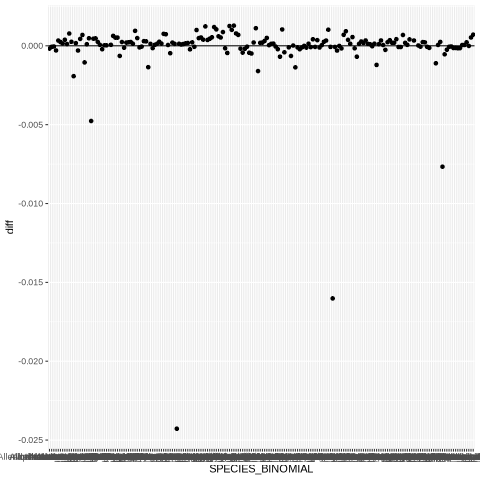

In [88]:
%%R # COMPARISONS BETWEEN PI ESTIAMES AND AVG HETEROZYGOSITY
compare_kurderna_data %>% 
    #filter(!(SPECIES_BINOMIAL %in% c('Ateles_chamek','Semnopithecus_entellus','Chiropotes_albinasus','Mirza_zaza'))) %>%
    group_by(SPECIES_BINOMIAL) %>%
           reframe(diff = MEDIAN_HETEROZYGOSITY-median_pi) %>% ggplot(aes(x=SPECIES_BINOMIAL,y=diff))+geom_point()+geom_hline(yintercept=0)

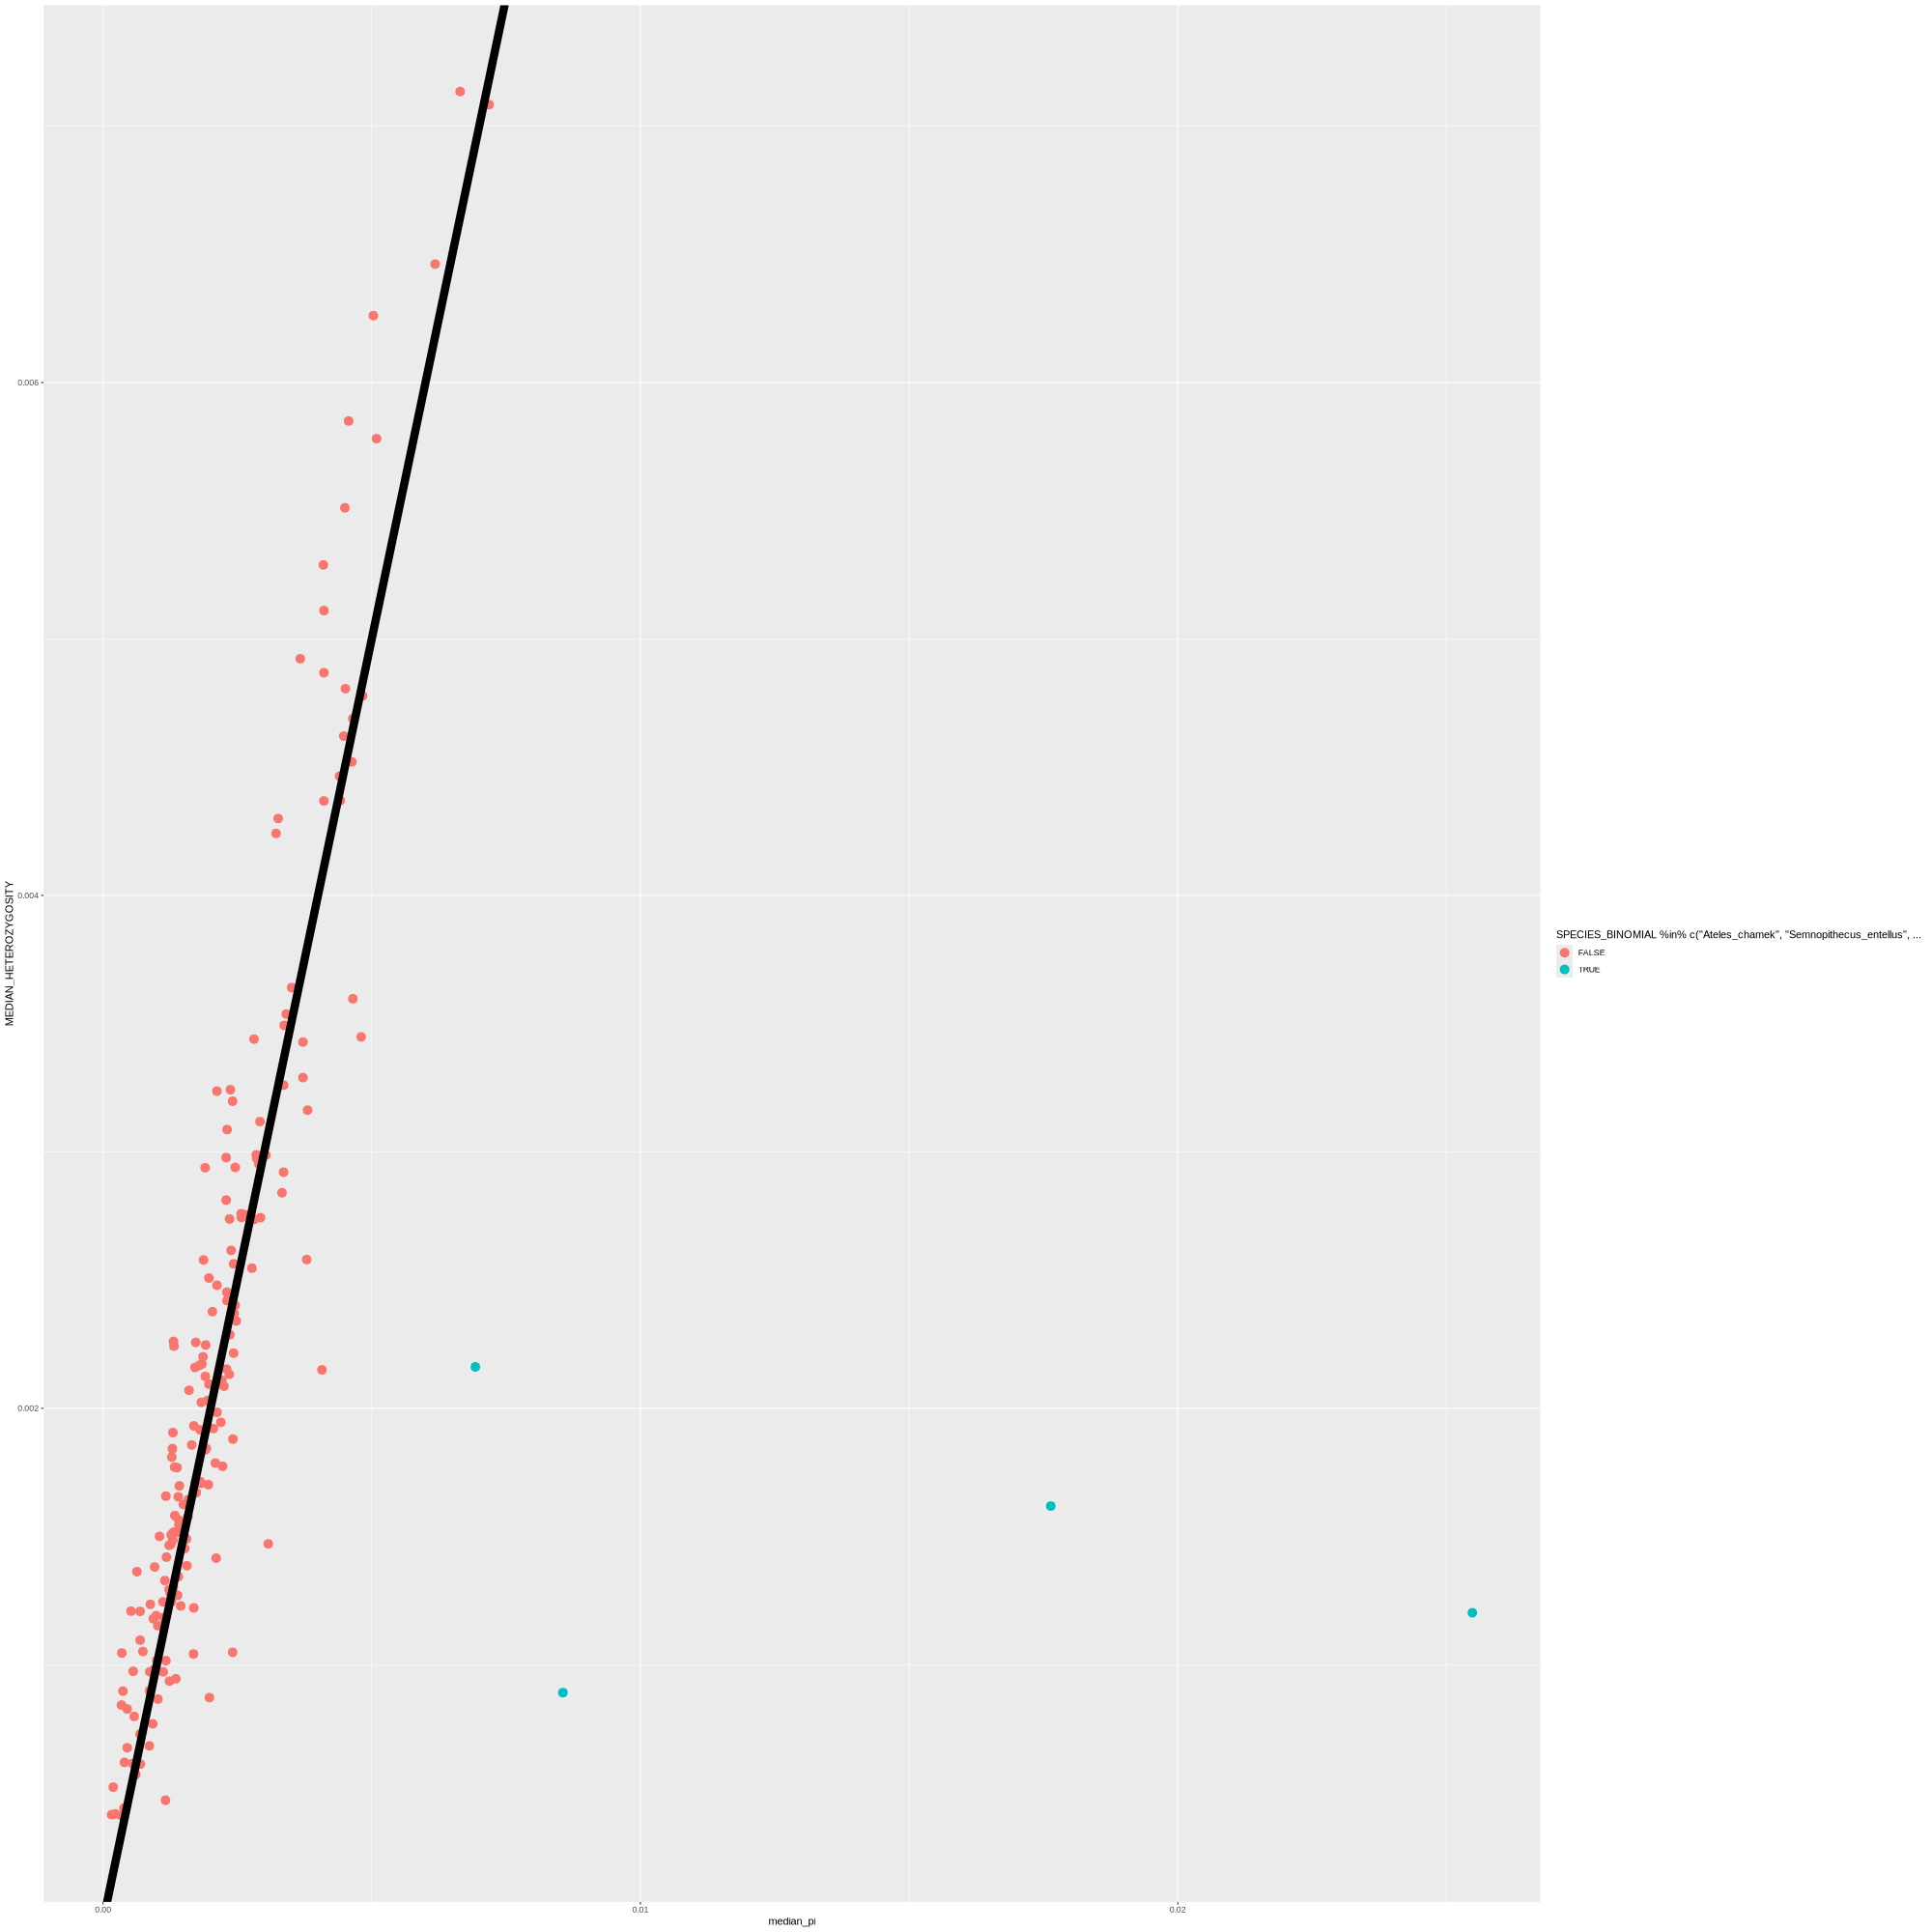

In [70]:
%%R  # COMPARISONS BETWEEN PI ESTIAMES AND AVG HETEROZYGOSITY
compare_kurderna_data %>%
    ggplot(aes(x=median_pi,y=MEDIAN_HETEROZYGOSITY, col = SPECIES_BINOMIAL %in% c('Ateles_chamek','Semnopithecus_entellus','Chiropotes_albinasus','Mirza_zaza')))+
    geom_point(size = 4)+
    geom_abline(intecept=0,slope=1, size= 4)
    

In [56]:
%%R
metadata <- read_delim('../../data/Kuderna_et_al_2023.csv', delim=',')

Rows: 222 Columns: 52
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): SPECIES_BINOMIAL, GENUS, SPECIES, FAMILY, IUCN_STATUS, THREATENED_...
dbl (42): MEDIAN_N_HET, MEDIAN_CALLABLE, MEDIAN_nRoH_1mb, MEDIAN_sRoH_1mb, M...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [68]:
%%R
head(metadata)

# A tibble: 6 × 52
  SPECIES_BINOMIAL            GENUS SPECIES FAMILY IUCN_STATUS THREATENED_STATUS
  <chr>                       <chr> <chr>   <chr>  <chr>       <chr>            
1 Allenopithecus_nigroviridis Alle… nigrov… Cerco… LC          Unthreatened     
2 Allochrocebus_lhoesti       Allo… lhoesti Cerco… VU          Threatened       
3 Allochrocebus_preussi       Allo… preussi Cerco… EN          Threatened       
4 Allochrocebus_solatus       Allo… solatus Cerco… NT          Unthreatened     
5 Alouatta_belzebul           Alou… belzeb… Ateli… VU          Threatened       
6 Alouatta_caraya             Alou… caraya  Ateli… NT          Unthreatened     
# ℹ 46 more variables: GEOGRAPHIC_REGION <chr>, MEDIAN_N_HET <dbl>,
#   MEDIAN_CALLABLE <dbl>, MEDIAN_nRoH_1mb <dbl>, MEDIAN_sRoH_1mb <dbl>,
#   MEDIAN_fRoH_1mb <dbl>, MEDIAN_COVERAGE <dbl>, REFERENCE_LENGTH <dbl>,
#   MEDIAN_HETEROZYGOSITY <dbl>, GENERATION_LENGTH <dbl>,
#   MU_PER_GENERATION <dbl>, MU_PER_YEAR <dbl>, EFFECTIVE_PO

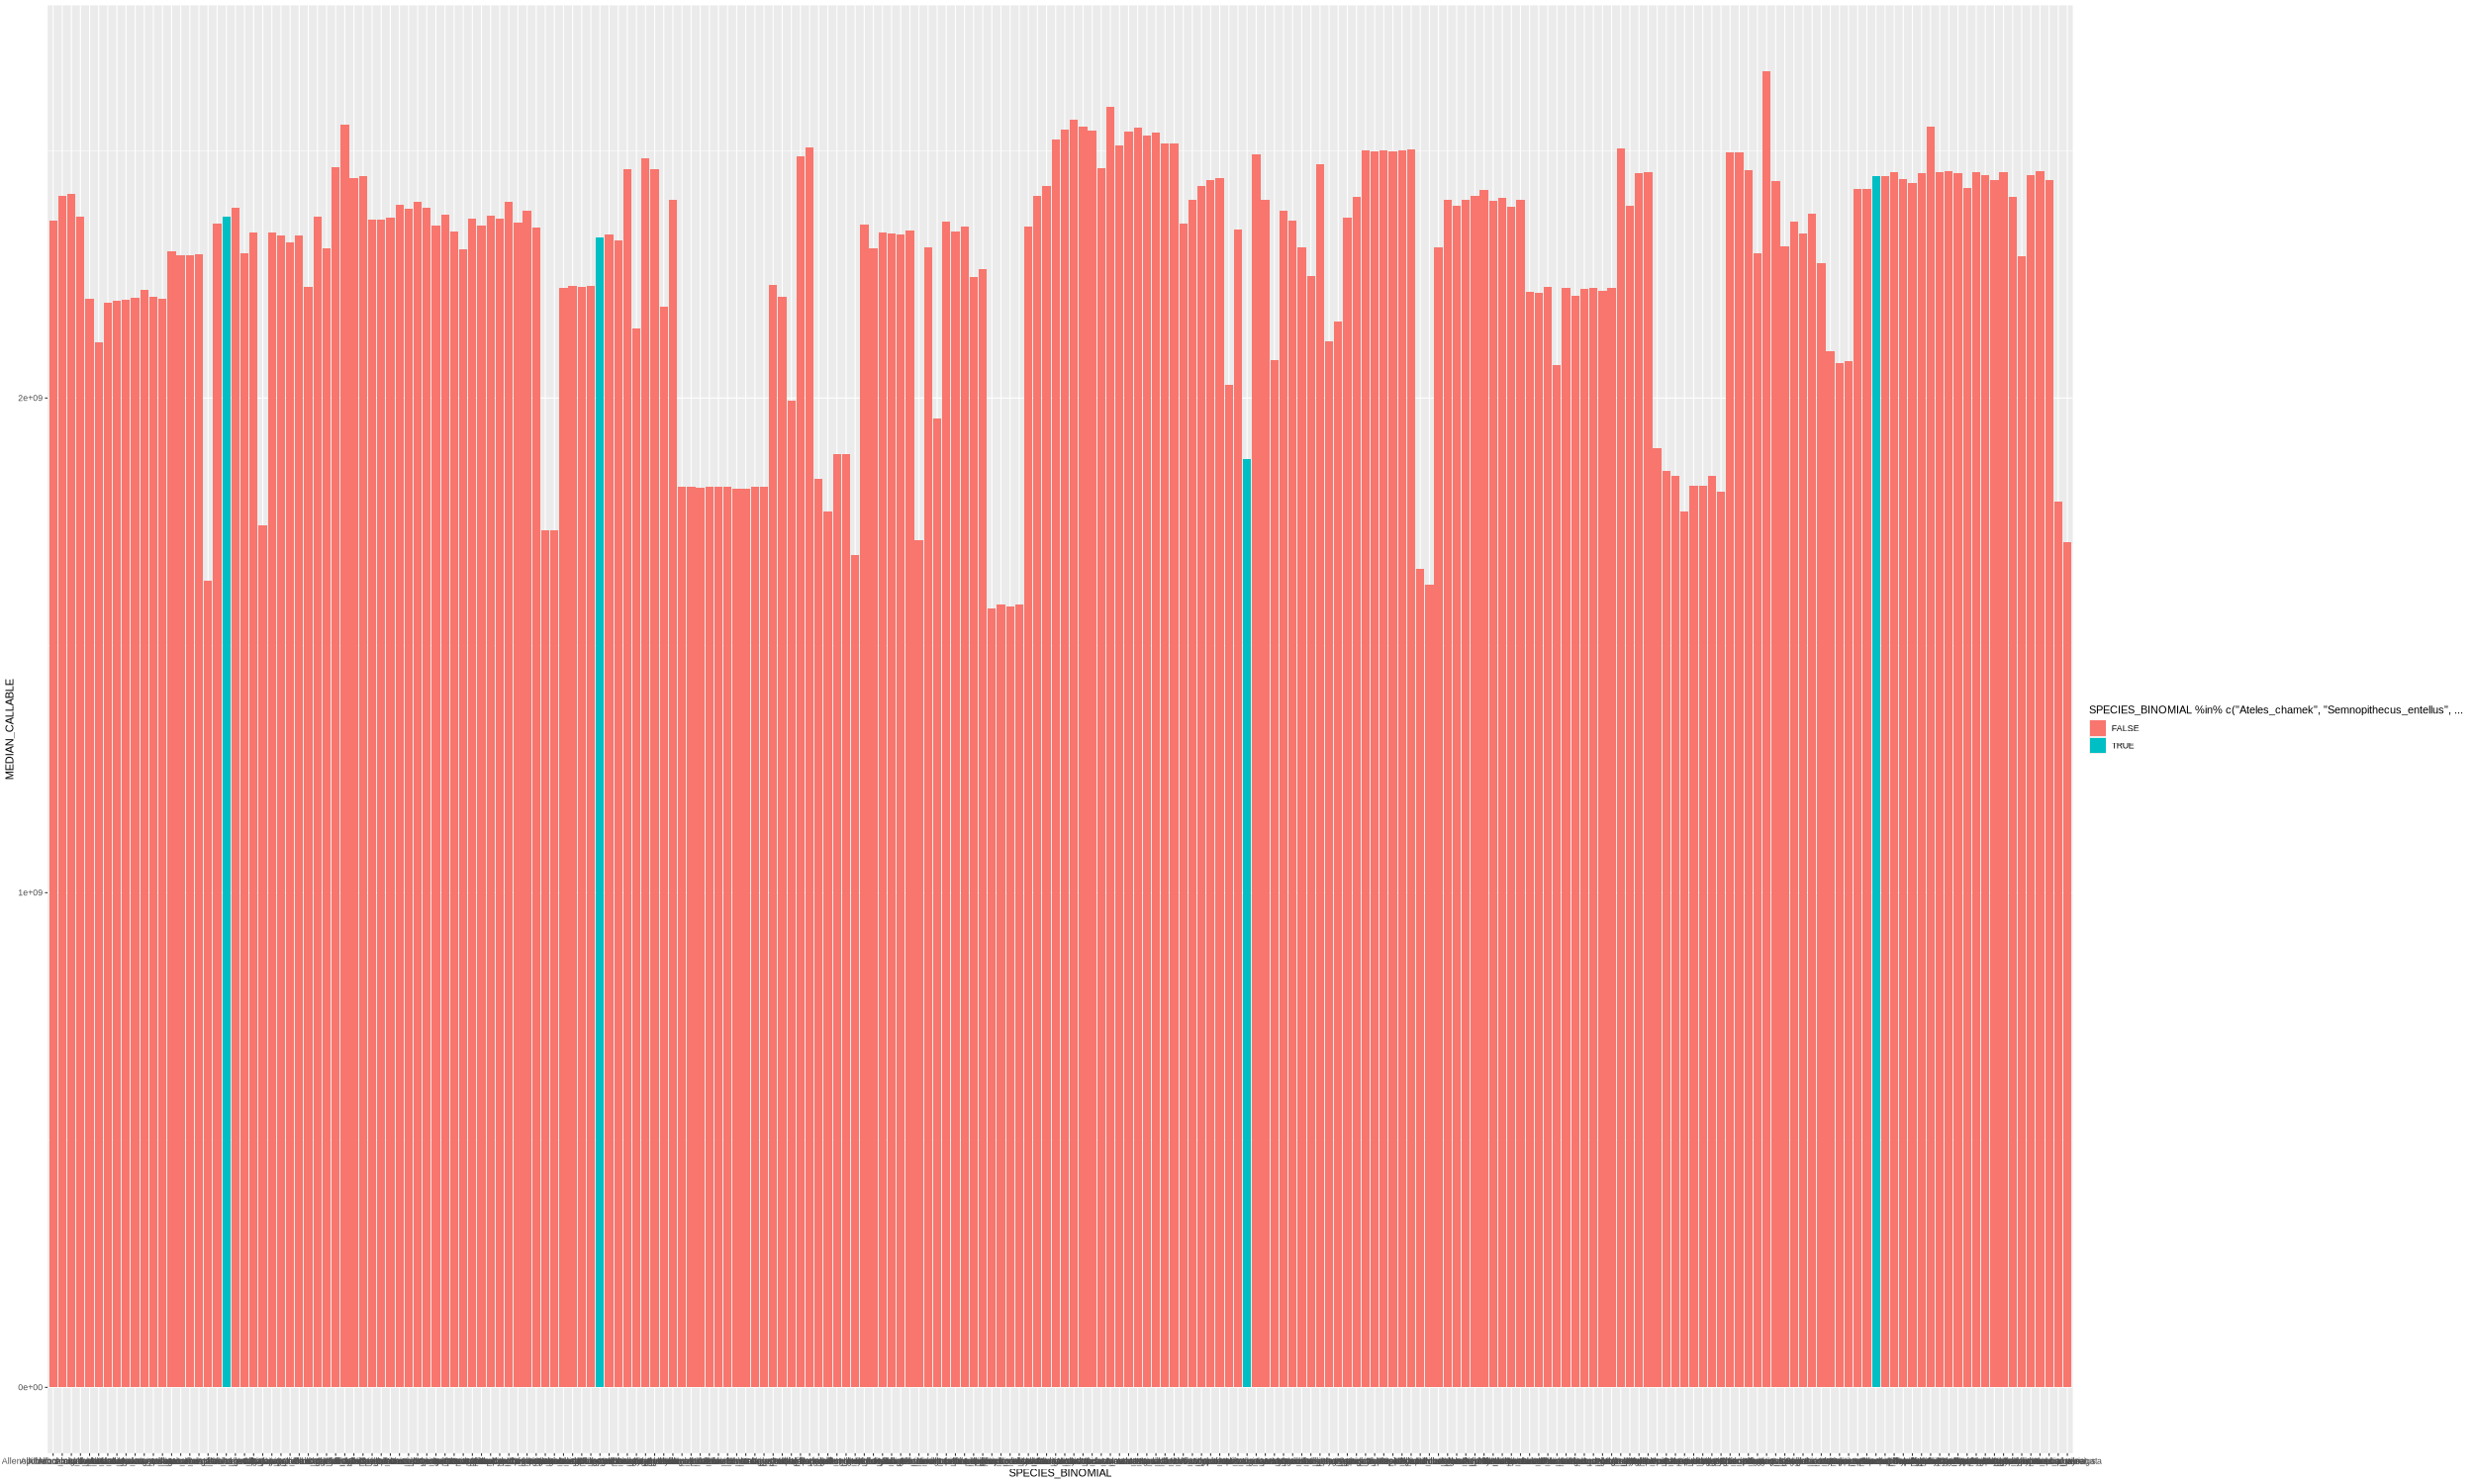

In [64]:
%%R -h 1500 -w 2500
metadata %>% 
    ggplot(aes(x=SPECIES_BINOMIAL, y=MEDIAN_CALLABLE, fill = SPECIES_BINOMIAL %in% c('Ateles_chamek','Semnopithecus_entellus','Chiropotes_albinasus','Mirza_zaza')))+
    geom_histogram(stat='identity')

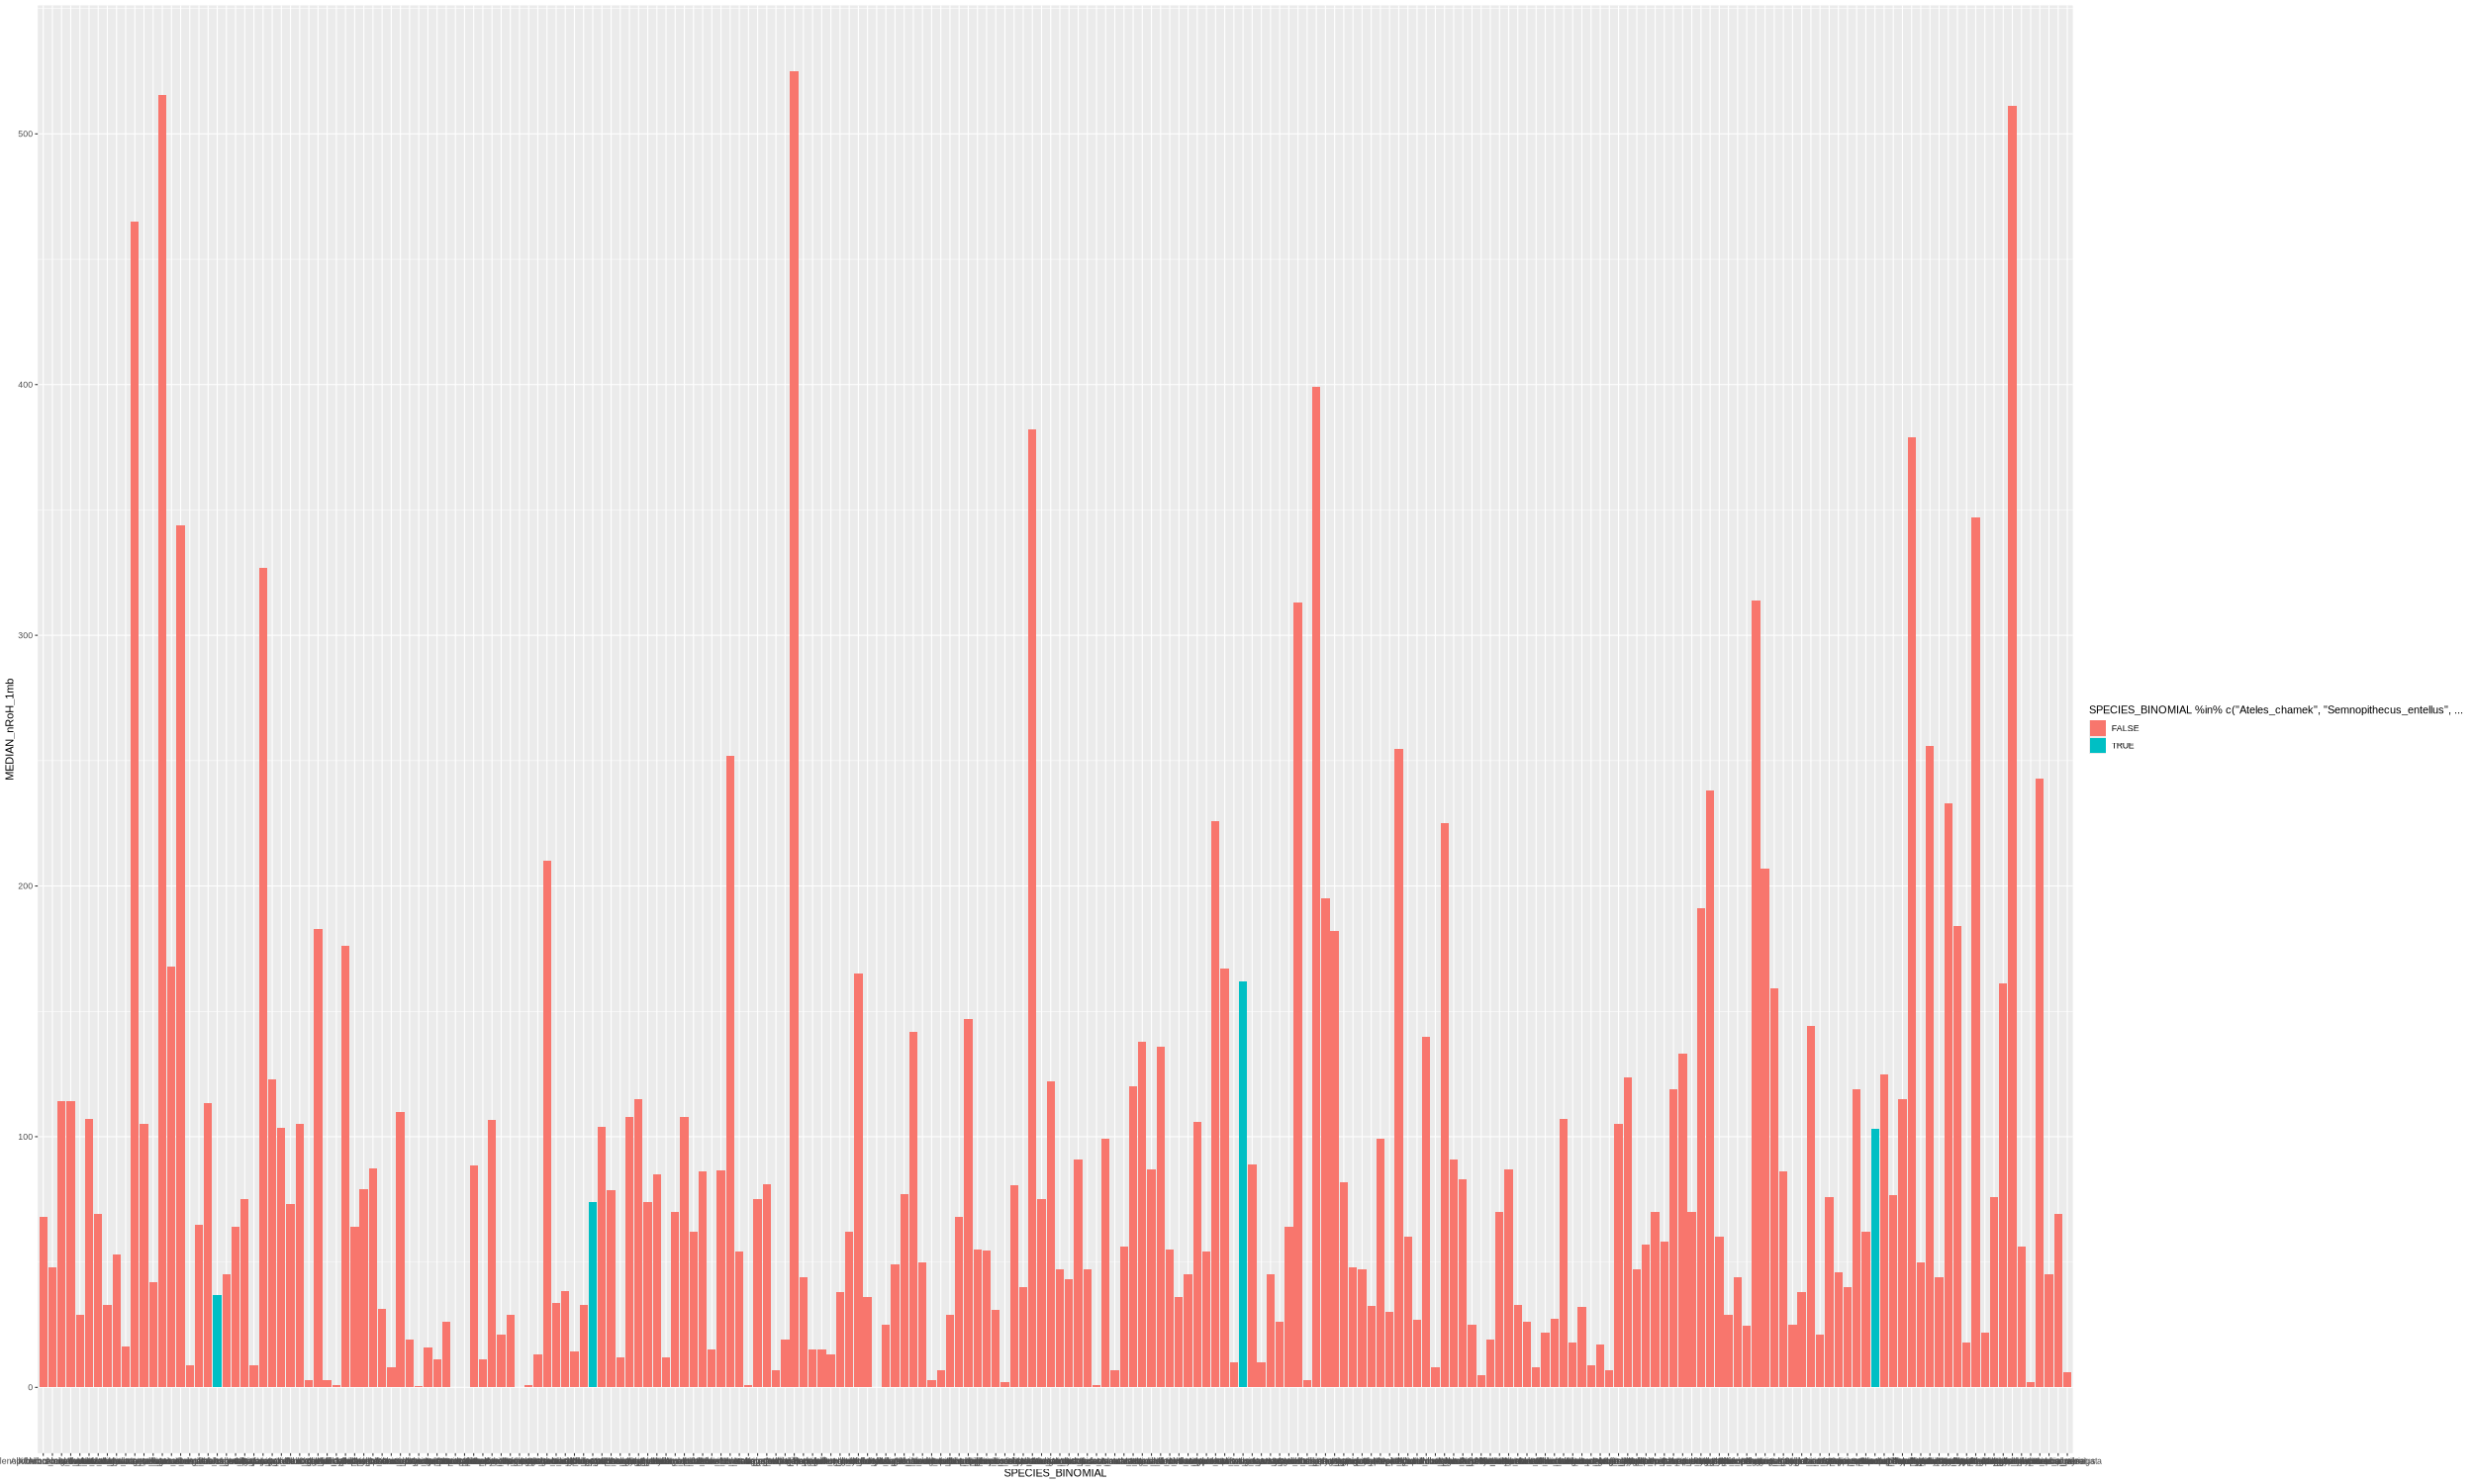

In [66]:
%%R -h 1500 -w 2500
metadata %>% 
    ggplot(aes(x=SPECIES_BINOMIAL, y=MEDIAN_nRoH_1mb, fill = SPECIES_BINOMIAL %in% c('Ateles_chamek','Semnopithecus_entellus','Chiropotes_albinasus','Mirza_zaza')))+
    geom_histogram(stat='identity')

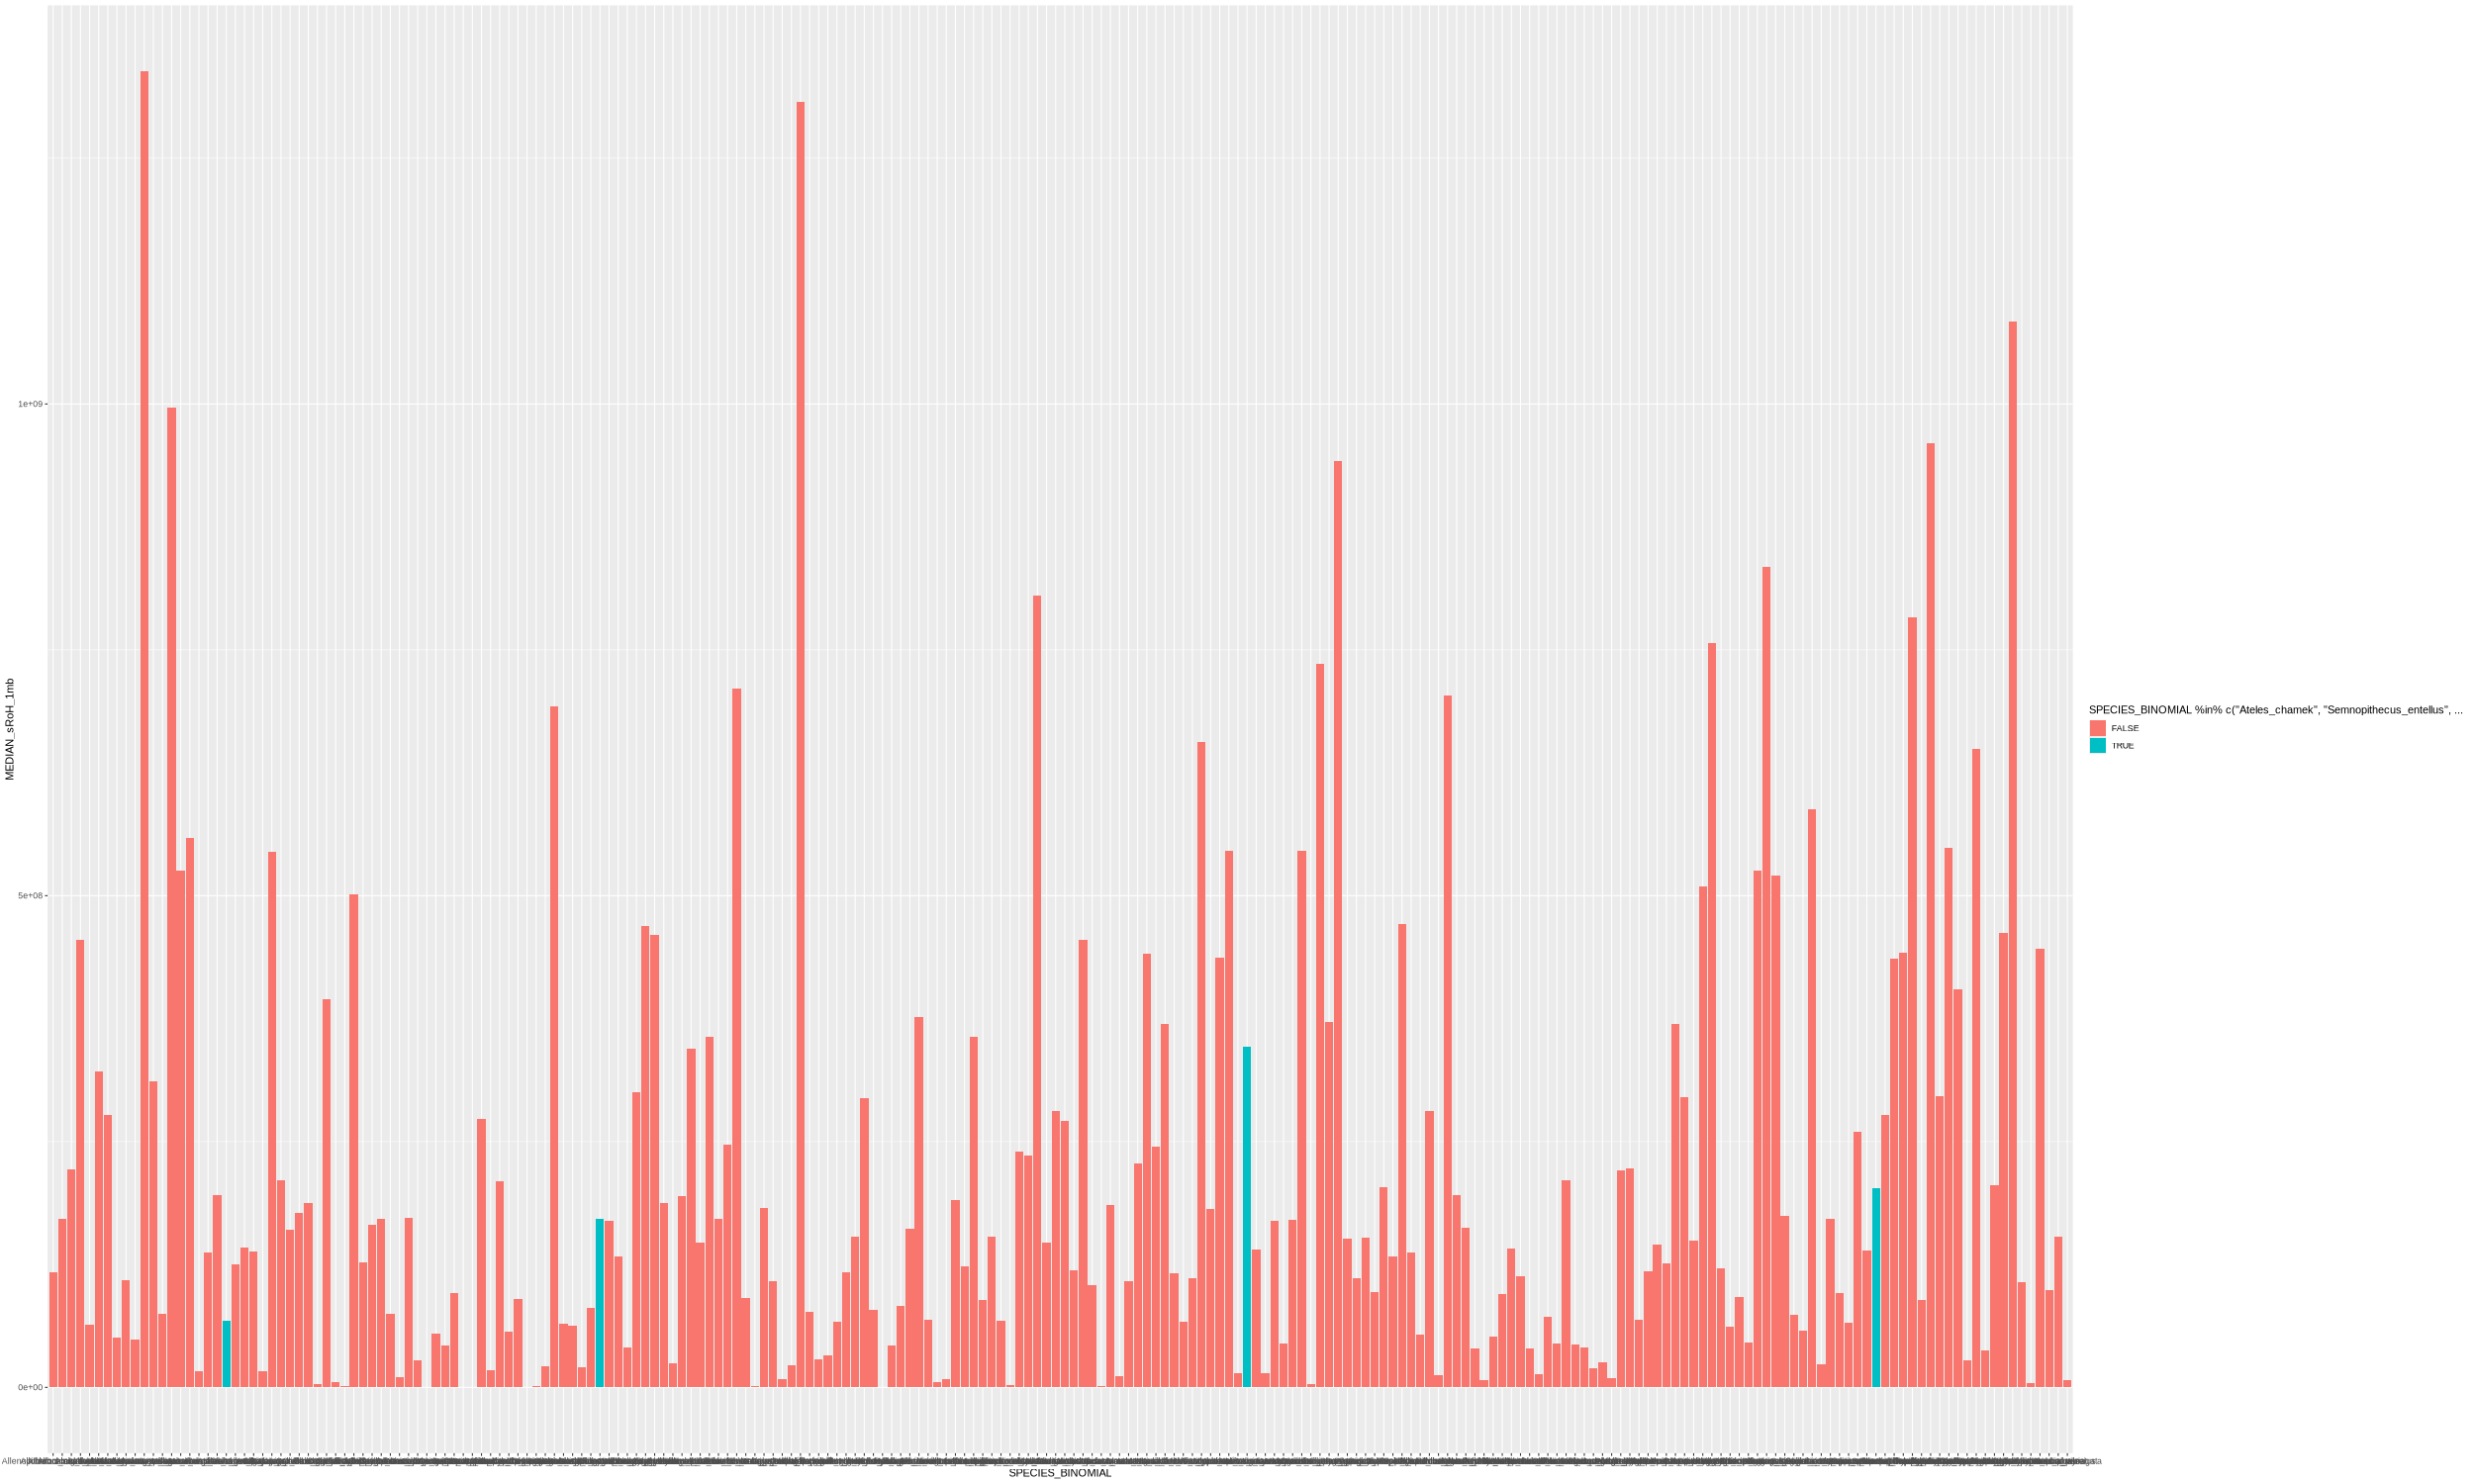

In [67]:
%%R -h 1500 -w 2500
metadata %>% 
    ggplot(aes(x=SPECIES_BINOMIAL, y=MEDIAN_sRoH_1mb, fill = SPECIES_BINOMIAL %in% c('Ateles_chamek','Semnopithecus_entellus','Chiropotes_albinasus','Mirza_zaza')))+
    geom_histogram(stat='identity')

# PI IN THE MIDDEL OF THE CHROMOSOME COMPARED TO THE TELOMERES

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


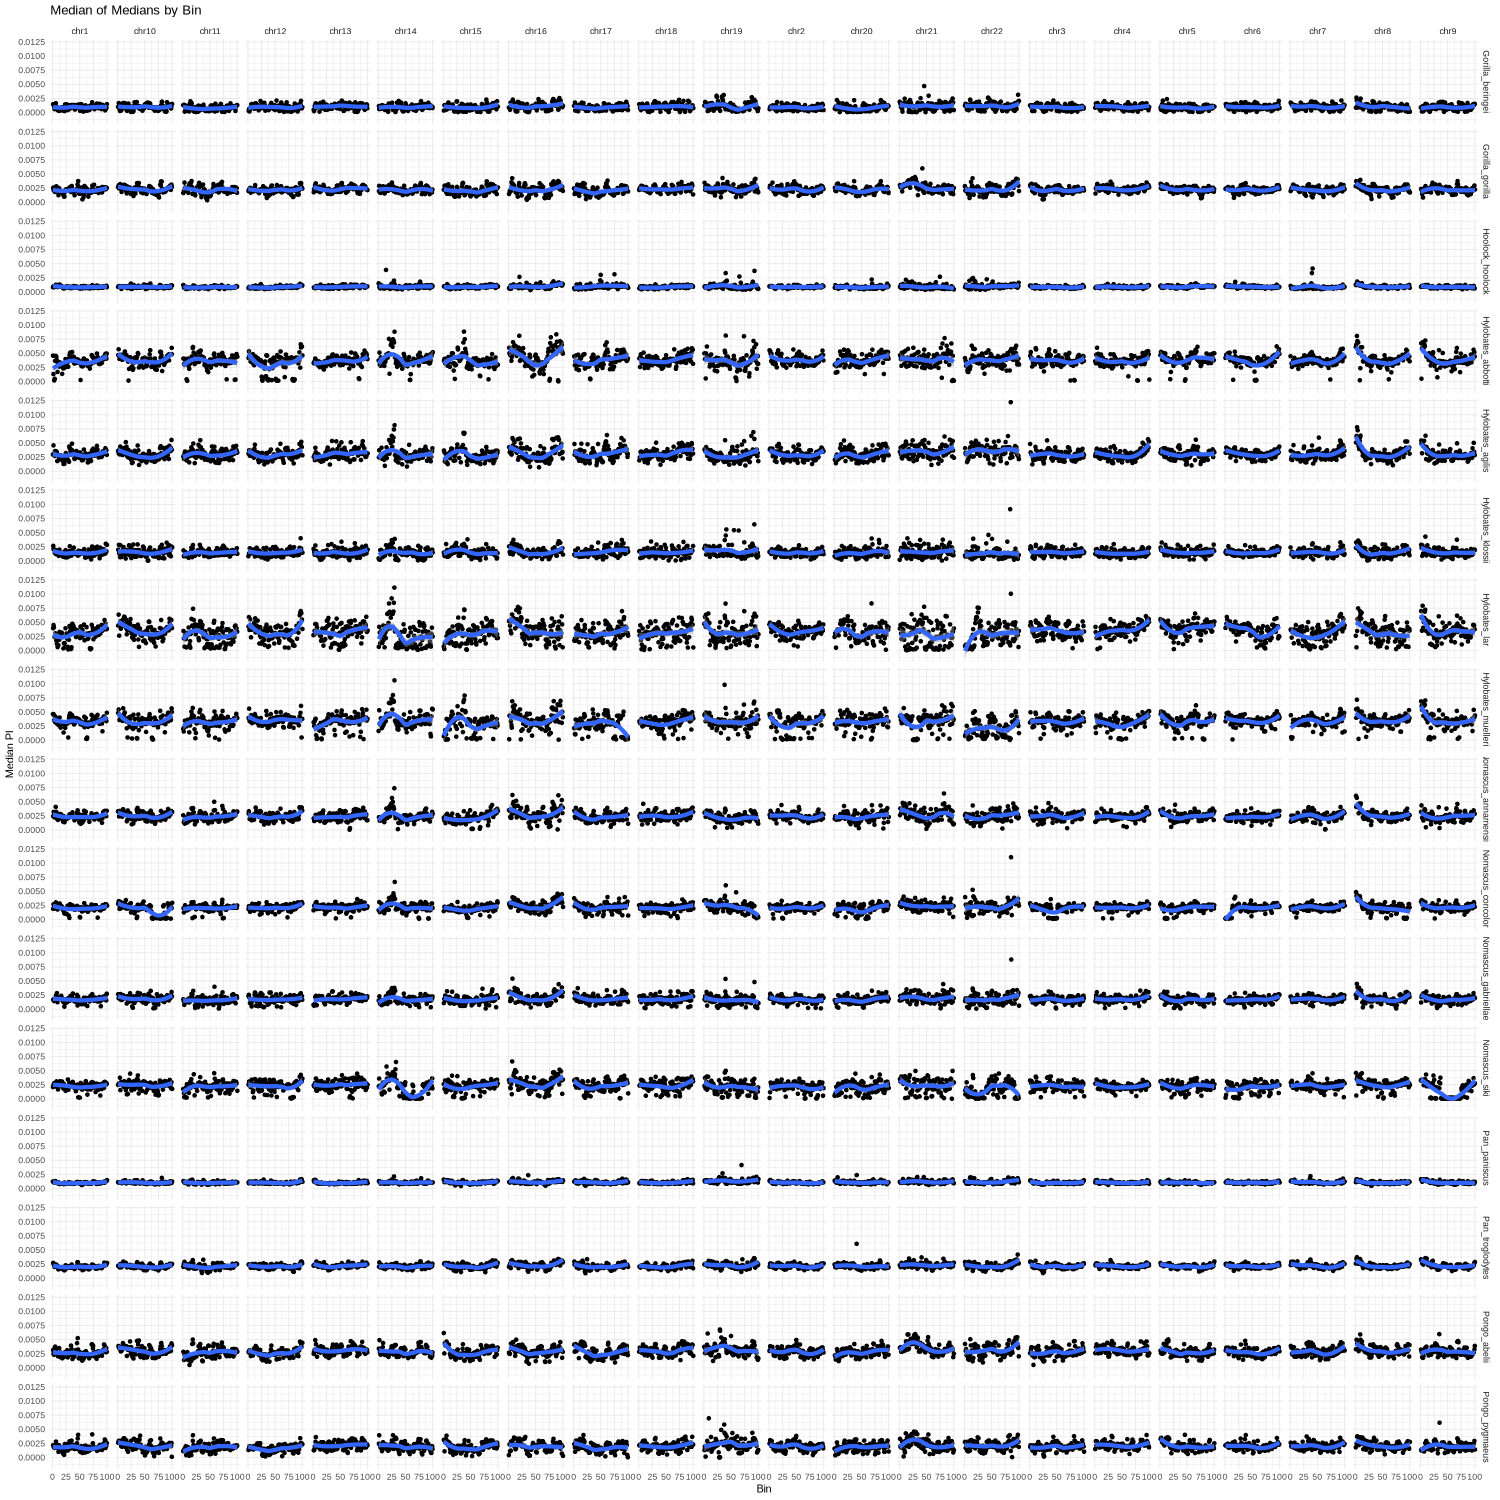

In [46]:
%%R -h 1500 -w 1500


# Calculate the median for each bin and species
median_data <- merged_data %>%
    filter(pg_name == 'Great_apes') %>%
    mutate(SPECIES_BINOMIAL = paste0(genus, '_', species)) %>%
    group_by(SPECIES_BINOMIAL, chr) %>%
    mutate(bin = ntile(start, 100)) %>%
    group_by(SPECIES_BINOMIAL, chr, bin) %>%
    reframe(median = median(PI))



# Plotting
ggplot(median_data, aes(x = bin, y = median)) +
    geom_jitter() +
    geom_smooth(size = 2)+
    facet_grid(SPECIES_BINOMIAL ~ chr) +
    labs(title = "Median of Medians by Bin",
         x = "Bin",
         y = "Median PI") +
    theme_minimal()
